## Fix Paths
Change sys.path to use my tensortrade instead of the one in env

In [1]:
import sys
import os
# sys.path.append("/Users/jasonfiacco/Documents/Yale/Senior/thesis/deeptrader")
# sys.path.append("/Users/jasonfiacco/Documents/Yale/Senior/thesis/deeptrader/GetOldTweets")
sys.path.append(os.path.realpath(".."))
sys.path.append(os.path.realpath("../GetOldTweets"))
print(sys.path)

['/home/accts/jcf73/thesis/deeptrader/examples', '/home/accts/jcf73/thesis/venv/lib64/python37.zip', '/home/accts/jcf73/thesis/venv/lib64/python3.7', '/home/accts/jcf73/thesis/venv/lib64/python3.7/lib-dynload', '/usr/lib64/python3.7', '/usr/lib/python3.7', '', '/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages', '/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/IPython/extensions', '/home/accts/jcf73/.ipython', '/home/accts/jcf73/thesis/deeptrader', '/home/accts/jcf73/thesis/deeptrader/GetOldTweets']


## Fetch the Labeled PredictIt Data  
First, fetch the data that was already labeled with the technical and sentiment features in data_labeler.ipynb

In [2]:
import ssl
import pandas as pd
import ta
from datetime import datetime, timedelta

ssl._create_default_https_context = ssl._create_unverified_context # Only used if pandas gives a SSLError

def fetch_data(symbol):
    path = "../predictit_datasets/"
    filename = "{}_labeled.csv".format(symbol)

    df = pd.read_csv(path + filename)
    
    df = df.set_index("Date")


    return df

In [3]:
all_data = pd.concat([
    fetch_data("WARREN"),
    fetch_data("CRUZ"),
    fetch_data("MANCHIN"),
    fetch_data("SANDERS"),
    fetch_data("NELSON"),
    fetch_data("DONNELLY"),
    fetch_data("PELOSI"),
    fetch_data("MANAFORT"),
    fetch_data("BROWN"),
    fetch_data("RYAN"),
    fetch_data("STABENOW"),
    fetch_data("KNIGHT"),
    fetch_data("MCCASKILL"),
    fetch_data("BALDWIN"),
    fetch_data("DENHAM"),
    fetch_data("HEITKAMP"),
    fetch_data("TESTER"),
    fetch_data("HURD"),
    fetch_data("HEINRICH"),
    fetch_data("MENENDEZ")
], axis=1)
all_data.head()

,WARREN:open,WARREN:low,WARREN:high,WARREN:close,WARREN:volume,WARREN:average,WARREN:price_norm,WARREN:current_date,WARREN:sentiment,WARREN:volume_adi,...,MENENDEZ:momentum_uo,MENENDEZ:momentum_stoch,MENENDEZ:momentum_stoch_signal,MENENDEZ:momentum_wr,MENENDEZ:momentum_ao,MENENDEZ:momentum_kama,MENENDEZ:momentum_roc,MENENDEZ:others_dr,MENENDEZ:others_dlr,MENENDEZ:others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.81,0.79,0.82,0.80,768,0.8067,0.987654,2017-02-01,0.04693,-256.0,...,NaN,7.142857,7.142857,-92.857143,0.0,NaN,NaN,-4.508748,NaN,0.0
2017-02-02,0.80,0.79,0.80,0.79,50,0.7996,0.987500,2017-02-02,0.05167,-306.0,...,NaN,7.142857,7.142857,-92.857143,0.0,NaN,NaN,0.000000,0.0,0.0
2017-02-03,0.79,0.78,0.80,0.78,592,0.7813,0.987342,2017-02-03,0.07868,-898.0,...,NaN,7.142857,7.142857,-92.857143,0.0,NaN,NaN,0.000000,0.0,0.0
2017-02-04,0.78,0.78,0.79,0.79,10,0.7900,1.012821,2017-02-04,0.14822,-888.0,...,NaN,7.142857,7.142857,-92.857143,0.0,NaN,NaN,0.000000,0.0,0.0
2017-02-05,0.79,0.79,0.80,0.80,6,0.7950,1.012658,2017-02-05,-0.01526,-882.0,...,NaN,7.142857,7.142857,-92.857143,0.0,NaN,NaN,0.000000,0.0,0.0


## Plot the closing prices for all the markets

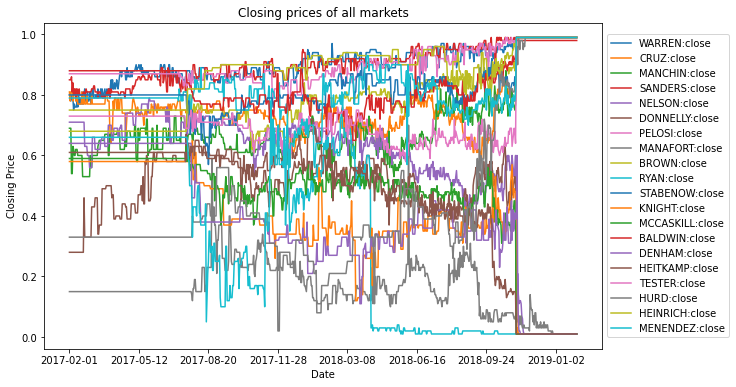

In [4]:
import matplotlib.pyplot as plt
closing_prices = all_data.loc[:, [("close" in name) for name in all_data.columns]]
closing_prices.plot(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing prices of all markets")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

In [5]:
#Copy it over cause of variable names
subset_data = all_data

## Define The Exchange

An exchange keeps track of the prices of all the assets and executes any orders. It takes in data streams of all the closing prices for each asset.

In [6]:
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream

#Exchange(name of exchange, service)
#Each Stream takes a name, and then a list of the closing prices.

predictit_exch = Exchange("predictit", service=execute_order)(
    Stream("USD-WARREN", list(subset_data['WARREN:close'])),
    Stream("USD-CRUZ", list(subset_data['CRUZ:close'])),
    Stream("USD-MANCHIN", list(subset_data['MANCHIN:close'])),
    Stream("USD-SANDERS", list(subset_data['SANDERS:close'])),
    Stream("USD-NELSON", list(subset_data['NELSON:close'])),
    Stream("USD-DONNELLY", list(subset_data['DONNELLY:close'])),
    Stream("USD-PELOSI", list(subset_data['PELOSI:close'])),
    Stream("USD-MANAFORT", list(subset_data['MANAFORT:close'])),
    Stream("USD-BROWN", list(subset_data['BROWN:close'])),
    Stream("USD-RYAN", list(subset_data['RYAN:close'])),
    Stream("USD-STABENOW", list(subset_data['STABENOW:close'])),
    Stream("USD-KNIGHT", list(subset_data['KNIGHT:close'])),
    Stream("USD-MCCASKILL", list(subset_data['MCCASKILL:close'])),
    Stream("USD-BALDWIN", list(subset_data['BALDWIN:close'])),
    Stream("USD-DENHAM", list(subset_data['DENHAM:close'])),
    Stream("USD-HEITKAMP", list(subset_data['HEITKAMP:close'])),
    Stream("USD-TESTER", list(subset_data['TESTER:close'])),
    Stream("USD-HURD", list(subset_data['HURD:close'])),
    Stream("USD-HEINRICH", list(subset_data['HEINRICH:close'])),
    Stream("USD-MENENDEZ", list(subset_data['MENENDEZ:close']))
)

Now that the exchanges have been defined we can later define our features that we would like to include.

## Define the "Portfolio"

Make a Portfolio that will keep track of the asset balances. First import all the PredictIt instruments that were defined. Then feed them to the portfolio and outline the initial number of shares for each asset. In this case, the portfolio is initialized with 100,000 USD and 0 shares of each PredictIt asset.

In [7]:
#I am going to have to add "instruments" for all 25 of the PredictIt markets I'm working with.
from tensortrade.instruments import USD, WARREN, CRUZ, MANCHIN, SANDERS, NELSON, DONNELLY,\
                                PELOSI, MANAFORT, BROWN, RYAN, STABENOW, KNIGHT, MCCASKILL, \
                                BALDWIN, DENHAM, HEITKAMP, TESTER, HURD, HEINRICH, MENENDEZ
from tensortrade.wallets import Wallet, Portfolio

portfolio = Portfolio(USD, [
    Wallet(predictit_exch, 100000 * USD),
    Wallet(predictit_exch, 0 * WARREN),
    Wallet(predictit_exch, 0 * CRUZ),
    Wallet(predictit_exch, 0 * MANCHIN),
    Wallet(predictit_exch, 0 * SANDERS),
    Wallet(predictit_exch, 0 * NELSON),
    Wallet(predictit_exch, 0 * DONNELLY),
    Wallet(predictit_exch, 0 * PELOSI),
    Wallet(predictit_exch, 0 * MANAFORT),
    Wallet(predictit_exch, 0 * BROWN),
    Wallet(predictit_exch, 0 * RYAN),
    Wallet(predictit_exch, 0 * STABENOW),
    Wallet(predictit_exch, 0 * KNIGHT),
    Wallet(predictit_exch, 0 * MCCASKILL),
    Wallet(predictit_exch, 0 * BALDWIN),
    Wallet(predictit_exch, 0 * DENHAM),
    Wallet(predictit_exch, 0 * HEITKAMP),
    Wallet(predictit_exch, 0 * TESTER),
    Wallet(predictit_exch, 0 * HURD),
    Wallet(predictit_exch, 0 * HEINRICH),
    Wallet(predictit_exch, 0 * MENENDEZ)
])

## Normalization and Feature Engineering
Here we specify the observations our agent will see. We first filter out any features we do not want to include. We then normalize the data by creating a "stationary" time series. This amounts to differencing the logged data. 

In [8]:
#Select only the TA features to keep
features_to_keep = ["close", "sentiment", "volume", "trend_cci", "momentum_rsi"]
feature_data = subset_data.loc[:, [(any(word in name for word in features_to_keep)) for name in subset_data.columns]]

#Remove any extra volume columns
feature_data = feature_data[feature_data.columns.drop(list(feature_data.filter(regex='volume_')))]

feature_data

,WARREN:close,WARREN:volume,WARREN:sentiment,WARREN:trend_cci,WARREN:momentum_rsi,CRUZ:close,CRUZ:volume,CRUZ:sentiment,CRUZ:trend_cci,CRUZ:momentum_rsi,...,HEINRICH:close,HEINRICH:volume,HEINRICH:sentiment,HEINRICH:trend_cci,HEINRICH:momentum_rsi,MENENDEZ:close,MENENDEZ:volume,MENENDEZ:sentiment,MENENDEZ:trend_cci,MENENDEZ:momentum_rsi
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.80,768,0.04693,NaN,100.000000,0.81,1411,0.21082,NaN,100.000000,...,0.75,0,0.24841,NaN,100.000000,0.66,0,0.036070,NaN,100.000000
2017-02-02,0.79,50,0.05167,-66.666667,0.000000,0.78,924,0.06047,-66.666667,0.000000,...,0.75,0,0.43215,NaN,100.000000,0.66,0,-0.033775,NaN,100.000000
2017-02-03,0.78,592,0.07868,-87.500000,0.000000,0.81,25,0.14213,-33.333333,51.851852,...,0.75,0,0.03893,NaN,100.000000,0.66,0,0.011211,NaN,100.000000
2017-02-04,0.79,10,0.14822,-66.666667,35.831810,0.81,27,-0.05324,-30.769231,51.851852,...,0.75,0,0.01821,NaN,100.000000,0.66,0,0.000000,NaN,100.000000
2017-02-05,0.80,6,-0.01526,41.666667,53.698630,0.81,1,-0.12315,27.027027,51.851852,...,0.75,0,0.11472,NaN,100.000000,0.66,0,0.013943,NaN,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-28,0.99,0,-0.20105,166.666667,62.938371,0.99,0,0.17329,-166.666667,82.765969,...,0.99,0,-0.32189,600.0,68.170813,0.99,0,0.088950,333.333333,71.912774
2019-01-29,0.99,0,0.24873,166.666667,62.938371,0.99,0,-0.23346,-166.666667,82.765969,...,0.99,0,-0.23839,600.0,68.170813,0.99,0,-0.132570,333.333333,71.912774
2019-01-30,0.99,0,-0.04311,166.666667,62.938371,0.99,0,-0.04381,-166.666667,82.765969,...,0.99,0,0.02141,600.0,68.170813,0.99,0,-0.229600,333.333333,71.912774


In [9]:
#Make the time series stationary
import numpy as np

def get_log_and_diff(df, features):
    new_df = pd.DataFrame()

    #First handle close prices
    close_cols = [name for name in df.columns if any(word in name for word in ["close"]) ]
    for col in close_cols:
        new_df[col+"_diff"] = np.log(df[col]) - np.log(df[col].shift(1))

    cols_to_norm = [name for name in df.columns if any(word in name for word in features) ]
    for col in cols_to_norm:
        new_df[col+"_diff"] = df[col] - df[col].shift(1)

    return new_df
    

feature_data = get_log_and_diff(feature_data, ["volume", "sentiment", "trend_cci", "momentum_rsi"])


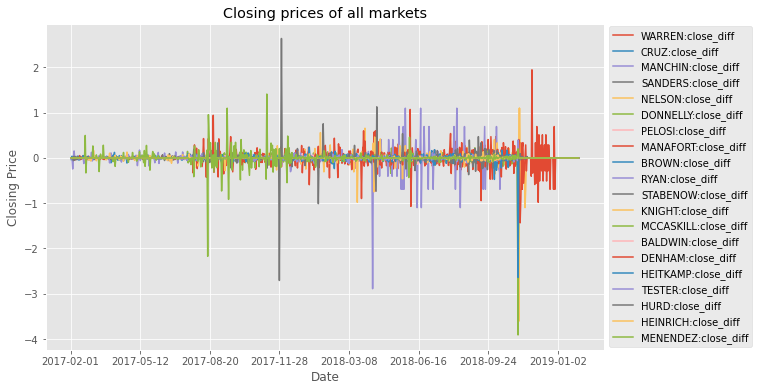

In [10]:
#Print the stationary prices.
closing_prices = feature_data.loc[:, [("close" in name) for name in feature_data.columns]]
closing_prices.plot(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing prices of all markets")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

In [11]:
#Replace all inf and -inf (which are in the trend_cci column) with Nan
import numpy as np
feature_data = feature_data.replace([np.inf, -np.inf, np.nan], 0)

In [12]:
#Normalize the technical features
features_to_norm = ["volume", "trend_cci", "momentum_rsi"]
cols_to_norm = [name for name in feature_data.columns if any(word in name for word in features_to_norm) ]
#feature_data[cols_to_norm] = feature_data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

from sklearn.preprocessing import StandardScaler
feature_data[cols_to_norm] = StandardScaler().fit_transform(feature_data[cols_to_norm])

#Fill any Nan in trend CCI with zeroes. (Do this AFTER normalization)
feature_data.loc[:, [("trend_cci" in name) for name in feature_data.columns]] = feature_data.loc[:, [("trend_cci" in name) for name in feature_data.columns]].fillna(value=0)


feature_data.head()

,WARREN:close_diff,CRUZ:close_diff,MANCHIN:close_diff,SANDERS:close_diff,NELSON:close_diff,DONNELLY:close_diff,PELOSI:close_diff,MANAFORT:close_diff,BROWN:close_diff,RYAN:close_diff,...,HURD:trend_cci_diff,HURD:momentum_rsi_diff,HEINRICH:volume_diff,HEINRICH:sentiment_diff,HEINRICH:trend_cci_diff,HEINRICH:momentum_rsi_diff,MENENDEZ:volume_diff,MENENDEZ:sentiment_diff,MENENDEZ:trend_cci_diff,MENENDEZ:momentum_rsi_diff
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,0.00000,-0.011833,0.005665,0.0,0.000000,-0.002344,0.005679
2017-02-02,-0.012579,-0.03774,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,0.18374,-0.011833,0.005665,0.0,-0.069845,-0.002344,0.005679
2017-02-03,-0.012739,0.03774,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,-0.39322,-0.011833,0.005665,0.0,0.044986,-0.002344,0.005679
2017-02-04,0.012739,0.00000,-0.245122,0.011696,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,-0.02072,-0.011833,0.005665,0.0,-0.011211,-0.002344,0.005679
2017-02-05,0.012579,0.00000,0.000000,-0.059898,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,0.09651,-0.011833,0.005665,0.0,0.013943,-0.002344,0.005679


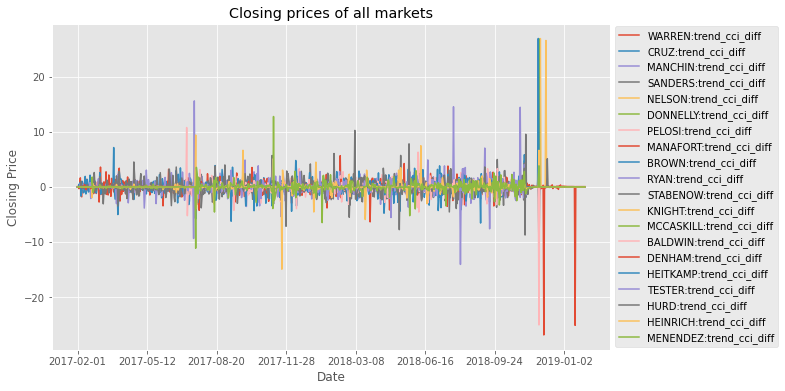

In [13]:
#Plot again
to_plot = feature_data.loc[:, [("cci" in name) for name in feature_data.columns]]
to_plot.plot(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing prices of all markets")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

## Split into train and test data

In [14]:
train_data = feature_data[(pd.to_datetime(feature_data.index)>= '02-01-2017') & (pd.to_datetime(feature_data.index) <= '08-01-2018')]
train_data.head(3)

,WARREN:close_diff,CRUZ:close_diff,MANCHIN:close_diff,SANDERS:close_diff,NELSON:close_diff,DONNELLY:close_diff,PELOSI:close_diff,MANAFORT:close_diff,BROWN:close_diff,RYAN:close_diff,...,HURD:trend_cci_diff,HURD:momentum_rsi_diff,HEINRICH:volume_diff,HEINRICH:sentiment_diff,HEINRICH:trend_cci_diff,HEINRICH:momentum_rsi_diff,MENENDEZ:volume_diff,MENENDEZ:sentiment_diff,MENENDEZ:trend_cci_diff,MENENDEZ:momentum_rsi_diff
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,0.00000,-0.011833,0.005665,0.0,0.000000,-0.002344,0.005679
2017-02-02,-0.012579,-0.03774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,0.18374,-0.011833,0.005665,0.0,-0.069845,-0.002344,0.005679
2017-02-03,-0.012739,0.03774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,-0.39322,-0.011833,0.005665,0.0,0.044986,-0.002344,0.005679


In [15]:
test_data = feature_data[(pd.to_datetime(feature_data.index) >= '08-02-2018') & (pd.to_datetime(feature_data.index) <= '11-01-2018')]
test_data.head(3)

,WARREN:close_diff,CRUZ:close_diff,MANCHIN:close_diff,SANDERS:close_diff,NELSON:close_diff,DONNELLY:close_diff,PELOSI:close_diff,MANAFORT:close_diff,BROWN:close_diff,RYAN:close_diff,...,HURD:trend_cci_diff,HURD:momentum_rsi_diff,HEINRICH:volume_diff,HEINRICH:sentiment_diff,HEINRICH:trend_cci_diff,HEINRICH:momentum_rsi_diff,MENENDEZ:volume_diff,MENENDEZ:sentiment_diff,MENENDEZ:trend_cci_diff,MENENDEZ:momentum_rsi_diff
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-02,0.000000,-0.028171,0.012579,0.0,-0.019048,0.108214,-0.01105,-0.344840,0.000000,0.0,...,0.608340,0.007581,0.0,0.13148,0.410237,0.005665,0.023595,0.27210,-0.674715,-0.623374
2018-08-03,0.010471,0.014185,-0.012579,0.0,0.000000,0.000000,0.00000,0.211309,0.000000,0.0,...,0.278707,-1.001663,0.0,0.11967,0.268253,0.005665,0.009295,-0.29159,-0.310229,0.005679
2018-08-04,-0.021053,0.013986,-0.038715,0.0,-0.039221,0.025318,0.00000,0.000000,0.011834,0.0,...,0.655166,0.007581,0.0,-0.38118,0.186140,0.005665,-0.049097,-0.05636,1.377321,1.035362


## Now make the "External Data Feed" objects
Now we take the features dataframe we just created, and convert it into an "External Data Feed" that can be plugged into the TensorTrade environment.

In [16]:
#Add "Streams" for all my external added features.
from tensortrade.data import DataFeed, Module

#Do it for train set
with Module("predictit") as train_predictit_ns:
    train_predictit_nodes = [Stream(name, list(train_data[name])) for name in train_data.columns]
    
#Now do it for test set
with Module("predictit") as test_predictit_ns:
    test_predictit_nodes = [Stream(name, list(test_data[name])) for name in test_data.columns]

In [17]:
#Then create the train Feed from it
train_external_feed = DataFeed([train_predictit_ns])
test_external_feed = DataFeed([test_predictit_ns])
train_external_feed.next()

{'predictit:/WARREN:close_diff': 0.0,
 'predictit:/CRUZ:close_diff': 0.0,
 'predictit:/MANCHIN:close_diff': 0.0,
 'predictit:/SANDERS:close_diff': 0.0,
 'predictit:/NELSON:close_diff': 0.0,
 'predictit:/DONNELLY:close_diff': 0.0,
 'predictit:/PELOSI:close_diff': 0.0,
 'predictit:/MANAFORT:close_diff': 0.0,
 'predictit:/BROWN:close_diff': 0.0,
 'predictit:/RYAN:close_diff': 0.0,
 'predictit:/STABENOW:close_diff': 0.0,
 'predictit:/KNIGHT:close_diff': 0.0,
 'predictit:/MCCASKILL:close_diff': 0.0,
 'predictit:/BALDWIN:close_diff': 0.0,
 'predictit:/DENHAM:close_diff': 0.0,
 'predictit:/HEITKAMP:close_diff': 0.0,
 'predictit:/TESTER:close_diff': 0.0,
 'predictit:/HURD:close_diff': 0.0,
 'predictit:/HEINRICH:close_diff': 0.0,
 'predictit:/MENENDEZ:close_diff': 0.0,
 'predictit:/WARREN:volume_diff': 0.0007819890389761158,
 'predictit:/WARREN:sentiment_diff': 0.0,
 'predictit:/WARREN:trend_cci_diff': -0.0048507814974368055,
 'predictit:/WARREN:momentum_rsi_diff': 0.006612971143076447,
 'predi

# Training
Now that data has been fetched, features have been engineered and normalized, and the environment has been set up, we can begin the training process. We will use the Ray package for training.

## First Launch Ray. 
This is where you define our training "Trading Enviroment," which includes things such as the action scheme, the reward scheme, the window size, and whether or not to use the "interal feed" (internal data feed has all the price data from the wallets and the networth of the portfolio).

In [18]:
#Add the deeptrader path to ALL workers, not just the current worker
import os
parent_dir = os.path.realpath("..")
os.environ["PYTHONPATH"] = parent_dir + ":" + os.environ.get("PYTHONPATH", "")

In [19]:
#Try and get rid of that yaml warning (although this only does it for THIS worker)
import yaml
yaml.warnings({'YAMLLoadWarning': False})

In [20]:
# Environment
from tensortrade.environments import TradingEnvironment


import gym
import ray
from ray import tune
from ray.tune import grid_search
from ray.tune.registry import register_env

import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print
from tensortrade.rewards import RiskAdjustedReturns
    
class RayTradingEnv(TradingEnvironment):
    def __init__(self):        
        env = TradingEnvironment(
            feed=train_external_feed,
            portfolio=portfolio,
            action_scheme="simple",
            reward_scheme="diversified",
            window_size=15,
            enable_logger=False,
            renderers = 'screenlog',
            use_internal = False,
        ) 
        self.env = env
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        
        

    def reset(self):
        return self.env.reset()

    def step(self, action):
        return self.env.step(action)

def env_creator(env_config):
    return RayTradingEnv()

register_env("ray_trading_env", env_creator)


#ray.init(ignore_reinit_error=True, local_mode=True)

## Train using Tune
Now that Ray has been initialized properly with our custom environment, we can begin training using tune. We first define a custom neural network model, and define Population Based Training for hyperparameter tuning.

In [21]:
#Implement Custom neural network model
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.agents.dqn.distributional_q_model import DistributionalQModel
from ray.rllib.utils import try_import_tf

from ray.rllib.models.tf.fcnet_v2 import FullyConnectedNetwork

from gym.spaces import Box

tf = try_import_tf()

class CNNModel(DistributionalQModel, TFModelV2):
    """Custom model for DQN."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name, **kw):
        super(CNNModel, self).__init__(
            obs_space, action_space, num_outputs, model_config, name, **kw)

        # Define neural net layers
        self.base_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(15, 121)),
            tf.keras.layers.Conv1D(filters=40, kernel_size=6, padding="same", activation="relu"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(filters=20, kernel_size=3, padding="same", activation="relu"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_outputs)
        ])
        
        self.register_variables(self.base_model.variables)

    # Implement the core forward method
    def forward(self, input_dict, state, seq_lens):
        model_out = self.base_model(input_dict["obs"]["real_obs"])
        
        action_mask = input_dict["obs"]["action_mask"]
        inf_mask = tf.maximum(tf.log(action_mask), tf.float32.min)
        
        
        return model_out + inf_mask, state

    
ModelCatalog.register_custom_model("cnn_model", CNNModel)

In [22]:
# Population based training
from ray.tune.schedulers import PopulationBasedTraining
import random

pbt = PopulationBasedTraining(
    time_attr="time_total_s",
    metric="episode_reward_mean",
    mode="max",
    perturbation_interval=240, #Every 10,000 steps, consider changing learning rate
    hyperparam_mutations={
        "lr": lambda: random.uniform(.0001, .02),
        #"epsilon_timesteps": lambda: random.uniform(10000, 100000)
        #"train_batch_size": lambda: random.uniform(10, 1000),
    } 
)

In [ ]:
analysis = tune.run(
        "DQN",
        name = "DQN59-pbt",
        scheduler=pbt, #Use Population Based Training
        num_samples=3, #Number of different hyperparameters to sample
        #reuse_actors=True,
        #restore = "/home/accts/jcf73/ray_results/DQN57-actions_mask/DQN_ray_trading_env_cbfaadba_0_2020-04-20_13-53-090zljysq7/checkpoint_250/checkpoint-250",
        checkpoint_freq = 10,
        checkpoint_at_end=True,
        stop={
            "timesteps_total": 10000000,
        },
        config={
            "env": "ray_trading_env",
            "lr": .0001,  # try different lrs
            "num_workers": 5,  # parallelism,
            #"num_gpus": 1,
            #"eager": "true",
            "model": {
                "custom_model": "cnn_model"
            },
            "exploration_config": {
                "initial_epsilon": 0.75,
                "epsilon_timesteps": 3000000,
                
            },
            "train_batch_size": 100,
            #"clip_rewards": True,
            #"grad_norm_clipping": None,
            "target_network_update_freq": 15000,
            "dueling": False,
            "hiddens": [],
        },
        
    )

2020-04-27 20:54:53,305	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-27 20:54:53,307	INFO resource_spec.py:212 -- Starting Ray with 36.72 GiB memory available for workers and up to 18.37 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-27 20:54:55,290	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


Trial name,status,loc
DQN_ray_trading_env_e0a8d780,RUNNING,
DQN_ray_trading_env_e0a92ff0,PENDING,
DQN_ray_trading_env_e0a96f92,PENDING,


(pid=24198) 2020-04-27 20:55:27,677	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=24183) 2020-04-27 20:55:27,677	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=24193) 2020-04-27 20:55:27,677	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=24198) 2020-04-27 20:55:38,475	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=24183) 2020-04-27 20:55:38,475	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=24193) 2020-04-27 20:55:38,475	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=24198) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/

(pid=24196) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
(pid=24196)   ret = umr_sum(arr, axis, dtype, out, keepdims)
(pid=24192) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
(pid=24192)   ret = umr_sum(arr, axis, dtype, out, keepdims)
(pid=24191) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
(pid=24191)   ret = umr_sum(arr, axis, dtype, out, keepdims)


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_20-57-08
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 877fe6e6c8c341bdb9e475d9bc322155
  experiment_tag: '1'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: .nan
    learner: {}
    num_steps_sampled: 1000
    num_steps_trained: 0
    num_target_updates: 0
    opt_peak_throughput: 0.0
    opt_samples: .nan
    replay_time_ms: .nan
    sample_time_ms: 1063.098
    update_time_ms: 4.16
  iterations_since_restore: 1
  node_ip: 128.36.232.45
  num_healthy_workers: 5
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 45.215873015873015
    ram_util_percent: 14.645238095238101
  pid: 24183
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sample

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,,,,,
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24183,nan,88.1871,1000,1
DQN_ray_trading_env_e0a96f92,RUNNING,,,,,


Result for DQN_ray_trading_env_e0a8d780:
(pid=24193) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.  custom_metrics: {}
  date: 2020-04-27_20-57-08
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 8e2eba29b2f240d8844804e9cc5b907f
  experiment_tag: '0'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: .nan
    learner: {}
    num_steps_sampled: 1000
    num_steps_trained: 0
    num_target_updates: 0
    opt_peak_throughput: 0.0
    opt_samples: .nan
    replay_time_ms: .nan
    sample_time_ms: 896.798
    update_time_ms: 3.933
  iterations_since_restore: 1
  node_ip: 128.36.232.45
  num_healthy_workers: 5
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 45.2496062992126

Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_20-57-09
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: .nan
    learner: {}
    num_steps_sampled: 1000
    num_steps_trained: 0
    num_target_updates: 0
    opt_peak_throughput: 0.0
    opt_samples: .nan
    replay_time_ms: .nan
    sample_time_ms: 891.408
    update_time_ms: 4.187
  iterations_since_restore: 1
  node_ip: 128.36.232.45
  num_healthy_workers: 5
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 45.4328125
    ram_util_percent: 14.6640625
  pid: 24198
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf: {}
  tim

Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_20-57-52
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 8e2eba29b2f240d8844804e9cc5b907f
  experiment_tag: '0'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 17.199
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.8578372001647949
        mean_q: 0.13723105192184448
        mean_td_error: 0.05539683252573013
        min_q: -0.599052369594574
        model: {}
    num_steps_sampled: 2000
    num_steps_trained: 5000
    num_target_updates: 0
    opt_peak_throughput: 5814.27
    opt_samples: 100.0
    replay_time_ms: 15.954
    sample_time_ms: 861.846
    update_time_ms: 4.351
  iterations_since_restore: 2
  node_ip: 128.36.232.45
  

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,nan,132.295,2000,2
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24183,nan,88.1871,1000,1
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,nan,89.4087,1000,1


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_20-57-55
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 877fe6e6c8c341bdb9e475d9bc322155
  experiment_tag: '1'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 17.051
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.8888055682182312
        mean_q: 0.1615164875984192
        mean_td_error: 0.3184208571910858
        min_q: -0.48750370740890503
        model: {}
    num_steps_sampled: 2000
    num_steps_trained: 5000
    num_target_updates: 0
    opt_peak_throughput: 5864.896
    opt_samples: 100.0
    replay_time_ms: 17.129
    sample_time_ms: 828.118
    update_time_ms: 4.211
  iterations_since_restore: 2
  node_ip: 128.36.232.45
 

Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_20-57-56
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 16.464
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 1.693464994430542
        mean_q: 0.3091515004634857
        mean_td_error: 0.37114226818084717
        min_q: -0.592860221862793
        model: {}
    num_steps_sampled: 2000
    num_steps_trained: 5000
    num_target_updates: 0
    opt_peak_throughput: 6073.754
    opt_samples: 100.0
    replay_time_ms: 16.853
    sample_time_ms: 989.843
    update_time_ms: 4.342
  iterations_since_restore: 2
  node_ip: 128.36.232.45
  n

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00991539,183.27,3000,3
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24183,nan,134.731,2000,2
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,nan,135.695,2000,2


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_20-58-49
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0003868198734156243
  episode_reward_mean: -0.010657933344982677
  episode_reward_min: -0.038241869909020745
  episodes_this_iter: 5
  episodes_total: 5
  experiment_id: 877fe6e6c8c341bdb9e475d9bc322155
  experiment_tag: '1'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7497566938400269
    - 0.7497566938400269
    - 0.7497566938400269
    - 0.7497566938400269
    - 0.7497566938400269
    grad_time_ms: 19.882
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.5528619289398193
        mean_q: 0.08807193487882614
        mean_td_error: 0.12201948463916779
        min_q: -0.34895434975624084
        model: {}
    num_steps_sampled: 3000
    num_steps_trained: 10000
    num_target_updates: 0
    opt_peak_throughput: 5029.714
    opt_samples: 100.0
    replay_t

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00991539,183.27,3000,3
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24183,-0.0106579,188.709,3000,3
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,nan,135.695,2000,2


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_20-58-51
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0018566462814940733
  episode_reward_mean: -0.003578567460204474
  episode_reward_min: -0.005810007865996659
  episodes_this_iter: 5
  episodes_total: 5
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7497566938400269
    - 0.7497566938400269
    - 0.7497566938400269
    - 0.7497566938400269
    - 0.7497566938400269
    grad_time_ms: 17.958
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 1.0084210634231567
        mean_q: 0.22250564396381378
        mean_td_error: 0.19291932880878448
        min_q: -0.8245134949684143
        model: {}
    num_steps_sampled: 3000
    num_steps_trained: 10000
    num_target_updates: 0
    opt_peak_throughput: 5568.505
    opt_samples: 100.0
    replay_t

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00991539,233.271,4000,4
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24183,-0.0106579,188.709,3000,3
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00357857,191.362,3000,3


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_20-59-34
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0003868198734156243
  episode_reward_mean: -0.010657933344982677
  episode_reward_min: -0.038241869909020745
  episodes_this_iter: 0
  episodes_total: 5
  experiment_id: 877fe6e6c8c341bdb9e475d9bc322155
  experiment_tag: '1'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7495133280754089
    - 0.7495133280754089
    - 0.7495133280754089
    - 0.7495133280754089
    - 0.7495133280754089
    grad_time_ms: 17.694
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.4045798182487488
        mean_q: 0.05451628565788269
        mean_td_error: 0.09232427924871445
        min_q: -0.2880103588104248
        model: {}
    num_steps_sampled: 4000
    num_steps_trained: 15000
    num_target_updates: 0
    opt_peak_throughput: 5651.596
    opt_samples: 100.0
    replay_ti

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00991539,277.534,5000,5
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24183,-0.0106579,234.128,4000,4
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00357857,237.326,4000,4


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-00-22
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0018566462814940733
  episode_reward_mean: -0.003578567460204474
  episode_reward_min: -0.005810007865996659
  episodes_this_iter: 0
  episodes_total: 5
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7492700219154358
    - 0.7492700219154358
    - 0.7492700219154358
    - 0.7492700219154358
    - 0.7492700219154358
    grad_time_ms: 17.53
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.8273917436599731
        mean_q: 0.09738345444202423
        mean_td_error: 0.10531453043222427
        min_q: -0.7727901339530945
        model: {}
    num_steps_sampled: 5000
    num_steps_trained: 20000
    num_target_updates: 0
    opt_peak_throughput: 5704.394
    opt_samples: 100.0
    replay_ti

2020-04-27 21:00:22,755	INFO pbt.py:79 -- [explore] perturbed config from {'env': 'ray_trading_env', 'lr': 0.0001, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []} -> {'env': 'ray_trading_env', 'lr': 0.017384665713819896, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []}
2020-04-27 21:00:22,756	INFO pbt.py:316 -- [exploit] transferring weights from trial DQN_ray_trading_env_e0a96f92 (score -0.003578567460204474) -> DQN_ray_trading_env_e0a92ff0 (score -0.010657933344982677)


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-00-22
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0003868198734156243
  episode_reward_mean: -0.010657933344982677
  episode_reward_min: -0.038241869909020745
  episodes_this_iter: 0
  episodes_total: 5
  experiment_id: 877fe6e6c8c341bdb9e475d9bc322155
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7492700219154358
    - 0.7492700219154358
    - 0.7492700219154358
    - 0.7492700219154358
    - 0.7492700219154358
    grad_time_ms: 16.408
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.6103684902191162
        mean_q: 0.09798066318035126
        mean_td_error: 0.0810905173420906
        min_q: -0.24248619377613068
        model: {}
    num_steps_sampled: 5000
    num_steps_trained: 20000
    num_target_updates: 0
    opt_peak_throughput: 6094.742
    opt_samples

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00889414,336.986,6000,6
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24183,-0.0106579,282.339,5000,5
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00357857,281.716,5000,5


(pid=24181) 2020-04-27 21:01:22,639	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=24181) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=24181)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-01-22
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0011348045188300329
  episode_reward_mean: -0.002583842398173334
  episode_reward_min: -0.005810007865996659
  episodes_this_iter: 5
  episodes_total: 10
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7490266561508179
    - 0.7490266561508179
    - 0.7490266561508179
    - 0.7490266561508179
    - 0.7490266561508179
    grad

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00889414,336.986,6000,6
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24183,-0.0106579,282.339,5000,5
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00258384,342.325,6000,6


(pid=24181) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=24181)   obj = yaml.load(type_)
(pid=24181) 2020-04-27 21:01:23,895	INFO trainable.py:178 -- _setup took 18.206 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=24181) 2020-04-27 21:01:23,895	WARNING util.py:37 -- Install gputil for GPU system monitoring.
(pid=24181) 2020-04-27 21:01:24,116	WARNING trainable.py:210 -- Getting current IP.
(pid=24181) 2020-04-27 21:01:24,116	INFO trainable.py:416 -- Restored on 128.36.232.45 from checkpoint: /home/accts/jcf73/ray_results/DQN59-pbt/DQN_ray_trading_env_e0a92ff0_1_2020-04-27_20-54-56m8dbto5g/tmpksfyjl24restore_from_object/checkpoint-5
(pid=24181) 2020-04-27 21:01:24,116	INFO trainable.py:423 -- Cu

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00889414,371.977,7000,7
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24183,-0.0106579,282.339,5000,5
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00258384,342.325,6000,6


(pid=24180) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=24180)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=24294) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=24294)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=24194) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=24194)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=24180) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=24180)   obj = yaml

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00889414,371.977,7000,7
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24183,-0.0106579,282.339,5000,5
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00258384,378.244,7000,7


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-02-38
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00044883979214892824
  episode_reward_mean: -0.008894136478444835
  episode_reward_min: -0.026723026203369644
  episodes_this_iter: 0
  episodes_total: 10
  experiment_id: 8e2eba29b2f240d8844804e9cc5b907f
  experiment_tag: '0'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7485399842262268
    - 0.7485399842262268
    - 0.7485399842262268
    - 0.7485399842262268
    - 0.7485399842262268
    grad_time_ms: 16.544
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.45910659432411194
        mean_q: 0.04405435174703598
        mean_td_error: 0.08122280240058899
        min_q: -0.28073224425315857
        model: {}
    num_steps_sampled: 8000
    num_steps_trained: 35000
    num_target_updates: 0
    opt_peak_throughput: 6044.641
    opt_samples: 100.0
    repla

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00889414,418.374,8000,8
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24183,-0.0106579,282.339,5000,5
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00258384,378.244,7000,7


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-02-41
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0011348045188300329
  episode_reward_mean: -0.0025838423981733344
  episode_reward_min: -0.005810007865996659
  episodes_this_iter: 0
  episodes_total: 10
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7485399842262268
    - 0.7485399842262268
    - 0.7485399842262268
    - 0.7485399842262268
    - 0.7485399842262268
    grad_time_ms: 16.327
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.541712760925293
        mean_q: 0.05661626160144806
        mean_td_error: 0.23896686732769012
        min_q: -0.27741584181785583
        model: {}
    num_steps_sampled: 8000
    num_steps_trained: 35000
    num_target_updates: 0
    opt_peak_throughput: 6125.003
    opt_samples: 100.0
    replay

Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-02-51
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 5
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 16.278
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.287924587726593
        mean_q: 0.09315592795610428
        mean_td_error: 0.1439926028251648
        min_q: -0.1794348955154419
        model: {}
    num_steps_sampled: 6000
    num_steps_trained: 25000
    num_target_updates: 0
    opt_peak_throughput: 6143.313
    opt_samples: 100.0
    replay_time_ms: 16.916
    sample_time_ms: 926.225
    update_time_ms: 4.11
  iterations_since_restore: 1
  node_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00889414,418.374,8000,8
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,nan,368.801,6000,6
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00258384,421.112,8000,8


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-03-27
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00044883979214892824
  episode_reward_mean: -0.010948273910194439
  episode_reward_min: -0.037023550816988035
  episodes_this_iter: 5
  episodes_total: 15
  experiment_id: 8e2eba29b2f240d8844804e9cc5b907f
  experiment_tag: '0'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7482966780662537
    - 0.7482966780662537
    - 0.7482966780662537
    - 0.7482966780662537
    - 0.7482966780662537
    grad_time_ms: 17.534
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.39242345094680786
        mean_q: 0.03462420403957367
        mean_td_error: 0.0793149396777153
        min_q: -0.18399043381214142
        model: {}
    num_steps_sampled: 9000
    num_steps_trained: 40000
    num_target_updates: 0
    opt_peak_throughput: 5703.13
    opt_samples: 100.0
    replay_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.0109483,467.335,9000,9
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,nan,368.801,6000,6
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00258384,421.112,8000,8


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-03-28
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0007695010655704119
  episode_reward_mean: -0.0032639054296459157
  episode_reward_min: -0.01574104945723599
  episodes_this_iter: 5
  episodes_total: 15
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7482966780662537
    - 0.7482966780662537
    - 0.7482966780662537
    - 0.7482966780662537
    - 0.7482966780662537
    grad_time_ms: 16.199
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.4735100269317627
        mean_q: 0.06590361893177032
        mean_td_error: 0.20567108690738678
        min_q: -0.18468309938907623
        model: {}
    num_steps_sampled: 9000
    num_steps_trained: 40000
    num_target_updates: 0
    opt_peak_throughput: 6173.205
    opt_samples: 100.0
    replay

Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-03-35
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 5
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7487833499908447
    - 0.7487833499908447
    - 0.7487833499908447
    - 0.7487833499908447
    - 0.7487833499908447
    grad_time_ms: 19.237
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.25518444180488586
        mean_q: 0.041760873049497604
        mean_td_error: -0.2419125884771347
        min_q: -0.35591253638267517
        model: {}
    num_steps_sampled: 7000
    num_steps_trained: 30000
    num_target_updates: 0
    opt_peak_throughput: 5198.311
    opt_samples: 100.0
    replay_time_ms: 21.304
    sample_time

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.0109483,467.335,9000,9
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,nan,412.643,7000,7
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00326391,467.958,9000,9


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-04-09
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0007695010655704119
  episode_reward_mean: -0.003263905429645916
  episode_reward_min: -0.01574104945723599
  episodes_this_iter: 0
  episodes_total: 15
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7480533123016357
    - 0.7480533123016357
    - 0.7480533123016357
    - 0.7480533123016357
    - 0.7480533123016357
    grad_time_ms: 17.856
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.4074608087539673
        mean_q: 0.05122465267777443
        mean_td_error: 0.0709918886423111
        min_q: -0.3787744641304016
        model: {}
    num_steps_sampled: 10000
    num_steps_trained: 45000
    num_target_updates: 0
    opt_peak_throughput: 5600.238
    opt_samples: 100.0
    replay_t

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.0109483,467.335,9000,9
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,nan,412.643,7000,7
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00326391,508.689,10000,10


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-04-11
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00044883979214892824
  episode_reward_mean: -0.010948273910194437
  episode_reward_min: -0.037023550816988035
  episodes_this_iter: 0
  episodes_total: 15
  experiment_id: 8e2eba29b2f240d8844804e9cc5b907f
  experiment_tag: '0'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7480533123016357
    - 0.7480533123016357
    - 0.7480533123016357
    - 0.7480533123016357
    - 0.7480533123016357
    grad_time_ms: 20.904
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.3319109380245209
        mean_q: 0.03819749504327774
        mean_td_error: 0.06881678849458694
        min_q: -0.28180307149887085
        model: {}
    num_steps_sampled: 10000
    num_steps_trained: 45000
    num_target_updates: 0
    opt_peak_throughput: 4783.879
    opt_samples: 100.0
    repla

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.0109483,510.816,10000,10
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00880141,464.732,8000,8
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00326391,508.689,10000,10


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-04-57
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.003928404045970056
  episode_reward_min: -0.021747380740324656
  episodes_this_iter: 5
  episodes_total: 20
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7478100061416626
    - 0.7478100061416626
    - 0.7478100061416626
    - 0.7478100061416626
    - 0.7478100061416626
    grad_time_ms: 20.479
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.3738536238670349
        mean_q: 0.05346306413412094
        mean_td_error: 0.029782602563500404
        min_q: -0.21020817756652832
        model: {}
    num_steps_sampled: 11000
    num_steps_trained: 50000
    num_target_updates: 0
    opt_peak_throughput: 4883.156
    opt_samples: 100.0
    repla

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.0109483,510.816,10000,10
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00880141,464.732,8000,8
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0039284,556.635,11000,11


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-04-58
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0021231597152350404
  episode_reward_mean: -0.008848486155668685
  episode_reward_min: -0.037023550816988035
  episodes_this_iter: 5
  episodes_total: 20
  experiment_id: 8e2eba29b2f240d8844804e9cc5b907f
  experiment_tag: '0'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7478100061416626
    - 0.7478100061416626
    - 0.7478100061416626
    - 0.7478100061416626
    - 0.7478100061416626
    grad_time_ms: 20.264
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.34188058972358704
        mean_q: 0.023192808032035828
        mean_td_error: -0.041404008865356445
        min_q: -0.30150046944618225
        model: {}
    num_steps_sampled: 11000
    num_steps_trained: 50000
    num_target_updates: 0
    opt_peak_throughput: 4934.789
    opt_samples: 100.0
    re

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884849,557.448,11000,11
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00880141,512.79,9000,9
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0039284,556.635,11000,11


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-05-42
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.003928404045970056
  episode_reward_min: -0.021747380740324656
  episodes_this_iter: 0
  episodes_total: 20
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7475666403770447
    - 0.7475666403770447
    - 0.7475666403770447
    - 0.7475666403770447
    - 0.7475666403770447
    grad_time_ms: 16.757
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.42305871844291687
        mean_q: 0.04345251992344856
        mean_td_error: 0.03872019797563553
        min_q: -0.20743051171302795
        model: {}
    num_steps_sampled: 12000
    num_steps_trained: 55000
    num_target_updates: 0
    opt_peak_throughput: 5967.481
    opt_samples: 100.0
    repla

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884849,557.448,11000,11
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00880141,512.79,9000,9
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0039284,600.785,12000,12


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-05-47
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0021231597152350404
  episode_reward_mean: -0.008848486155668685
  episode_reward_min: -0.037023550816988035
  episodes_this_iter: 0
  episodes_total: 20
  experiment_id: 8e2eba29b2f240d8844804e9cc5b907f
  experiment_tag: '0'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7475666403770447
    - 0.7475666403770447
    - 0.7475666403770447
    - 0.7475666403770447
    - 0.7475666403770447
    grad_time_ms: 16.758
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.4878388047218323
        mean_q: 0.0482943058013916
        mean_td_error: 0.08014306426048279
        min_q: -0.12761840224266052
        model: {}
    num_steps_sampled: 12000
    num_steps_trained: 55000
    num_target_updates: 0
    opt_peak_throughput: 5967.193
    opt_samples: 100.0
    replay_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884849,606.821,12000,12
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00880141,512.79,9000,9
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0039284,600.785,12000,12


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-05-59
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0016077862507979234
  episode_reward_mean: -0.008801410211109414
  episode_reward_min: -0.03404509062909905
  episodes_this_iter: 0
  episodes_total: 10
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7480533123016357
    - 0.7480533123016357
    - 0.7480533123016357
    - 0.7480533123016357
    - 0.7480533123016357
    grad_time_ms: 16.124
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.41002926230430603
        mean_q: 0.1838056445121765
        mean_td_error: 0.2415877878665924
        min_q: -0.07998079061508179
        model: {}
    num_steps_sampled: 10000
    num_steps_trained: 45000
    num_target_updates: 0
    opt_peak_throughput: 6202.124
    opt_sample

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884849,606.821,12000,12
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00880141,557.096,10000,10
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0039284,600.785,12000,12


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-06-23
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.003928404045970056
  episode_reward_min: -0.021747380740324656
  episodes_this_iter: 0
  episodes_total: 20
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7473233342170715
    - 0.7473233342170715
    - 0.7473233342170715
    - 0.7473233342170715
    - 0.7473233342170715
    grad_time_ms: 19.294
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.34027260541915894
        mean_q: 0.05127681791782379
        mean_td_error: 0.12006227672100067
        min_q: -0.19693146646022797
        model: {}
    num_steps_sampled: 13000
    num_steps_trained: 60000
    num_target_updates: 0
    opt_peak_throughput: 5182.888
    opt_samples: 100.0
    repla

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884849,606.821,12000,12
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00880141,557.096,10000,10
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0039284,642.336,13000,13


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-06-32
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0021231597152350404
  episode_reward_mean: -0.008848486155668685
  episode_reward_min: -0.037023550816988035
  episodes_this_iter: 0
  episodes_total: 20
  experiment_id: 8e2eba29b2f240d8844804e9cc5b907f
  experiment_tag: '0'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7473233342170715
    - 0.7473233342170715
    - 0.7473233342170715
    - 0.7473233342170715
    - 0.7473233342170715
    grad_time_ms: 15.48
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.23474200069904327
        mean_q: 0.02681863121688366
        mean_td_error: -0.10355708748102188
        min_q: -0.17416135966777802
        model: {}
    num_steps_sampled: 13000
    num_steps_trained: 60000
    num_target_updates: 0
    opt_peak_throughput: 6459.891
    opt_samples: 100.0
    repla

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884849,652.07,13000,13
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00880141,557.096,10000,10
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0039284,642.336,13000,13


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-06-52
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0008975096785839747
  episode_reward_mean: -0.008980451070779624
  episode_reward_min: -0.03404509062909905
  episodes_this_iter: 5
  episodes_total: 15
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7478100061416626
    - 0.7478100061416626
    - 0.7478100061416626
    - 0.7478100061416626
    - 0.7478100061416626
    grad_time_ms: 16.089
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.22385480999946594
        mean_q: 0.021716849878430367
        mean_td_error: -0.3691096603870392
        min_q: -0.22985710203647614
        model: {}
    num_steps_sampled: 11000
    num_steps_trained: 50000
    num_target_updates: 0
    opt_peak_throughput: 6215.46
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884849,652.07,13000,13
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00898045,609.461,11000,11
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0039284,642.336,13000,13


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-07-17
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.004525898747684662
  episode_reward_min: -0.03277076829299211
  episodes_this_iter: 5
  episodes_total: 25
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7470800280570984
    - 0.7470800280570984
    - 0.7470800280570984
    - 0.7470800280570984
    - 0.7470800280570984
    grad_time_ms: 19.111
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.24496079981327057
        mean_q: 0.027110951021313667
        mean_td_error: -0.0219145305454731
        min_q: -0.20344065129756927
        model: {}
    num_steps_sampled: 14000
    num_steps_trained: 65000
    num_target_updates: 0
    opt_peak_throughput: 5232.598
    opt_samples: 100.0
    repla

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884849,652.07,13000,13
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00898045,609.461,11000,11
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0045259,696.444,14000,14


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-07-28
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0021231597152350404
  episode_reward_mean: -0.008849920307518582
  episode_reward_min: -0.037023550816988035
  episodes_this_iter: 5
  episodes_total: 25
  experiment_id: 8e2eba29b2f240d8844804e9cc5b907f
  experiment_tag: '0'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7470800280570984
    - 0.7470800280570984
    - 0.7470800280570984
    - 0.7470800280570984
    - 0.7470800280570984
    grad_time_ms: 15.99
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.30705180764198303
        mean_q: 0.014929553493857384
        mean_td_error: 0.006779002957046032
        min_q: -0.354006826877594
        model: {}
    num_steps_sampled: 14000
    num_steps_trained: 65000
    num_target_updates: 0
    opt_peak_throughput: 6253.957
    opt_samples: 100.0
    replay

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884992,707.491,14000,14
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00898045,609.461,11000,11
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0045259,696.444,14000,14


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-07-39
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0008975096785839747
  episode_reward_mean: -0.008980451070779622
  episode_reward_min: -0.03404509062909905
  episodes_this_iter: 0
  episodes_total: 15
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7475666403770447
    - 0.7475666403770447
    - 0.7475666403770447
    - 0.7475666403770447
    - 0.7475666403770447
    grad_time_ms: 15.164
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.3710959851741791
        mean_q: 0.15383657813072205
        mean_td_error: 0.06815210729837418
        min_q: -0.10675352066755295
        model: {}
    num_steps_sampled: 12000
    num_steps_trained: 55000
    num_target_updates: 0
    opt_peak_throughput: 6594.776
    opt_sampl

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884992,707.491,14000,14
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00898045,656.537,12000,12
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0045259,696.444,14000,14


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-08-00
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.004525898747684663
  episode_reward_min: -0.03277076829299211
  episodes_this_iter: 0
  episodes_total: 25
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7468366622924805
    - 0.7468366622924805
    - 0.7468366622924805
    - 0.7468366622924805
    - 0.7468366622924805
    grad_time_ms: 16.22
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.22784487903118134
        mean_q: 0.019448159262537956
        mean_td_error: 0.0029633629601448774
        min_q: -0.16890859603881836
        model: {}
    num_steps_sampled: 15000
    num_steps_trained: 70000
    num_target_updates: 0
    opt_peak_throughput: 6165.102
    opt_samples: 100.0
    repl

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884992,707.491,14000,14
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00898045,656.537,12000,12
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0045259,738.734,15000,15


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-08-12
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0021231597152350404
  episode_reward_mean: -0.008849920307518582
  episode_reward_min: -0.037023550816988035
  episodes_this_iter: 0
  episodes_total: 25
  experiment_id: 8e2eba29b2f240d8844804e9cc5b907f
  experiment_tag: '0'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7468366622924805
    - 0.7468366622924805
    - 0.7468366622924805
    - 0.7468366622924805
    - 0.7468366622924805
    grad_time_ms: 17.345
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.2526026964187622
        mean_q: 0.03480870649218559
        mean_td_error: -0.021818989887833595
        min_q: -0.12208019196987152
        model: {}
    num_steps_sampled: 15000
    num_steps_trained: 70000
    num_target_updates: 0
    opt_peak_throughput: 5765.422
    opt_samples: 100.0
    repl

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884992,751.799,15000,15
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00898045,656.537,12000,12
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0045259,738.734,15000,15


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-08-29
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0008975096785839747
  episode_reward_mean: -0.008980451070779622
  episode_reward_min: -0.03404509062909905
  episodes_this_iter: 0
  episodes_total: 15
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7473233342170715
    - 0.7473233342170715
    - 0.7473233342170715
    - 0.7473233342170715
    - 0.7473233342170715
    grad_time_ms: 23.759
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.23104730248451233
        mean_q: 0.06915057450532913
        mean_td_error: -0.18444165587425232
        min_q: -0.11273414641618729
        model: {}
    num_steps_sampled: 13000
    num_steps_trained: 60000
    num_target_updates: 0
    opt_peak_throughput: 4208.862
    opt_sam

2020-04-27 21:08:30,230	WARNING util.py:132 -- The `experiment_checkpoint` operation took 0.8074588775634766 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884992,751.799,15000,15
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00898045,706.596,13000,13
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0045259,738.734,15000,15


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-08-54
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.004525898747684663
  episode_reward_min: -0.03277076829299211
  episodes_this_iter: 0
  episodes_total: 25
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7465933561325073
    - 0.7465933561325073
    - 0.7465933561325073
    - 0.7465933561325073
    - 0.7465933561325073
    grad_time_ms: 41.005
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.3275776207447052
        mean_q: 0.025235038250684738
        mean_td_error: -0.1547296643257141
        min_q: -0.2232467234134674
        model: {}
    num_steps_sampled: 16000
    num_steps_trained: 75000
    num_target_updates: 1
    opt_peak_throughput: 2438.699
    opt_samples: 100.0
    replay_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884992,751.799,15000,15
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.00898045,706.596,13000,13
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0045259,793.279,16000,16


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-09-32
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0006997620166874133
  episode_reward_mean: -0.007675498457805384
  episode_reward_min: -0.03404509062909905
  episodes_this_iter: 5
  episodes_total: 20
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7470800280570984
    - 0.7470800280570984
    - 0.7470800280570984
    - 0.7470800280570984
    - 0.7470800280570984
    grad_time_ms: 15.048
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.3563908338546753
        mean_q: 0.1336432695388794
        mean_td_error: -0.019395915791392326
        min_q: -0.13656647503376007
        model: {}
    num_steps_sampled: 14000
    num_steps_trained: 65000
    num_target_updates: 0
    opt_peak_throughput: 6645.337
    opt_sampl

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884992,810.538,16000,16
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0076755,769.496,14000,14
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0045259,793.279,16000,16


2020-04-27 21:09:39,788	INFO pbt.py:308 -- [pbt]: no checkpoint for trial. Skip exploit for Trial DQN_ray_trading_env_e0a96f92


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-09-39
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.009839666084133029
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 5
  episodes_total: 30
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7463499903678894
    - 0.7463499903678894
    - 0.7463499903678894
    - 0.7463499903678894
    - 0.7463499903678894
    grad_time_ms: 15.163
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.3612132668495178
        mean_q: 0.024011101573705673
        mean_td_error: -0.1566123068332672
        min_q: -0.16813844442367554
        model: {}
    num_steps_sampled: 17000
    num_steps_trained: 80000
    num_target_updates: 1
    opt_peak_throughput: 6595.129
    opt_samples: 100.0
    replay

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884992,810.538,16000,16
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0076755,769.496,14000,14
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00983967,838.332,17000,17


(pid=27974) 2020-04-27 21:09:57,550	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-10-07
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0006997620166874133
  episode_reward_mean: -0.007675498457805383
  episode_reward_min: -0.03404509062909905
  episodes_this_iter: 0
  episodes_total: 20
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7468366622924805
    - 0.7468366622924805
    - 0.7468366622924805
    - 0.7468366622924805
    - 0.7468366622924805
    grad_time_ms: 14.687
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.2393648326396942
        mean_q: 0.09762412309646606
        mean_td_error: -0.09924684464931488
        min_q: -0.08734530210494995
        mo

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884992,810.538,16000,16
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0076755,804.833,15000,15
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00983967,838.332,17000,17


(pid=27974) 2020-04-27 21:10:10,032	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=27974) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=27974)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=27974) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=27974)   obj = yaml.load(type_)
(pid=27974) 2020-04-27 21:10:11,248	INFO trainable.py:178 -- _setup took 13.693 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=27974) 2020-04-27 21:10:11,248	WARNING util.py:37 -- Install gputil for GPU system

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884992,810.538,16000,16
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0076755,804.833,15000,15
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00983967,871.426,18000,18


(pid=27954) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=27954)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=27953) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=27953)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=27953) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=27953)   obj = yaml.load(type_)
(pid=27954) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read h

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884992,810.538,16000,16
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0105438,859.748,16000,16
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00983967,871.426,18000,18


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-11-05
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.009839666084133033
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 30
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7458633184432983
    - 0.7458633184432983
    - 0.7458633184432983
    - 0.7458633184432983
    - 0.7458633184432983
    grad_time_ms: 60.11
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.2516170144081116
        mean_q: 0.008327262476086617
        mean_td_error: -0.18565402925014496
        min_q: -0.21246221661567688
        model: {}
    num_steps_sampled: 19000
    num_steps_trained: 90000
    num_target_updates: 1
    opt_peak_throughput: 1663.605
    opt_samples: 100.0
    replay

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:24193,-0.00884992,810.538,16000,16
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0105438,913.094,17000,17
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.00983967,923.691,19000,19


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-11-56
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 20
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.00012]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 15.552
    learner:
      default_policy:
        cur_lr: 0.00011999999696854502
        max_q: 0.47977688908576965
        mean_q: 0.05690087750554085
        mean_td_error: 0.010373576544225216
        min_q: -0.25309064984321594
        model: {}
    num_steps_sampled: 12000
    num_steps_trained: 55000
    num_target_updates: 0
    opt_peak_throughput: 6430.23
    opt_samples: 100.0
    replay_time_ms: 13.807
    sample_time_ms: 849.694
    update_time_ms: 3.91
  iterations_since_restore: 1


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-12-37
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 20
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.00012]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7473233342170715
    - 0.7473233342170715
    - 0.7473233342170715
    - 0.7473233342170715
    - 0.7473233342170715
    grad_time_ms: 15.386
    learner:
      default_policy:
        cur_lr: 0.00011999999696854502
        max_q: 0.32984763383865356
        mean_q: 0.04768751934170723
        mean_td_error: 0.11094173789024353
        min_q: -0.16042883694171906
        model: {}
    num_steps_sampled: 13000
    num_steps_trained: 60000
    num_target_updates: 0
    opt_peak_throughput: 6499.492
    opt_samples: 100.0
    replay_time_ms: 14.534
    sample_ti

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,nan,702.672,13000,13
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0105438,913.094,17000,17
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0132416,978.307,20000,20


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-12-39
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.013241640746840321
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 35
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7453766465187073
    - 0.7453766465187073
    - 0.7453766465187073
    - 0.7453766465187073
    - 0.7453766465187073
    grad_time_ms: 16.853
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.28626465797424316
        mean_q: 0.014135560020804405
        mean_td_error: -0.16920670866966248
        min_q: -0.18266461789608002
        model: {}
    num_steps_sampled: 21000
    num_steps_trained: 100000
    num_target_updates: 1
    opt_peak_throughput: 5933.612
    opt_samples: 100.0
    rep

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.00107706,749.073,14000,14
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0105438,957.656,18000,18
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0132416,1017.95,21000,21


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-13-31
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.011675609202835625
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 5
  episodes_total: 40
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7451333403587341
    - 0.7451333403587341
    - 0.7451333403587341
    - 0.7451333403587341
    - 0.7451333403587341
    grad_time_ms: 18.938
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.28183749318122864
        mean_q: 0.029863271862268448
        mean_td_error: -0.15877096354961395
        min_q: -0.19469216465950012
        model: {}
    num_steps_sampled: 22000
    num_steps_trained: 105000
    num_target_updates: 1
    opt_peak_throughput: 5280.357
    opt_samples: 100.0
    rep

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.00107706,749.073,14000,14
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0105438,957.656,18000,18
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0116756,1069.27,22000,22


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-13-33
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0006997620166874133
  episode_reward_mean: -0.010259778314644988
  episode_reward_min: -0.03614670086012163
  episodes_this_iter: 5
  episodes_total: 30
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7458633184432983
    - 0.7458633184432983
    - 0.7458633184432983
    - 0.7458633184432983
    - 0.7458633184432983
    grad_time_ms: 17.907
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.17806509137153625
        mean_q: 0.11454883217811584
        mean_td_error: 0.24803705513477325
        min_q: 0.02503669634461403
        model: {}
    num_steps_sampled: 19000
    num_steps_trained: 90000
    num_target_updates: 1
    opt_peak_throughput: 5584.438
    opt_sample

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.00107706,792.645,15000,15
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0102598,1010.08,19000,19
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0116756,1069.27,22000,22


2020-04-27 21:14:19,657	INFO pbt.py:308 -- [pbt]: no checkpoint for trial. Skip exploit for Trial DQN_ray_trading_env_e0a92ff0


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-14-19
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0006997620166874133
  episode_reward_mean: -0.010259778314644984
  episode_reward_min: -0.03614670086012163
  episodes_this_iter: 0
  episodes_total: 30
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7456200122833252
    - 0.7456200122833252
    - 0.7456200122833252
    - 0.7456200122833252
    - 0.7456200122833252
    grad_time_ms: 16.633
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.1516786515712738
        mean_q: 0.10499075800180435
        mean_td_error: -0.045910388231277466
        min_q: 0.03314394876360893
        model: {}
    num_steps_sampled: 20000
    num_steps_trained: 95000
    num_target_updates: 1
    opt_peak_throughput: 6012.219
    opt_sampl

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.00107706,792.645,15000,15
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0102598,1056.29,20000,20
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0116756,1069.27,22000,22


2020-04-27 21:14:19,794	INFO pbt.py:308 -- [pbt]: no checkpoint for trial. Skip exploit for Trial DQN_ray_trading_env_e0a96f92


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-14-19
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.011675609202835625
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 40
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7448899745941162
    - 0.7448899745941162
    - 0.7448899745941162
    - 0.7448899745941162
    - 0.7448899745941162
    grad_time_ms: 17.993
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.2516426742076874
        mean_q: 0.02271217852830887
        mean_td_error: -0.16769219934940338
        min_q: -0.16779334843158722
        model: {}
    num_steps_sampled: 23000
    num_steps_trained: 110000
    num_target_updates: 1
    opt_peak_throughput: 5557.725
    opt_samples: 100.0
    repla

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.00107706,832.848,16000,16
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0102598,1056.29,20000,20
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0116756,1118.02,23000,23


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-15-00
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.011675609202835625
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 40
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    grad_time_ms: 20.354
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.2561708092689514
        mean_q: 0.027044082060456276
        mean_td_error: -0.14884625375270844
        min_q: -0.16525961458683014
        model: {}
    num_steps_sampled: 24000
    num_steps_trained: 115000
    num_target_updates: 1
    opt_peak_throughput: 4913.049
    opt_samples: 100.0
    repl

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.00107706,832.848,16000,16
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0102598,1056.29,20000,20
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0116756,1158.34,24000,24


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-15-04
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0006997620166874133
  episode_reward_mean: -0.010259778314644984
  episode_reward_min: -0.03614670086012163
  episodes_this_iter: 0
  episodes_total: 30
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7453766465187073
    - 0.7453766465187073
    - 0.7453766465187073
    - 0.7453766465187073
    - 0.7453766465187073
    grad_time_ms: 15.805
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.2288905531167984
        mean_q: 0.14702509343624115
        mean_td_error: 0.02352074161171913
        min_q: 0.0676954910159111
        model: {}
    num_steps_sampled: 21000
    num_steps_trained: 100000
    num_target_updates: 1
    opt_peak_throughput: 6327.214
    opt_samples

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0121019,884.899,17000,17
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0102598,1101.38,21000,21
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0116756,1158.34,24000,24


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-15-52
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.01172582811193889
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 5
  episodes_total: 45
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    grad_time_ms: 16.22
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.2782352864742279
        mean_q: 0.005176250357180834
        mean_td_error: -0.175020232796669
        min_q: -0.1520688682794571
        model: {}
    num_steps_sampled: 25000
    num_steps_trained: 120000
    num_target_updates: 1
    opt_peak_throughput: 6165.41
    opt_samples: 100.0
    replay_tim

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0121019,884.899,17000,17
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0102598,1101.38,21000,21
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0117258,1211.14,25000,25


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-16-24
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.003851153100362393
  episode_reward_mean: -0.012101896506848711
  episode_reward_min: -0.05618713036249909
  episodes_this_iter: 0
  episodes_total: 30
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.00012]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7461066842079163
    - 0.7461066842079163
    - 0.7461066842079163
    - 0.7461066842079163
    - 0.7461066842079163
    grad_time_ms: 17.764
    learner:
      default_policy:
        cur_lr: 0.00011999999696854502
        max_q: 0.19132906198501587
        mean_q: 0.013243943452835083
        mean_td_error: -0.1423889845609665
        min_q: -0.22746795415878296
        model: {}
    num_steps_sampled: 18000
    num_steps_trained: 85000
    num_target_updates: 1
    opt_peak_throughput: 5629.251
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0121019,928.697,18000,18
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.010802,1157.82,22000,22
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0117258,1211.14,25000,25


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-16-38
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.01172582811193889
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 45
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.744159996509552
    - 0.744159996509552
    - 0.744159996509552
    - 0.744159996509552
    - 0.744159996509552
    grad_time_ms: 19.271
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.2388562113046646
        mean_q: 0.019298825412988663
        mean_td_error: -0.15451671183109283
        min_q: -0.18787452578544617
        model: {}
    num_steps_sampled: 26000
    num_steps_trained: 125000
    num_target_updates: 1
    opt_peak_throughput: 5189.127
    opt_samples: 100.0
    replay_tim

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0121019,928.697,18000,18
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.010802,1157.82,22000,22
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0117258,1256.15,26000,26


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-16-45
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0006997620166874133
  episode_reward_mean: -0.010801972450527181
  episode_reward_min: -0.03980225633269055
  episodes_this_iter: 0
  episodes_total: 35
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7448899745941162
    - 0.7448899745941162
    - 0.7448899745941162
    - 0.7448899745941162
    - 0.7448899745941162
    grad_time_ms: 17.49
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.1984008401632309
        mean_q: 0.14794179797172546
        mean_td_error: -0.03942388296127319
        min_q: 0.0626930519938469
        model: {}
    num_steps_sampled: 23000
    num_steps_trained: 110000
    num_target_updates: 1
    opt_peak_throughput: 5717.66
    opt_samples:

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0121019,928.697,18000,18
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.010802,1202.11,23000,23
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0117258,1256.15,26000,26


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-17-09
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.003851153100362393
  episode_reward_mean: -0.012101896506848711
  episode_reward_min: -0.05618713036249909
  episodes_this_iter: 0
  episodes_total: 30
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.00012]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7458633184432983
    - 0.7458633184432983
    - 0.7458633184432983
    - 0.7458633184432983
    - 0.7458633184432983
    grad_time_ms: 18.858
    learner:
      default_policy:
        cur_lr: 0.00011999999696854502
        max_q: 0.23667432367801666
        mean_q: 0.010656066238880157
        mean_td_error: -0.14578372240066528
        min_q: -0.11088722944259644
        model: {}
    num_steps_sampled: 19000
    num_steps_trained: 90000
    num_target_updates: 1
    opt_peak_throughput: 5302.855
    opt_sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0121019,973.933,19000,19
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.010802,1202.11,23000,23
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0117258,1256.15,26000,26


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-17-22
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0037605770398046736
  episode_reward_mean: -0.01172582811193889
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 45
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7439166903495789
    - 0.7439166903495789
    - 0.7439166903495789
    - 0.7439166903495789
    - 0.7439166903495789
    grad_time_ms: 16.877
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.2580864429473877
        mean_q: 0.015155147761106491
        mean_td_error: -0.17052191495895386
        min_q: -0.13812503218650818
        model: {}
    num_steps_sampled: 27000
    num_steps_trained: 130000
    num_target_updates: 1
    opt_peak_throughput: 5925.229
    opt_samples: 100.0
    repla

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0121019,973.933,19000,19
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.010802,1202.11,23000,23
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0117258,1300.27,27000,27


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-17-30
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0006997620166874133
  episode_reward_mean: -0.010801972450527181
  episode_reward_min: -0.03980225633269055
  episodes_this_iter: 0
  episodes_total: 35
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.017385]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    grad_time_ms: 17.378
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.1466539204120636
        mean_q: 0.08503763377666473
        mean_td_error: -0.01933100074529648
        min_q: 0.025797780603170395
        model: {}
    num_steps_sampled: 24000
    num_steps_trained: 115000
    num_target_updates: 1
    opt_peak_throughput: 5754.388
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0121019,973.933,19000,19
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.010802,1246.84,24000,24
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0117258,1300.27,27000,27


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-18-02
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.003851153100362393
  episode_reward_mean: -0.009741367804317305
  episode_reward_min: -0.05618713036249909
  episodes_this_iter: 5
  episodes_total: 35
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.00012]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7456200122833252
    - 0.7456200122833252
    - 0.7456200122833252
    - 0.7456200122833252
    - 0.7456200122833252
    grad_time_ms: 17.858
    learner:
      default_policy:
        cur_lr: 0.00011999999696854502
        max_q: 0.2352195680141449
        mean_q: 0.022052085027098656
        mean_td_error: -0.1104346290230751
        min_q: -0.10401679575443268
        model: {}
    num_steps_sampled: 20000
    num_steps_trained: 95000
    num_target_updates: 1
    opt_peak_throughput: 5599.588
    opt_sampl

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.00974137,1027.48,20000,20
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.010802,1246.84,24000,24
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0117258,1300.27,27000,27


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-18-17
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.010781527837846576
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 5
  episodes_total: 50
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7436733245849609
    - 0.7436733245849609
    - 0.7436733245849609
    - 0.7436733245849609
    - 0.7436733245849609
    grad_time_ms: 17.383
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.3224071264266968
        mean_q: 0.03312772139906883
        mean_td_error: -0.13292300701141357
        min_q: -0.15686461329460144
        model: {}
    num_steps_sampled: 28000
    num_steps_trained: 135000
    num_target_updates: 1
    opt_peak_throughput: 5752.817
    opt_samples: 100.0
    replay

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.00974137,1027.48,20000,20
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.010802,1246.84,24000,24
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0107815,1355.19,28000,28


2020-04-27 21:18:27,691	INFO pbt.py:79 -- [explore] perturbed config from {'env': 'ray_trading_env', 'lr': 0.00012, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []} -> {'env': 'ray_trading_env', 'lr': 0.013665927168671635, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []}
2020-04-27 21:18:27,692	INFO pbt.py:316 -- [exploit] transferring weights from trial DQN_ray_trading_env_e0a8d780 (score -0.0010770642264090412) -> DQN_ray_trading_env_e0a92ff0 (score -0.011749679311122025)


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-18-27
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0006997620166874133
  episode_reward_mean: -0.011749679311122025
  episode_reward_min: -0.05421465454977836
  episodes_this_iter: 5
  episodes_total: 40
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    grad_time_ms: 17.819
    learner:
      default_policy:
        cur_lr: 0.017384665086865425
        max_q: 0.17213967442512512
        mean_q: 0.12309134751558304
        mean_td_error: -0.021582327783107758
        min_q: 0.060461610555648804
        model: {}
    num_steps_sampled: 25000
    num_steps_trained: 120000
    num_target_updates: 1
    opt_peak_throughput: 5611.927
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.00974137,1027.48,20000,20
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0117497,1303.97,25000,25
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0107815,1355.19,28000,28


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-18-43
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.003851153100362393
  episode_reward_mean: -0.009741367804317305
  episode_reward_min: -0.05618713036249909
  episodes_this_iter: 0
  episodes_total: 35
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.00012]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7453766465187073
    - 0.7453766465187073
    - 0.7453766465187073
    - 0.7453766465187073
    - 0.7453766465187073
    grad_time_ms: 14.944
    learner:
      default_policy:
        cur_lr: 0.00011999999696854502
        max_q: 0.19537657499313354
        mean_q: 0.021680735051631927
        mean_td_error: -0.11833085119724274
        min_q: -0.11441352963447571
        model: {}
    num_steps_sampled: 21000
    num_steps_trained: 100000
    num_target_updates: 1
    opt_peak_throughput: 6691.828
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.00974137,1068.17,21000,21
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0117497,1303.97,25000,25
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0107815,1355.19,28000,28


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-18-54
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.010781527837846578
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 50
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7434300184249878
    - 0.7434300184249878
    - 0.7434300184249878
    - 0.7434300184249878
    - 0.7434300184249878
    grad_time_ms: 15.705
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.28705209493637085
        mean_q: 0.023387202993035316
        mean_td_error: -0.16422367095947266
        min_q: -0.2533417344093323
        model: {}
    num_steps_sampled: 29000
    num_steps_trained: 140000
    num_target_updates: 1
    opt_peak_throughput: 6367.258
    opt_samples: 100.0
    repla

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.00974137,1068.17,21000,21
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0117497,1303.97,25000,25
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0107815,1392.3,29000,29


(pid=29135) 2020-04-27 21:19:02,387	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=29135) 2020-04-27 21:19:13,786	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=29135) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=29135)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=29135) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=29135)   obj = yaml.load(type_)
(pid=29135) 2020-04-27 21:19:14,962	INFO trainable.py:178 -- _setup took 12.571 seconds. If your trainable is slow to initialize, consider setting re

2020-04-27 21:19:24,406	INFO pbt.py:308 -- [pbt]: no checkpoint for trial. Skip exploit for Trial DQN_ray_trading_env_e0a8d780


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-19-24
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.003851153100362393
  episode_reward_mean: -0.011814388449762684
  episode_reward_min: -0.05618713036249909
  episodes_this_iter: 5
  episodes_total: 40
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.00012]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7451333403587341
    - 0.7451333403587341
    - 0.7451333403587341
    - 0.7451333403587341
    - 0.7451333403587341
    grad_time_ms: 15.548
    learner:
      default_policy:
        cur_lr: 0.00011999999696854502
        max_q: 0.22088554501533508
        mean_q: 0.02544253133237362
        mean_td_error: -0.12195573002099991
        min_q: -0.10114352405071259
        model: {}
    num_steps_sampled: 22000
    num_steps_trained: 105000
    num_target_updates: 1
    opt_peak_throughput: 6431.719
    opt_sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0118144,1108.8,22000,22
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0117497,1303.97,25000,25
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0107815,1392.3,29000,29


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-19-32
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.010781527837846578
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 50
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7431866526603699
    - 0.7431866526603699
    - 0.7431866526603699
    - 0.7431866526603699
    - 0.7431866526603699
    grad_time_ms: 15.761
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.2535150647163391
        mean_q: 0.03682823106646538
        mean_td_error: -0.13732117414474487
        min_q: -0.1396147757768631
        model: {}
    num_steps_sampled: 30000
    num_steps_trained: 145000
    num_target_updates: 1
    opt_peak_throughput: 6344.902
    opt_samples: 100.0
    replay_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0118144,1108.8,22000,22
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0117497,1303.97,25000,25
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0107815,1430.47,30000,30


(pid=29141) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=29141)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=29096) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=29096)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=29136) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=29136)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=29091) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=29091)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=29097) /home/accts/jcf73/thesis/venv/lib/python3.7/

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0118144,1154.08,23000,23
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0117497,1303.97,25000,25
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0107815,1430.47,30000,30


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-20-21
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.010452652767981886
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 5
  episodes_total: 55
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7429433465003967
    - 0.7429433465003967
    - 0.7429433465003967
    - 0.7429433465003967
    - 0.7429433465003967
    grad_time_ms: 16.539
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.2986041307449341
        mean_q: 0.022062955424189568
        mean_td_error: -0.15573200583457947
        min_q: -0.15684255957603455
        model: {}
    num_steps_sampled: 31000
    num_steps_trained: 150000
    num_target_updates: 2
    opt_peak_throughput: 6046.201
    opt_samples: 100.0
    repla

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0118144,1154.08,23000,23
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:24181,-0.0117497,1303.97,25000,25
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0104527,1478.84,31000,31


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-20-31
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 25
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 21.441
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.17398598790168762
        mean_q: 0.0029742035549134016
        mean_td_error: 0.016300780698657036
        min_q: -0.1420077234506607
        model: {}
    num_steps_sampled: 17000
    num_steps_trained: 80000
    num_target_updates: 1
    opt_peak_throughput: 4663.872
    opt_samples: 100.0
    replay_time_ms: 16.902
    sample_time_ms: 763.797
    update_time_ms: 4.52
  iterations_since_restore: 1

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0118144,1154.08,23000,23
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,nan,909.458,17000,17
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0104527,1478.84,31000,31


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-20-53
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.003851153100362393
  episode_reward_mean: -0.011814388449762686
  episode_reward_min: -0.05618713036249909
  episodes_this_iter: 0
  episodes_total: 40
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.00012]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    grad_time_ms: 17.79
    learner:
      default_policy:
        cur_lr: 0.00011999999696854502
        max_q: 0.2166435420513153
        mean_q: 0.035758670419454575
        mean_td_error: -0.10953299701213837
        min_q: -0.21966616809368134
        model: {}
    num_steps_sampled: 24000
    num_steps_trained: 115000
    num_target_updates: 1
    opt_peak_throughput: 5621.254
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0118144,1198.13,24000,24
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,nan,909.458,17000,17
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0104527,1478.84,31000,31


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-21-04
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.01045265276798189
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 55
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7426999807357788
    - 0.7426999807357788
    - 0.7426999807357788
    - 0.7426999807357788
    - 0.7426999807357788
    grad_time_ms: 16.066
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.3285245895385742
        mean_q: 0.03358768671751022
        mean_td_error: -0.13820700347423553
        min_q: -0.11753334850072861
        model: {}
    num_steps_sampled: 32000
    num_steps_trained: 155000
    num_target_updates: 2
    opt_peak_throughput: 6224.139
    opt_samples: 100.0
    replay_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0118144,1198.13,24000,24
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,nan,909.458,17000,17
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0104527,1521.83,32000,32


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-21-16
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 25
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7461066842079163
    - 0.7461066842079163
    - 0.7461066842079163
    - 0.7461066842079163
    - 0.7461066842079163
    grad_time_ms: 16.598
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.09059805423021317
        mean_q: 0.0024160316679626703
        mean_td_error: -0.005468941759318113
        min_q: -0.1524192988872528
        model: {}
    num_steps_sampled: 18000
    num_steps_trained: 85000
    num_target_updates: 1
    opt_peak_throughput: 6024.784
    opt_samples: 100.0
    replay_time_ms: 14.594
    sample_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0118144,1198.13,24000,24
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,nan,954.445,18000,18
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0104527,1521.83,32000,32


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-21-47
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.003851153100362393
  episode_reward_mean: -0.011796381345884788
  episode_reward_min: -0.05618713036249909
  episodes_this_iter: 5
  episodes_total: 45
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.00012]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    grad_time_ms: 18.097
    learner:
      default_policy:
        cur_lr: 0.00011999999696854502
        max_q: 0.2098851054906845
        mean_q: 0.03612156957387924
        mean_td_error: -0.08712473511695862
        min_q: -0.09175069630146027
        model: {}
    num_steps_sampled: 25000
    num_steps_trained: 120000
    num_target_updates: 1
    opt_peak_throughput: 5525.757
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0117964,1251.98,25000,25
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,nan,954.445,18000,18
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0104527,1521.83,32000,32


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-21-56
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.010186051228274645
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 5
  episodes_total: 60
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7424566745758057
    - 0.7424566745758057
    - 0.7424566745758057
    - 0.7424566745758057
    - 0.7424566745758057
    grad_time_ms: 18.027
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.295268714427948
        mean_q: 0.04052995145320892
        mean_td_error: -0.13081008195877075
        min_q: -0.1127198189496994
        model: {}
    num_steps_sampled: 33000
    num_steps_trained: 160000
    num_target_updates: 2
    opt_peak_throughput: 5547.28
    opt_samples: 100.0
    replay_ti

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0117964,1251.98,25000,25
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,nan,954.445,18000,18
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0101861,1573.98,33000,33


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-22-10
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0012195806550405162
  episode_reward_mean: -0.0049386479714953
  episode_reward_min: -0.012638872716212172
  episodes_this_iter: 5
  episodes_total: 30
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7458633184432983
    - 0.7458633184432983
    - 0.7458633184432983
    - 0.7458633184432983
    - 0.7458633184432983
    grad_time_ms: 18.644
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.07353001832962036
        mean_q: -0.007282445207238197
        mean_td_error: 0.0006208018749020994
        min_q: -0.10758364200592041
        model: {}
    num_steps_sampled: 19000
    num_steps_trained: 90000
    num_target_updates: 1
    opt_peak_throughput: 5363.684
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0117964,1251.98,25000,25
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00493865,1008.22,19000,19
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0101861,1573.98,33000,33


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-22-31
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.003851153100362393
  episode_reward_mean: -0.01179638134588479
  episode_reward_min: -0.05618713036249909
  episodes_this_iter: 0
  episodes_total: 45
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.00012]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.744159996509552
    - 0.744159996509552
    - 0.744159996509552
    - 0.744159996509552
    - 0.744159996509552
    grad_time_ms: 17.426
    learner:
      default_policy:
        cur_lr: 0.00011999999696854502
        max_q: 0.23701371252536774
        mean_q: 0.03659335523843765
        mean_td_error: -0.09212326258420944
        min_q: -0.0848669707775116
        model: {}
    num_steps_sampled: 26000
    num_steps_trained: 125000
    num_target_updates: 1
    opt_peak_throughput: 5738.539
    opt_samples: 1

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0117964,1295.97,26000,26
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00493865,1008.22,19000,19
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0101861,1573.98,33000,33


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-22-40
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.010186051228274647
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 60
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7422133088111877
    - 0.7422133088111877
    - 0.7422133088111877
    - 0.7422133088111877
    - 0.7422133088111877
    grad_time_ms: 16.85
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.31171855330467224
        mean_q: 0.04262438789010048
        mean_td_error: -0.1316153109073639
        min_q: -0.16901925206184387
        model: {}
    num_steps_sampled: 34000
    num_steps_trained: 165000
    num_target_updates: 2
    opt_peak_throughput: 5934.653
    opt_samples: 100.0
    replay_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0117964,1295.97,26000,26
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00493865,1008.22,19000,19
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0101861,1618.67,34000,34


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-22-51
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0012195806550405162
  episode_reward_mean: -0.0049386479714953
  episode_reward_min: -0.012638872716212172
  episodes_this_iter: 0
  episodes_total: 30
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7456200122833252
    - 0.7456200122833252
    - 0.7456200122833252
    - 0.7456200122833252
    - 0.7456200122833252
    grad_time_ms: 17.916
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.10881136357784271
        mean_q: 0.01916304975748062
        mean_td_error: 0.004917524289339781
        min_q: -0.09597056359052658
        model: {}
    num_steps_sampled: 20000
    num_steps_trained: 95000
    num_target_updates: 1
    opt_peak_throughput: 5581.533
    opt_sampl

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0117964,1295.97,26000,26
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00493865,1049.44,20000,20
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0101861,1618.67,34000,34


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-23-13
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.003851153100362393
  episode_reward_mean: -0.01179638134588479
  episode_reward_min: -0.05618713036249909
  episodes_this_iter: 0
  episodes_total: 45
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.00012]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7439166903495789
    - 0.7439166903495789
    - 0.7439166903495789
    - 0.7439166903495789
    - 0.7439166903495789
    grad_time_ms: 15.624
    learner:
      default_policy:
        cur_lr: 0.00011999999696854502
        max_q: 0.23749473690986633
        mean_q: 0.034596703946590424
        mean_td_error: -0.09278611838817596
        min_q: -0.09405559301376343
        model: {}
    num_steps_sampled: 27000
    num_steps_trained: 130000
    num_target_updates: 1
    opt_peak_throughput: 6400.313
    opt_sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0117964,1337.28,27000,27
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00493865,1049.44,20000,20
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0101861,1618.67,34000,34


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-23-24
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.010186051228274647
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 60
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7419700026512146
    - 0.7419700026512146
    - 0.7419700026512146
    - 0.7419700026512146
    - 0.7419700026512146
    grad_time_ms: 19.143
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.25215768814086914
        mean_q: 0.023467224091291428
        mean_td_error: -0.15988273918628693
        min_q: -0.13657598197460175
        model: {}
    num_steps_sampled: 35000
    num_steps_trained: 170000
    num_target_updates: 2
    opt_peak_throughput: 5223.872
    opt_samples: 100.0
    repl

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0117964,1337.28,27000,27
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00493865,1049.44,20000,20
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0101861,1662.07,35000,35


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-23-32
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0012195806550405162
  episode_reward_mean: -0.0049386479714953
  episode_reward_min: -0.012638872716212172
  episodes_this_iter: 0
  episodes_total: 30
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7453766465187073
    - 0.7453766465187073
    - 0.7453766465187073
    - 0.7453766465187073
    - 0.7453766465187073
    grad_time_ms: 16.689
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.07543080300092697
        mean_q: -0.004491199739277363
        mean_td_error: -0.0018272952875122428
        min_q: -0.10762600600719452
        model: {}
    num_steps_sampled: 21000
    num_steps_trained: 100000
    num_target_updates: 1
    opt_peak_throughput: 5991.871
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0117964,1337.28,27000,27
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00493865,1089.58,21000,21
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0101861,1662.07,35000,35


2020-04-27 21:24:06,975	INFO pbt.py:79 -- [explore] perturbed config from {'env': 'ray_trading_env', 'lr': 0.013665927168671635, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []} -> {'env': 'ray_trading_env', 'lr': 0.01972129823830515, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []}
2020-04-27 21:24:06,975	INFO pbt.py:316 -- [exploit] transferring weights from trial DQN_ray_trading_env_e0a92ff0 (score -0.0049386479714953) -> DQN_ray_trading_env_e0a8d780 (score -0.012452111153343277)


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-24-06
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.003851153100362393
  episode_reward_mean: -0.012452111153343277
  episode_reward_min: -0.0565724012032308
  episodes_this_iter: 5
  episodes_total: 50
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7436733245849609
    - 0.7436733245849609
    - 0.7436733245849609
    - 0.7436733245849609
    - 0.7436733245849609
    grad_time_ms: 21.005
    learner:
      default_policy:
        cur_lr: 0.00011999999696854502
        max_q: 0.19956406950950623
        mean_q: 0.04050637409090996
        mean_td_error: -0.08478957414627075
        min_q: -0.1188027486205101
        model: {}
    num_steps_sampled: 28000
    num_steps_trained: 135000
    num_target_updates: 1
    opt_peak_throughput: 4760.763
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0124521,1391.22,28000,28
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00493865,1089.58,21000,21
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0101861,1662.07,35000,35


2020-04-27 21:24:07,779	WARNING worker.py:1058 -- The actor or task with ID ffffffffffffffff1603e0af0100 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {node:128.36.232.45: 1.000000}, {CPU: 8.000000}, {memory: 36.718750 GiB}, {GPU: 1.000000}, {object_store_memory: 12.646484 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-24-16
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.010555891514445645
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 5
  episodes_total: 65
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7417266368865967
    - 0.7417266368865967
    - 0.7417266368865967
    - 0.7417266368865967
    - 0.7417266368865967
    grad_time_ms: 17.564
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.27047064900398254
        mean_q: 0.03652515262365341
        mean_td_error: -0.12889930605888367
        min_q: -0.12635327875614166
        model: {}
    num_steps_sampled: 36000
    num_steps_trained: 175000
    num_target_updates: 2
    opt_peak_throughput: 5693.484
    opt_samples: 100.0
    repla

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0124521,1391.22,28000,28
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00493865,1089.58,21000,21
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105559,1714.34,36000,36


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-24-27
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0012195806550405162
  episode_reward_mean: -0.0045203085600597995
  episode_reward_min: -0.012638872716212172
  episodes_this_iter: 5
  episodes_total: 35
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7451333403587341
    - 0.7451333403587341
    - 0.7451333403587341
    - 0.7451333403587341
    - 0.7451333403587341
    grad_time_ms: 15.481
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.056824274361133575
        mean_q: -0.012287838384509087
        mean_td_error: -0.00777236744761467
        min_q: -0.09057742357254028
        model: {}
    num_steps_sampled: 22000
    num_steps_trained: 105000
    num_target_updates: 1
    opt_peak_throughput: 6459.523
    op

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0124521,1391.22,28000,28
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00452031,1144.46,22000,22
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105559,1714.34,36000,36


(pid=30719) 2020-04-27 21:24:46,264	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-24-52
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.010555891514445644
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 65
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7414833307266235
    - 0.7414833307266235
    - 0.7414833307266235
    - 0.7414833307266235
    - 0.7414833307266235
    grad_time_ms: 15.371
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.3485792577266693
        mean_q: 0.04229244589805603
        mean_td_error: -0.13879117369651794
        min_q: -0.08124959468841553
        model: {}
    num_steps

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0124521,1391.22,28000,28
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00452031,1144.46,22000,22
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105559,1750.16,37000,37


(pid=30719) 2020-04-27 21:24:57,695	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=30719) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=30719)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=30719) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=30719)   obj = yaml.load(type_)
(pid=30719) 2020-04-27 21:24:58,817	INFO trainable.py:178 -- _setup took 12.549 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=30719) 2020-04-27 21:24:58,817	WARNING util.py:37 -- Install gputil for GPU system

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0124521,1391.22,28000,28
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00452031,1178.28,23000,23
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105559,1750.16,37000,37


(pid=30714) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=30714)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=30716) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=30716)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=30723) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=30723)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=30720) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=30720)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=30714) /home/accts/jcf73/thesis/venv/lib/python3.7/

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0124521,1391.22,28000,28
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00452031,1178.28,23000,23
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105559,1790.1,38000,38


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-25-43
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0012195806550405162
  episode_reward_mean: -0.004520308560059799
  episode_reward_min: -0.012638872716212172
  episodes_this_iter: 0
  episodes_total: 35
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    grad_time_ms: 16.463
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.1253480166196823
        mean_q: 0.004646379500627518
        mean_td_error: -0.0190640389919281
        min_q: -0.10063676536083221
        model: {}
    num_steps_sampled: 24000
    num_steps_trained: 115000
    num_target_updates: 1
    opt_peak_throughput: 6074.194
    opt_sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:27974,-0.0124521,1391.22,28000,28
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00452031,1220.17,24000,24
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105559,1790.1,38000,38


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-26-17
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 30
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 16.151
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.08014147728681564
        mean_q: 0.0016573800239712
        mean_td_error: -0.011491673067212105
        min_q: -0.12806865572929382
        model: {}
    num_steps_sampled: 22000
    num_steps_trained: 105000
    num_target_updates: 1
    opt_peak_throughput: 6191.686
    opt_samples: 100.0
    replay_time_ms: 14.334
    sample_time_ms: 935.343
    update_time_ms: 3.965
  iterations_since_restore: 

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,nan,1167.77,22000,22
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00452031,1220.17,24000,24
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105559,1790.1,38000,38


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-26-28
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.010790786336851219
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 5
  episodes_total: 70
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7409966588020325
    - 0.7409966588020325
    - 0.7409966588020325
    - 0.7409966588020325
    - 0.7409966588020325
    grad_time_ms: 16.9
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.19482596218585968
        mean_q: 0.02442082017660141
        mean_td_error: -0.14230665564537048
        min_q: -0.1628943830728531
        model: {}
    num_steps_sampled: 39000
    num_steps_trained: 190000
    num_target_updates: 2
    opt_peak_throughput: 5917.305
    opt_samples: 100.0
    replay_t

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,nan,1167.77,22000,22
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00452031,1220.17,24000,24
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0107908,1845.38,39000,39


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-26-41
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0012195806550405162
  episode_reward_mean: -0.0032565990983772827
  episode_reward_min: -0.012638872716212172
  episodes_this_iter: 5
  episodes_total: 40
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    grad_time_ms: 19.03
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.07119399309158325
        mean_q: -0.01449206005781889
        mean_td_error: -0.00015731540042907
        min_q: -0.10549501329660416
        model: {}
    num_steps_sampled: 25000
    num_steps_trained: 120000
    num_target_updates: 1
    opt_peak_throughput: 5254.769
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,nan,1167.77,22000,22
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0032566,1278.52,25000,25
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0107908,1845.38,39000,39


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-27-02
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 30
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7448899745941162
    - 0.7448899745941162
    - 0.7448899745941162
    - 0.7448899745941162
    - 0.7448899745941162
    grad_time_ms: 15.833
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.09404449164867401
        mean_q: 0.006898707244545221
        mean_td_error: 0.011885399930179119
        min_q: -0.09978748857975006
        model: {}
    num_steps_sampled: 23000
    num_steps_trained: 110000
    num_target_updates: 1
    opt_peak_throughput: 6315.762
    opt_samples: 100.0
    replay_time_ms: 14.849
    sample_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,nan,1212.8,23000,23
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0032566,1278.52,25000,25
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0107908,1845.38,39000,39


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-27-13
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.01079078633685122
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 70
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7407533526420593
    - 0.7407533526420593
    - 0.7407533526420593
    - 0.7407533526420593
    - 0.7407533526420593
    grad_time_ms: 16.062
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.2058635652065277
        mean_q: 0.026578359305858612
        mean_td_error: -0.1350264698266983
        min_q: -0.10669267922639847
        model: {}
    num_steps_sampled: 40000
    num_steps_trained: 195000
    num_target_updates: 2
    opt_peak_throughput: 6225.728
    opt_samples: 100.0
    replay_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,nan,1212.8,23000,23
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0032566,1278.52,25000,25
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0107908,1891.12,40000,40


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-27-27
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0012195806550405162
  episode_reward_mean: -0.003256599098377282
  episode_reward_min: -0.012638872716212172
  episodes_this_iter: 0
  episodes_total: 40
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.744159996509552
    - 0.744159996509552
    - 0.744159996509552
    - 0.744159996509552
    - 0.744159996509552
    grad_time_ms: 16.171
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.047314077615737915
        mean_q: -0.014548004604876041
        mean_td_error: -0.013845984824001789
        min_q: -0.12418372929096222
        model: {}
    num_steps_sampled: 26000
    num_steps_trained: 125000
    num_target_updates: 1
    opt_peak_throughput: 6183.836
    opt_sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,nan,1212.8,23000,23
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0032566,1324.49,26000,26
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0107908,1891.12,40000,40


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-27-55
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0020741684702239266
  episode_reward_mean: -0.005512056202467935
  episode_reward_min: -0.008214754446706668
  episodes_this_iter: 5
  episodes_total: 35
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    - 0.7446466684341431
    grad_time_ms: 16.229
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.09919751435518265
        mean_q: 0.0020556775853037834
        mean_td_error: 0.018425993621349335
        min_q: -0.12978336215019226
        model: {}
    num_steps_sampled: 24000
    num_steps_trained: 115000
    num_target_updates: 1
    opt_peak_throughput: 6161.923
    opt

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00551206,1265.87,24000,24
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0032566,1324.49,26000,26
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0107908,1891.12,40000,40


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-28-02
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.010937019325021051
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 5
  episodes_total: 75
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7405099868774414
    - 0.7405099868774414
    - 0.7405099868774414
    - 0.7405099868774414
    - 0.7405099868774414
    grad_time_ms: 18.106
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.26342588663101196
        mean_q: 0.04321835935115814
        mean_td_error: -0.12690329551696777
        min_q: -0.08894854784011841
        model: {}
    num_steps_sampled: 41000
    num_steps_trained: 200000
    num_target_updates: 2
    opt_peak_throughput: 5523.094
    opt_samples: 100.0
    repla

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00551206,1265.87,24000,24
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0032566,1324.49,26000,26
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.010937,1939.89,41000,41


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-28-17
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0012195806550405162
  episode_reward_mean: -0.0033503823393467537
  episode_reward_min: -0.012638872716212172
  episodes_this_iter: 5
  episodes_total: 45
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7439166903495789
    - 0.7439166903495789
    - 0.7439166903495789
    - 0.7439166903495789
    - 0.7439166903495789
    grad_time_ms: 19.358
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.0680394396185875
        mean_q: -0.011528057046234608
        mean_td_error: -0.02671220153570175
        min_q: -0.10901680588722229
        model: {}
    num_steps_sampled: 27000
    num_steps_trained: 130000
    num_target_updates: 1
    opt_peak_throughput: 5165.692
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00551206,1265.87,24000,24
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00335038,1374.77,27000,27
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.010937,1939.89,41000,41


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-28-54
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0020741684702239266
  episode_reward_mean: -0.005512056202467935
  episode_reward_min: -0.008214754446706668
  episodes_this_iter: 0
  episodes_total: 35
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    - 0.7444033622741699
    grad_time_ms: 32.483
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.07832037657499313
        mean_q: -0.012528572231531143
        mean_td_error: -0.013423757627606392
        min_q: -0.1704442948102951
        model: {}
    num_steps_sampled: 25000
    num_steps_trained: 120000
    num_target_updates: 1
    opt_peak_throughput: 3078.506
    opt

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00551206,1324.82,25000,25
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00335038,1374.77,27000,27
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.010937,1939.89,41000,41


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-29-06
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.01093701932502105
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 75
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7402666807174683
    - 0.7402666807174683
    - 0.7402666807174683
    - 0.7402666807174683
    - 0.7402666807174683
    grad_time_ms: 55.62
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.2787814736366272
        mean_q: 0.033408526331186295
        mean_td_error: -0.12597978115081787
        min_q: -0.15828965604305267
        model: {}
    num_steps_sampled: 42000
    num_steps_trained: 205000
    num_target_updates: 2
    opt_peak_throughput: 1797.9
    opt_samples: 100.0
    replay_ti

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00551206,1324.82,25000,25
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00335038,1374.77,27000,27
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.010937,2003.83,42000,42


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-29-28
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0012195806550405162
  episode_reward_mean: -0.0033503823393467537
  episode_reward_min: -0.012638872716212172
  episodes_this_iter: 0
  episodes_total: 45
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7436733245849609
    - 0.7436733245849609
    - 0.7436733245849609
    - 0.7436733245849609
    - 0.7436733245849609
    grad_time_ms: 18.237
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.06947415322065353
        mean_q: -0.012842566706240177
        mean_td_error: -0.006868694443255663
        min_q: -0.09308609366416931
        model: {}
    num_steps_sampled: 28000
    num_steps_trained: 135000
    num_target_updates: 1
    opt_peak_throughput: 5483.46
    opt

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00551206,1324.82,25000,25
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00335038,1444.81,28000,28
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.010937,2003.83,42000,42


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-29-48
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0020741684702239266
  episode_reward_mean: -0.005512056202467935
  episode_reward_min: -0.008214754446706668
  episodes_this_iter: 0
  episodes_total: 35
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.744159996509552
    - 0.744159996509552
    - 0.744159996509552
    - 0.744159996509552
    - 0.744159996509552
    grad_time_ms: 15.613
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.07318707555532455
        mean_q: -0.009175429120659828
        mean_td_error: -0.01253413688391447
        min_q: -0.13058358430862427
        model: {}
    num_steps_sampled: 26000
    num_steps_trained: 125000
    num_target_updates: 1
    opt_peak_throughput: 6404.779
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00551206,1379.27,26000,26
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00335038,1444.81,28000,28
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.010937,2003.83,42000,42


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-29-52
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.01093701932502105
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 75
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7400233149528503
    - 0.7400233149528503
    - 0.7400233149528503
    - 0.7400233149528503
    - 0.7400233149528503
    grad_time_ms: 16.989
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.29572081565856934
        mean_q: 0.0633588433265686
        mean_td_error: -0.11596934497356415
        min_q: -0.1020408570766449
        model: {}
    num_steps_sampled: 43000
    num_steps_trained: 210000
    num_target_updates: 2
    opt_peak_throughput: 5886.305
    opt_samples: 100.0
    replay_t

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00551206,1379.27,26000,26
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00335038,1491.02,29000,29
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.010937,2049.17,43000,43


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-30-42
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0010945091620005996
  episode_reward_mean: -0.004237829573443248
  episode_reward_min: -0.008214754446706668
  episodes_this_iter: 5
  episodes_total: 40
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7439166903495789
    - 0.7439166903495789
    - 0.7439166903495789
    - 0.7439166903495789
    - 0.7439166903495789
    grad_time_ms: 17.19
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.07395008951425552
        mean_q: -0.0081875529140234
        mean_td_error: -0.003572907531633973
        min_q: -0.10063152015209198
        model: {}
    num_steps_sampled: 27000
    num_steps_trained: 130000
    num_target_updates: 1
    opt_peak_throughput: 5817.254
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00423783,1433.03,27000,27
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00335038,1491.02,29000,29
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.010937,2049.17,43000,43


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-30-46
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.01056718463439223
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 5
  episodes_total: 80
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7397800087928772
    - 0.7397800087928772
    - 0.7397800087928772
    - 0.7397800087928772
    - 0.7397800087928772
    grad_time_ms: 16.112
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.31002193689346313
        mean_q: 0.04879428818821907
        mean_td_error: -0.105430468916893
        min_q: -0.08331108093261719
        model: {}
    num_steps_sampled: 44000
    num_steps_trained: 215000
    num_target_updates: 2
    opt_peak_throughput: 6206.713
    opt_samples: 100.0
    replay_t

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00423783,1433.03,27000,27
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00332582,1548.21,30000,30
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105672,2103.15,44000,44


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-31-32
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0010945091620005996
  episode_reward_mean: -0.004237829573443248
  episode_reward_min: -0.008214754446706668
  episodes_this_iter: 0
  episodes_total: 40
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7436733245849609
    - 0.7436733245849609
    - 0.7436733245849609
    - 0.7436733245849609
    - 0.7436733245849609
    grad_time_ms: 15.597
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.08177447319030762
        mean_q: -0.01444022636860609
        mean_td_error: -0.03428565710783005
        min_q: -0.10318095982074738
        model: {}
    num_steps_sampled: 28000
    num_steps_trained: 135000
    num_target_updates: 1
    opt_peak_throughput: 6411.554
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00423783,1482.38,28000,28
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00332582,1548.21,30000,30
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105672,2103.15,44000,44


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-31-32
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.01056718463439223
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 80
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: '2'
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7395366430282593
    - 0.7395366430282593
    - 0.7395366430282593
    - 0.7395366430282593
    - 0.7395366430282593
    grad_time_ms: 17.392
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.34433940052986145
        mean_q: 0.059708379209041595
        mean_td_error: -0.0976489931344986
        min_q: -0.04967569559812546
        model: {}
    num_steps_sampled: 45000
    num_steps_trained: 220000
    num_target_updates: 2
    opt_peak_throughput: 5749.678
    opt_samples: 100.0
    replay

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00423783,1482.38,28000,28
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00332582,1593.43,31000,31
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105672,2149.81,45000,45


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-32-19
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0010945091620005996
  episode_reward_mean: -0.004237829573443248
  episode_reward_min: -0.008214754446706668
  episodes_this_iter: 0
  episodes_total: 40
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7434300184249878
    - 0.7434300184249878
    - 0.7434300184249878
    - 0.7434300184249878
    - 0.7434300184249878
    grad_time_ms: 17.828
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.12286752462387085
        mean_q: 0.0039305551908910275
        mean_td_error: 0.017583712935447693
        min_q: -0.06636139750480652
        model: {}
    num_steps_sampled: 29000
    num_steps_trained: 140000
    num_target_updates: 1
    opt_peak_throughput: 5609.091
    opt

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00423783,1530.24,29000,29
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00332582,1593.43,31000,31
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105672,2149.81,45000,45


2020-04-27 21:32:21,272	INFO pbt.py:79 -- [explore] perturbed config from {'env': 'ray_trading_env', 'lr': 0.013665927168671635, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []} -> {'env': 'ray_trading_env', 'lr': 0.019525959098009017, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []}
2020-04-27 21:32:21,273	INFO pbt.py:316 -- [exploit] transferring weights from trial DQN_ray_trading_env_e0a92ff0 (score -0.0033503823393467537) -> DQN_ray_trading_env_e0a96f92 (score -0.01056718463439223)


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-32-21
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.004754322804394416
  episode_reward_mean: -0.01056718463439223
  episode_reward_min: -0.08431689331799046
  episodes_this_iter: 0
  episodes_total: 80
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.019526]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7392933368682861
    - 0.7392933368682861
    - 0.7392933368682861
    - 0.7392933368682861
    - 0.7392933368682861
    grad_time_ms: 16.06
    learner:
      default_policy:
        cur_lr: 9.999999747378752e-05
        max_q: 0.36310696601867676
        mean_q: 0.06632916629314423
        mean_td_error: -0.12426583468914032
        min_q: -0.1633107215166092
        model: {}
    num_steps_sampled: 46000
    num_steps_trained: 225000
    num_target_updates: 3
    opt_peak_throughput: 6226.819
    opt_sample

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00423783,1530.24,29000,29
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00332582,1633.65,32000,32
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105672,2198.07,46000,46


(pid=30717) 2020-04-27 21:32:55,287	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-33-04
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.00010021745994629402
  episode_reward_mean: -0.003588397451725344
  episode_reward_min: -0.008214754446706668
  episodes_this_iter: 5
  episodes_total: 45
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7431866526603699
    - 0.7431866526603699
    - 0.7431866526603699
    - 0.7431866526603699
    - 0.7431866526603699
    grad_time_ms: 15.123
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.11987920850515366
        mean_q: -0.002614040859043598
        mean_td_error: 0.031915243715047836
        min_q: -0.09592722356319427
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0035884,1574.81,30000,30
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00332582,1633.65,32000,32
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105672,2198.07,46000,46


(pid=30717) 2020-04-27 21:33:06,998	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=30717) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=30717)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=30717) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=30717)   obj = yaml.load(type_)
(pid=30717) 2020-04-27 21:33:08,264	INFO trainable.py:178 -- _setup took 12.972 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=30717) 2020-04-27 21:33:08,264	WARNING util.py:37 -- Install gputil for GPU system

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0035884,1574.81,30000,30
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00478586,1681.55,33000,33
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105672,2198.07,46000,46


(pid=30718) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=30718)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=30722) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=30722)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=30712) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=30712)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=30715) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=30715)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=30711) /home/accts/jcf73/thesis/venv/lib/python3.7/

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0035884,1621.52,31000,31
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00478586,1681.55,33000,33
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105672,2198.07,46000,46


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-34-12
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0012195806550405162
  episode_reward_mean: -0.00478585595935885
  episode_reward_min: -0.0430368012687492
  episodes_this_iter: 0
  episodes_total: 55
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7422133088111877
    - 0.7422133088111877
    - 0.7422133088111877
    - 0.7422133088111877
    - 0.7422133088111877
    grad_time_ms: 17.139
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.054676104336977005
        mean_q: -0.00011105249723186716
        mean_td_error: 0.0546821653842926
        min_q: -0.035988591611385345
        model: {}
    num_steps_sampled: 34000
    num_steps_trained: 165000
    num_target_updates: 2
    opt_peak_throughput: 5834.701
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0035884,1621.52,31000,31
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00478586,1727.79,34000,34
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:24198,-0.0105672,2198.07,46000,46


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-34-24
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 45
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.019526]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 17.014
    learner:
      default_policy:
        cur_lr: 0.019525958225131035
        max_q: 0.12688440084457397
        mean_q: 0.021908337250351906
        mean_td_error: 0.0672694519162178
        min_q: -0.10464679449796677
        model: {}
    num_steps_sampled: 28000
    num_steps_trained: 135000
    num_target_updates: 1
    opt_peak_throughput: 5877.643
    opt_samples: 100.0
    replay_time_ms: 15.662
    sample_time_ms: 862.476
    update_time_ms: 4.197
  iterations_since_restore: 1

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0035884,1621.52,31000,31
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00478586,1727.79,34000,34
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,nan,1450.72,28000,28


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-34-42
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.00010021745994629402
  episode_reward_mean: -0.006440354346219002
  episode_reward_min: -0.05086494279948882
  episodes_this_iter: 5
  episodes_total: 50
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7426999807357788
    - 0.7426999807357788
    - 0.7426999807357788
    - 0.7426999807357788
    - 0.7426999807357788
    grad_time_ms: 19.06
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.013495185412466526
        mean_q: -0.020233221352100372
        mean_td_error: 0.021904001012444496
        min_q: -0.0576745979487896
        model: {}
    num_steps_sampled: 32000
    num_steps_trained: 155000
    num_target_updates: 2
    opt_peak_throughput: 5246.625
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00644035,1672.11,32000,32
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00478586,1727.79,34000,34
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,nan,1450.72,28000,28


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-34-59
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0012195806550405162
  episode_reward_mean: -0.00478585595935885
  episode_reward_min: -0.0430368012687492
  episodes_this_iter: 0
  episodes_total: 55
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7419700026512146
    - 0.7419700026512146
    - 0.7419700026512146
    - 0.7419700026512146
    - 0.7419700026512146
    grad_time_ms: 17.689
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.09416332095861435
        mean_q: 0.012556531466543674
        mean_td_error: 0.014648905955255032
        min_q: -0.03545841947197914
        model: {}
    num_steps_sampled: 35000
    num_steps_trained: 170000
    num_target_updates: 2
    opt_peak_throughput: 5653.341
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00644035,1672.11,32000,32
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00478586,1774.86,35000,35
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,nan,1450.72,28000,28


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-35-04
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 45
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.019526]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7434300184249878
    - 0.7434300184249878
    - 0.7434300184249878
    - 0.7434300184249878
    - 0.7434300184249878
    grad_time_ms: 17.608
    learner:
      default_policy:
        cur_lr: 0.019525958225131035
        max_q: 0.14143796265125275
        mean_q: 0.013110845349729061
        mean_td_error: 0.027328111231327057
        min_q: -0.15721672773361206
        model: {}
    num_steps_sampled: 29000
    num_steps_trained: 140000
    num_target_updates: 1
    opt_peak_throughput: 5679.329
    opt_samples: 100.0
    replay_time_ms: 15.821
    sample_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00644035,1672.11,32000,32
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00478586,1774.86,35000,35
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,nan,1490.81,29000,29


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-35-34
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.00010021745994629402
  episode_reward_mean: -0.006440354346219002
  episode_reward_min: -0.05086494279948882
  episodes_this_iter: 0
  episodes_total: 50
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7424566745758057
    - 0.7424566745758057
    - 0.7424566745758057
    - 0.7424566745758057
    - 0.7424566745758057
    grad_time_ms: 17.596
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.03655756264925003
        mean_q: -0.005169871263206005
        mean_td_error: -0.00011734917643480003
        min_q: -0.047802820801734924
        model: {}
    num_steps_sampled: 33000
    num_steps_trained: 160000
    num_target_updates: 2
    opt_peak_throughput: 5683.231
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00644035,1724.82,33000,33
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00478586,1774.86,35000,35
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,nan,1490.81,29000,29


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-35-56
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0013505767371017644
  episode_reward_mean: -0.006186840984472356
  episode_reward_min: -0.04995529907365813
  episodes_this_iter: 5
  episodes_total: 60
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7417266368865967
    - 0.7417266368865967
    - 0.7417266368865967
    - 0.7417266368865967
    - 0.7417266368865967
    grad_time_ms: 19.64
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.07215061783790588
        mean_q: 0.01826183870434761
        mean_td_error: 0.017494352534413338
        min_q: -0.07186659425497055
        model: {}
    num_steps_sampled: 36000
    num_steps_trained: 175000
    num_target_updates: 2
    opt_peak_throughput: 5091.522
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00644035,1724.82,33000,33
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00618684,1832.51,36000,36
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,nan,1490.81,29000,29


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-35-57
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0019895224435114134
  episode_reward_mean: -0.013519899720834025
  episode_reward_min: -0.06437585519024332
  episodes_this_iter: 5
  episodes_total: 50
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.019526]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7431866526603699
    - 0.7431866526603699
    - 0.7431866526603699
    - 0.7431866526603699
    - 0.7431866526603699
    grad_time_ms: 15.743
    learner:
      default_policy:
        cur_lr: 0.019525958225131035
        max_q: 0.09755638986825943
        mean_q: 0.001114770071581006
        mean_td_error: 0.01674864999949932
        min_q: -0.16422002017498016
        model: {}
    num_steps_sampled: 30000
    num_steps_trained: 145000
    num_target_updates: 1
    opt_peak_throughput: 6351.955
    opt_sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00644035,1772.08,34000,34
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00618684,1832.51,36000,36
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0135199,1543.46,30000,30


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-36-42
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0019895224435114134
  episode_reward_mean: -0.013519899720834025
  episode_reward_min: -0.06437585519024332
  episodes_this_iter: 0
  episodes_total: 50
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.019526]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7429433465003967
    - 0.7429433465003967
    - 0.7429433465003967
    - 0.7429433465003967
    - 0.7429433465003967
    grad_time_ms: 19.329
    learner:
      default_policy:
        cur_lr: 0.019525958225131035
        max_q: 0.08358609676361084
        mean_q: -0.0058359550312161446
        mean_td_error: -0.031731512397527695
        min_q: -0.08995486795902252
        model: {}
    num_steps_sampled: 31000
    num_steps_trained: 150000
    num_target_updates: 2
    opt_peak_throughput: 5173.465
    opt

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00644035,1772.08,34000,34
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00618684,1832.51,36000,36
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0135199,1588.66,31000,31


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-36-43
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0013505767371017644
  episode_reward_mean: -0.006186840984472356
  episode_reward_min: -0.04995529907365813
  episodes_this_iter: 0
  episodes_total: 60
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7414833307266235
    - 0.7414833307266235
    - 0.7414833307266235
    - 0.7414833307266235
    - 0.7414833307266235
    grad_time_ms: 18.764
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.12241178750991821
        mean_q: 0.01355489157140255
        mean_td_error: -0.013139086775481701
        min_q: -0.059964898973703384
        model: {}
    num_steps_sampled: 37000
    num_steps_trained: 180000
    num_target_updates: 2
    opt_peak_throughput: 5329.362
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00949609,1827.01,35000,35
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00618684,1879.28,37000,37
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0135199,1588.66,31000,31


2020-04-27 21:37:25,419	INFO pbt.py:308 -- [pbt]: no checkpoint for trial. Skip exploit for Trial DQN_ray_trading_env_e0a96f92


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-37-25
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0019895224435114134
  episode_reward_mean: -0.013519899720834025
  episode_reward_min: -0.06437585519024332
  episodes_this_iter: 0
  episodes_total: 50
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.019526]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7426999807357788
    - 0.7426999807357788
    - 0.7426999807357788
    - 0.7426999807357788
    - 0.7426999807357788
    grad_time_ms: 19.673
    learner:
      default_policy:
        cur_lr: 0.019525958225131035
        max_q: 0.10452792048454285
        mean_q: 0.029455874115228653
        mean_td_error: 0.028062138706445694
        min_q: -0.03996986523270607
        model: {}
    num_steps_sampled: 32000
    num_steps_trained: 155000
    num_target_updates: 2
    opt_peak_throughput: 5083.056
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00949609,1827.01,35000,35
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00618684,1879.28,37000,37
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0135199,1631.45,32000,32


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-37-31
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005640189642112168
  episode_reward_min: -0.04995529907365813
  episodes_this_iter: 5
  episodes_total: 65
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7412400245666504
    - 0.7412400245666504
    - 0.7412400245666504
    - 0.7412400245666504
    - 0.7412400245666504
    grad_time_ms: 21.392
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.03063221462070942
        mean_q: -0.024474620819091797
        mean_td_error: -0.022319793701171875
        min_q: -0.0915367528796196
        model: {}
    num_steps_sampled: 38000
    num_steps_trained: 185000
    num_target_updates: 2
    opt_peak_throughput: 4674.694
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00949609,1827.01,35000,35
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00564019,1927.04,38000,38
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0135199,1631.45,32000,32


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-38-08
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.00010021745994629402
  episode_reward_mean: -0.009496086442452862
  episode_reward_min: -0.06526406537103947
  episodes_this_iter: 0
  episodes_total: 55
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7417266368865967
    - 0.7417266368865967
    - 0.7417266368865967
    - 0.7417266368865967
    - 0.7417266368865967
    grad_time_ms: 19.557
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.12606962025165558
        mean_q: 0.034234240651130676
        mean_td_error: 0.05250735208392143
        min_q: -0.036069173365831375
        model: {}
    num_steps_sampled: 36000
    num_steps_trained: 175000
    num_target_updates: 2
    opt_peak_throughput: 5113.34
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00949609,1878.7,36000,36
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00564019,1927.04,38000,38
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0135199,1631.45,32000,32


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-38-19
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005640189642112168
  episode_reward_min: -0.04995529907365813
  episodes_this_iter: 0
  episodes_total: 65
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7409966588020325
    - 0.7409966588020325
    - 0.7409966588020325
    - 0.7409966588020325
    - 0.7409966588020325
    grad_time_ms: 20.816
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.0962146446108818
        mean_q: 0.017977116629481316
        mean_td_error: -0.02277963235974312
        min_q: -0.0680667832493782
        model: {}
    num_steps_sampled: 39000
    num_steps_trained: 190000
    num_target_updates: 2
    opt_peak_throughput: 4803.938
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00949609,1878.7,36000,36
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00564019,1975.11,39000,39
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0135199,1631.45,32000,32


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-38-21
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0019895224435114134
  episode_reward_mean: -0.009428301719680133
  episode_reward_min: -0.06437585519024332
  episodes_this_iter: 5
  episodes_total: 55
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.019526]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7424566745758057
    - 0.7424566745758057
    - 0.7424566745758057
    - 0.7424566745758057
    - 0.7424566745758057
    grad_time_ms: 15.508
    learner:
      default_policy:
        cur_lr: 0.019525958225131035
        max_q: 0.08499620854854584
        mean_q: 0.022548668086528778
        mean_td_error: -0.0007621850236319005
        min_q: -0.05805931240320206
        model: {}
    num_steps_sampled: 33000
    num_steps_trained: 160000
    num_target_updates: 2
    opt_peak_throughput: 6448.47
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00949609,1923.73,37000,37
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00564019,1975.11,39000,39
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0094283,1687.24,33000,33


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-39-01
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005640189642112168
  episode_reward_min: -0.04995529907365813
  episodes_this_iter: 0
  episodes_total: 65
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7407533526420593
    - 0.7407533526420593
    - 0.7407533526420593
    - 0.7407533526420593
    - 0.7407533526420593
    grad_time_ms: 16.89
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.06180477887392044
        mean_q: 0.0027167159132659435
        mean_td_error: 0.0604696087539196
        min_q: -0.08737773448228836
        model: {}
    num_steps_sampled: 40000
    num_steps_trained: 195000
    num_target_updates: 2
    opt_peak_throughput: 5920.746
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00949609,1923.73,37000,37
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00564019,2017.25,40000,40
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0094283,1687.24,33000,33


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-39-06
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0019895224435114134
  episode_reward_mean: -0.009428301719680133
  episode_reward_min: -0.06437585519024332
  episodes_this_iter: 0
  episodes_total: 55
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.019526]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7422133088111877
    - 0.7422133088111877
    - 0.7422133088111877
    - 0.7422133088111877
    - 0.7422133088111877
    grad_time_ms: 16.821
    learner:
      default_policy:
        cur_lr: 0.019525958225131035
        max_q: 0.06701608002185822
        mean_q: -0.005123200826346874
        mean_td_error: -0.004406888037919998
        min_q: -0.11859196424484253
        model: {}
    num_steps_sampled: 34000
    num_steps_trained: 165000
    num_target_updates: 2
    opt_peak_throughput: 5944.949
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00949609,1923.73,37000,37
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00564019,2017.25,40000,40
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0094283,1732.79,34000,34


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-39-47
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.00010021745994629402
  episode_reward_mean: -0.009174219273886643
  episode_reward_min: -0.06526406537103947
  episodes_this_iter: 5
  episodes_total: 60
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7412400245666504
    - 0.7412400245666504
    - 0.7412400245666504
    - 0.7412400245666504
    - 0.7412400245666504
    grad_time_ms: 16.844
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.0729982927441597
        mean_q: 0.008643321692943573
        mean_td_error: -0.01069964561611414
        min_q: -0.05386032909154892
        model: {}
    num_steps_sampled: 38000
    num_steps_trained: 185000
    num_target_updates: 2
    opt_peak_throughput: 5936.753
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00917422,1977.49,38000,38
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00564019,2017.25,40000,40
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0094283,1732.79,34000,34


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-39-55
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005249329169560023
  episode_reward_min: -0.04995529907365813
  episodes_this_iter: 5
  episodes_total: 70
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7405099868774414
    - 0.7405099868774414
    - 0.7405099868774414
    - 0.7405099868774414
    - 0.7405099868774414
    grad_time_ms: 16.946
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.047033730894327164
        mean_q: -0.016769537702202797
        mean_td_error: -0.05042097717523575
        min_q: -0.1358974575996399
        model: {}
    num_steps_sampled: 41000
    num_steps_trained: 200000
    num_target_updates: 2
    opt_peak_throughput: 5901.237
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00917422,1977.49,38000,38
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00524933,2070.57,41000,41
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0094283,1732.79,34000,34


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-39-56
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0019895224435114134
  episode_reward_mean: -0.009428301719680133
  episode_reward_min: -0.06437585519024332
  episodes_this_iter: 0
  episodes_total: 55
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.019526]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7419700026512146
    - 0.7419700026512146
    - 0.7419700026512146
    - 0.7419700026512146
    - 0.7419700026512146
    grad_time_ms: 17.565
    learner:
      default_policy:
        cur_lr: 0.019525958225131035
        max_q: 0.04661424085497856
        mean_q: -0.036107875406742096
        mean_td_error: -0.05495835840702057
        min_q: -0.23127874732017517
        model: {}
    num_steps_sampled: 35000
    num_steps_trained: 170000
    num_target_updates: 2
    opt_peak_throughput: 5693.151
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00917422,2026.68,39000,39
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00524933,2070.57,41000,41
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0094283,1782.1,35000,35


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-40-43
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005249329169560023
  episode_reward_min: -0.04995529907365813
  episodes_this_iter: 0
  episodes_total: 70
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7402666807174683
    - 0.7402666807174683
    - 0.7402666807174683
    - 0.7402666807174683
    - 0.7402666807174683
    grad_time_ms: 16.938
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.09862034767866135
        mean_q: 0.016870619729161263
        mean_td_error: 0.006902391090989113
        min_q: -0.052292101085186005
        model: {}
    num_steps_sampled: 42000
    num_steps_trained: 205000
    num_target_updates: 2
    opt_peak_throughput: 5903.82
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00917422,2026.68,39000,39
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00524933,2118.61,42000,42
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0094283,1782.1,35000,35


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-40-49
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0019895224435114134
  episode_reward_mean: -0.009612296310280323
  episode_reward_min: -0.06437585519024332
  episodes_this_iter: 5
  episodes_total: 60
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.019526]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7417266368865967
    - 0.7417266368865967
    - 0.7417266368865967
    - 0.7417266368865967
    - 0.7417266368865967
    grad_time_ms: 16.626
    learner:
      default_policy:
        cur_lr: 0.019525958225131035
        max_q: 0.09062773734331131
        mean_q: 0.02161048911511898
        mean_td_error: 0.028458518907427788
        min_q: -0.07738405466079712
        model: {}
    num_steps_sampled: 36000
    num_steps_trained: 175000
    num_target_updates: 2
    opt_peak_throughput: 6014.564
    opt_sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00917422,2026.68,39000,39
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00524933,2118.61,42000,42
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0096123,1835.5,36000,36


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-41-22
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.00010021745994629402
  episode_reward_mean: -0.009174219273886645
  episode_reward_min: -0.06526406537103947
  episodes_this_iter: 0
  episodes_total: 60
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7407533526420593
    - 0.7407533526420593
    - 0.7407533526420593
    - 0.7407533526420593
    - 0.7407533526420593
    grad_time_ms: 17.061
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.044122885912656784
        mean_q: -0.014032715931534767
        mean_td_error: 0.02602134272456169
        min_q: -0.07176987826824188
        model: {}
    num_steps_sampled: 40000
    num_steps_trained: 195000
    num_target_updates: 2
    opt_peak_throughput: 5861.331
    opt

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00917422,2072.44,40000,40
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00524933,2118.61,42000,42
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0096123,1835.5,36000,36


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-41-28
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005249329169560023
  episode_reward_min: -0.04995529907365813
  episodes_this_iter: 0
  episodes_total: 70
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7400233149528503
    - 0.7400233149528503
    - 0.7400233149528503
    - 0.7400233149528503
    - 0.7400233149528503
    grad_time_ms: 16.147
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.0733819305896759
        mean_q: 0.018367577344179153
        mean_td_error: 0.01185992918908596
        min_q: -0.05373288318514824
        model: {}
    num_steps_sampled: 43000
    num_steps_trained: 210000
    num_target_updates: 2
    opt_peak_throughput: 6193.039
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00917422,2072.44,40000,40
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00524933,2163.45,43000,43
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0096123,1835.5,36000,36


2020-04-27 21:41:31,865	INFO pbt.py:79 -- [explore] perturbed config from {'env': 'ray_trading_env', 'lr': 0.013665927168671635, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []} -> {'env': 'ray_trading_env', 'lr': 0.0033161186437355413, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []}
2020-04-27 21:41:31,866	INFO pbt.py:316 -- [exploit] transferring weights from trial DQN_ray_trading_env_e0a92ff0 (score -0.005249329169560023) -> DQN_ray_trading_env_e0a96f92 (score -0.009612296310280323)


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-41-31
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0019895224435114134
  episode_reward_mean: -0.009612296310280323
  episode_reward_min: -0.06437585519024332
  episodes_this_iter: 0
  episodes_total: 60
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0033161]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7414833307266235
    - 0.7414833307266235
    - 0.7414833307266235
    - 0.7414833307266235
    - 0.7414833307266235
    grad_time_ms: 17.754
    learner:
      default_policy:
        cur_lr: 0.019525958225131035
        max_q: 0.04138416051864624
        mean_q: -0.05770779773592949
        mean_td_error: -0.03019413724541664
        min_q: -0.21262747049331665
        model: {}
    num_steps_sampled: 37000
    num_steps_trained: 180000
    num_target_updates: 2
    opt_peak_throughput: 5632.426
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00793208,2118.48,41000,41
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00524933,2163.45,43000,43
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0096123,1877.75,37000,37


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-42-09
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005317651150880167
  episode_reward_min: -0.04995529907365813
  episodes_this_iter: 5
  episodes_total: 75
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7397800087928772
    - 0.7397800087928772
    - 0.7397800087928772
    - 0.7397800087928772
    - 0.7397800087928772
    grad_time_ms: 15.552
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.031718913465738297
        mean_q: 0.007135454565286636
        mean_td_error: 0.08173511177301407
        min_q: -0.016672048717737198
        model: {}
    num_steps_sampled: 44000
    num_steps_trained: 215000
    num_target_updates: 2
    opt_peak_throughput: 6430.062
    opt_s

2020-04-27 21:42:19,102	WARNING worker.py:1058 -- The actor or task with ID ffffffffffffffffb54f32a50100 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {node:128.36.232.45: 1.000000}, {CPU: 7.000000}, {memory: 36.718750 GiB}, {GPU: 1.000000}, {object_store_memory: 12.646484 GiB}. In total there are 0 pending tasks and 5 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.


(pid=1018) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1018)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=1028) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1028)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=1019) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1019)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=1026) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1026)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=1021) /home/accts/jcf73/thesis/venv/lib/python3.7/site-pack

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00793208,2118.48,41000,41
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00531765,2242.31,45000,45
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0096123,1877.75,37000,37


(pid=1019) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=1019)   obj = yaml.load(type_)
(pid=1028) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=1028)   obj = yaml.load(type_)
(pid=1026) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=1026)   obj = yaml.load(type_)
(pid=1021) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_c

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00793208,2157.58,42000,42
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00531765,2289.7,46000,46
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0096123,1877.75,37000,37


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-43-40
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.007228276649109083
  episode_reward_min: -0.06526406537103947
  episodes_this_iter: 5
  episodes_total: 70
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7400233149528503
    - 0.7400233149528503
    - 0.7400233149528503
    - 0.7400233149528503
    - 0.7400233149528503
    grad_time_ms: 16.056
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.07386588305234909
        mean_q: -0.031236514449119568
        mean_td_error: 0.012695886194705963
        min_q: -0.15833362936973572
        model: {}
    num_steps_sampled: 43000
    num_steps_trained: 210000
    num_target_updates: 2
    opt_peak_throughput: 6228.316
    opt_sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00722828,2210.08,43000,43
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00531765,2289.7,46000,46
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30717,-0.0096123,1877.75,37000,37


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-43-48
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 70
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0033161]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 19.251
    learner:
      default_policy:
        cur_lr: 0.0033161186147481203
        max_q: 0.038345471024513245
        mean_q: 0.008241895586252213
        mean_td_error: 0.01889517903327942
        min_q: -0.019542625173926353
        model: {}
    num_steps_sampled: 44000
    num_steps_trained: 215000
    num_target_updates: 2
    opt_peak_throughput: 5194.519
    opt_samples: 100.0
    replay_time_ms: 14.815
    sample_time_ms: 1053.336
    update_time_ms: 4.541
  iterations_since_rest

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00722828,2210.08,43000,43
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00531765,2289.7,46000,46
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30721,nan,2253.53,44000,44


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-44-31
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.007228276649109083
  episode_reward_min: -0.06526406537103947
  episodes_this_iter: 0
  episodes_total: 70
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7397800087928772
    - 0.7397800087928772
    - 0.7397800087928772
    - 0.7397800087928772
    - 0.7397800087928772
    grad_time_ms: 19.079
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.025991618633270264
        mean_q: -0.0025298974942415953
        mean_td_error: 0.0052183037623763084
        min_q: -0.05357899144291878
        model: {}
    num_steps_sampled: 44000
    num_steps_trained: 215000
    num_target_updates: 2
    opt_peak_throughput: 5241.38
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00722828,2260.8,44000,44
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00531765,2289.7,46000,46
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30721,nan,2253.53,44000,44


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-44-32
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005075780237191845
  episode_reward_min: -0.04995529907365813
  episodes_this_iter: 5
  episodes_total: 80
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7390499711036682
    - 0.7390499711036682
    - 0.7390499711036682
    - 0.7390499711036682
    - 0.7390499711036682
    grad_time_ms: 16.08
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.05922951549291611
        mean_q: -0.006672310642898083
        mean_td_error: 0.029674377292394638
        min_q: -0.095268614590168
        model: {}
    num_steps_sampled: 47000
    num_steps_trained: 230000
    num_target_updates: 3
    opt_peak_throughput: 6218.814
    opt_samp

Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-44-35
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 70
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0033161]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7395366430282593
    - 0.7395366430282593
    - 0.7395366430282593
    - 0.7395366430282593
    - 0.7395366430282593
    grad_time_ms: 15.735
    learner:
      default_policy:
        cur_lr: 0.0033161186147481203
        max_q: 0.03362937644124031
        mean_q: 0.007463665679097176
        mean_td_error: -0.025054486468434334
        min_q: -0.022196626290678978
        model: {}
    num_steps_sampled: 45000
    num_steps_trained: 220000
    num_target_updates: 2
    opt_peak_throughput: 6355.15
    opt_samples: 100.0
    replay_time_ms: 16.416
    samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00722828,2260.8,44000,44
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00507578,2389.97,48000,48
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30721,nan,2300.31,45000,45


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-45-16
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.007228276649109083
  episode_reward_min: -0.06526406537103947
  episodes_this_iter: 0
  episodes_total: 70
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7395366430282593
    - 0.7395366430282593
    - 0.7395366430282593
    - 0.7395366430282593
    - 0.7395366430282593
    grad_time_ms: 17.71
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.06415530294179916
        mean_q: -0.004808896686881781
        mean_td_error: -0.04758157208561897
        min_q: -0.08162181824445724
        model: {}
    num_steps_sampled: 45000
    num_steps_trained: 220000
    num_target_updates: 2
    opt_peak_throughput: 5646.537
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00722828,2306.35,45000,45
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00507578,2389.97,48000,48
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30721,-0.02576,2351,46000,46


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-46-07
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.006234157793736786
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 5
  episodes_total: 85
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7385633587837219
    - 0.7385633587837219
    - 0.7385633587837219
    - 0.7385633587837219
    - 0.7385633587837219
    grad_time_ms: 17.182
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.042552512139081955
        mean_q: 0.0027118397410959005
        mean_td_error: 0.05555009841918945
        min_q: -0.05986610800027847
        model: {}
    num_steps_sampled: 49000
    num_steps_trained: 240000
    num_target_updates: 3
    opt_peak_throughput: 5820.184
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00722828,2306.35,45000,45
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00623416,2442.22,49000,49
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30721,-0.02576,2351,46000,46


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-46-14
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.0070938006419530445
  episode_reward_min: -0.06526406537103947
  episodes_this_iter: 5
  episodes_total: 75
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7392933368682861
    - 0.7392933368682861
    - 0.7392933368682861
    - 0.7392933368682861
    - 0.7392933368682861
    grad_time_ms: 16.011
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.08129977434873581
        mean_q: 0.0004088032292202115
        mean_td_error: -0.0074289822950959206
        min_q: -0.10844310373067856
        model: {}
    num_steps_sampled: 46000
    num_steps_trained: 225000
    num_target_updates: 3
    opt_peak_throughput: 6245.799
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0070938,2363.8,46000,46
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00623416,2442.22,49000,49
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30721,-0.02576,2351,46000,46


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-46-15
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.004543505974189625
  episode_reward_mean: -0.025760037949275283
  episode_reward_min: -0.07075707486361721
  episodes_this_iter: 0
  episodes_total: 75
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0033161]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7390499711036682
    - 0.7390499711036682
    - 0.7390499711036682
    - 0.7390499711036682
    - 0.7390499711036682
    grad_time_ms: 18.071
    learner:
      default_policy:
        cur_lr: 0.0033161186147481203
        max_q: 0.027431322261691093
        mean_q: 0.014631540514528751
        mean_td_error: -0.0054732440039515495
        min_q: -0.0015508601209148765
        model: {}
    num_steps_sampled: 47000
    num_steps_trained: 230000
    num_target_updates: 3
    opt_peak_throughput: 5533.58
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0070938,2363.8,46000,46
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00623416,2488.38,50000,50
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30721,-0.02576,2401.01,47000,47


2020-04-27 21:46:55,978	INFO pbt.py:79 -- [explore] perturbed config from {'env': 'ray_trading_env', 'lr': 0.013665927168671635, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []} -> {'env': 'ray_trading_env', 'lr': 0.0028737017139387013, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []}
2020-04-27 21:46:55,978	INFO pbt.py:316 -- [exploit] transferring weights from trial DQN_ray_trading_env_e0a92ff0 (score -0.006234157793736786) -> DQN_ray_trading_env_e0a96f92 (score -0.025760037949275283)


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-46-55
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.004543505974189625
  episode_reward_mean: -0.025760037949275283
  episode_reward_min: -0.07075707486361721
  episodes_this_iter: 0
  episodes_total: 75
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0028737]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7388066649436951
    - 0.7388066649436951
    - 0.7388066649436951
    - 0.7388066649436951
    - 0.7388066649436951
    grad_time_ms: 16.73
    learner:
      default_policy:
        cur_lr: 0.0033161186147481203
        max_q: 0.02448359504342079
        mean_q: 0.014576532877981663
        mean_td_error: 0.019963590428233147
        min_q: -0.007617736700922251
        model: {}
    num_steps_sampled: 48000
    num_steps_trained: 235000
    num_target_updates: 3
    opt_peak_throughput: 5977.381
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0070938,2410.18,47000,47
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00623416,2488.38,50000,50
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30721,-0.02576,2441.1,48000,48


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-47-31
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.006234157793736786
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 85
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7380766868591309
    - 0.7380766868591309
    - 0.7380766868591309
    - 0.7380766868591309
    - 0.7380766868591309
    grad_time_ms: 15.34
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.027654435485601425
        mean_q: -0.028035897761583328
        mean_td_error: -0.03980144113302231
        min_q: -0.07890337705612183
        model: {}
    num_steps_sampled: 51000
    num_steps_trained: 250000
    num_target_updates: 3
    opt_peak_throughput: 6518.786
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0070938,2410.18,47000,47
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00623416,2526.42,51000,51
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30721,-0.02576,2441.1,48000,48


(pid=1094) 2020-04-27 21:47:32,994	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-47-36
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.007093800641953047
  episode_reward_min: -0.06526406537103947
  episodes_this_iter: 0
  episodes_total: 75
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7388066649436951
    - 0.7388066649436951
    - 0.7388066649436951
    - 0.7388066649436951
    - 0.7388066649436951
    grad_time_ms: 15.638
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.06782647222280502
        mean_q: -0.01420325506478548
        mean_td_error: -0.0038592859636992216
        min_q: -0.09039893746376038
        m

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0070938,2446.2,48000,48
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00670451,2573.14,52000,52
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30721,-0.02576,2441.1,48000,48


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-48-29
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.008580207839894605
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 5
  episodes_total: 80
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7385633587837219
    - 0.7385633587837219
    - 0.7385633587837219
    - 0.7385633587837219
    - 0.7385633587837219
    grad_time_ms: 19.088
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.0390692874789238
        mean_q: -0.005394084379076958
        mean_td_error: 0.00858804676681757
        min_q: -0.05647560581564903
        model: {}
    num_steps_sampled: 49000
    num_steps_trained: 240000
    num_target_updates: 3
    opt_peak_throughput: 5238.826
    opt_sampl

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00858021,2498.5,49000,49
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00670451,2573.14,52000,52
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:30721,-0.02576,2441.1,48000,48


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-49-03
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 85
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0028737]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 19.465
    learner:
      default_policy:
        cur_lr: 0.0028737017419189215
        max_q: 0.03196399286389351
        mean_q: -0.00282235792838037
        mean_td_error: -0.018693627789616585
        min_q: -0.04083080217242241
        model: {}
    num_steps_sampled: 50000
    num_steps_trained: 245000
    num_target_updates: 3
    opt_peak_throughput: 5137.522
    opt_samples: 100.0
    replay_time_ms: 15.724
    sample_time_ms: 868.186
    update_time_ms: 4.679
  iterations_since_resto

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00858021,2498.5,49000,49
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00670451,2573.14,52000,52
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,nan,2520.34,50000,50


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-49-08
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.006704509523558729
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7375900149345398
    - 0.7375900149345398
    - 0.7375900149345398
    - 0.7375900149345398
    - 0.7375900149345398
    grad_time_ms: 15.577
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.05440029501914978
        mean_q: -0.010523969307541847
        mean_td_error: -0.030283594503998756
        min_q: -0.06686925143003464
        model: {}
    num_steps_sampled: 53000
    num_steps_trained: 260000
    num_target_updates: 3
    opt_peak_throughput: 6419.807
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00858021,2542.21,50000,50
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00670451,2622.43,53000,53
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,nan,2520.34,50000,50


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-49-48
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 85
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0028737]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7380766868591309
    - 0.7380766868591309
    - 0.7380766868591309
    - 0.7380766868591309
    - 0.7380766868591309
    grad_time_ms: 18.257
    learner:
      default_policy:
        cur_lr: 0.0028737017419189215
        max_q: 0.06229232996702194
        mean_q: 0.008009735494852066
        mean_td_error: -0.04156350716948509
        min_q: -0.022662244737148285
        model: {}
    num_steps_sampled: 51000
    num_steps_trained: 250000
    num_target_updates: 3
    opt_peak_throughput: 5477.273
    opt_samples: 100.0
    replay_time_ms: 15.657
    samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00858021,2542.21,50000,50
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00670451,2622.43,53000,53
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,nan,2564.53,51000,51


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-49-58
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.006704509523558729
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7373466491699219
    - 0.7373466491699219
    - 0.7373466491699219
    - 0.7373466491699219
    - 0.7373466491699219
    grad_time_ms: 20.576
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.00774973863735795
        mean_q: -0.04319746419787407
        mean_td_error: 3.790263144765049e-05
        min_q: -0.10369933396577835
        model: {}
    num_steps_sampled: 54000
    num_steps_trained: 265000
    num_target_updates: 3
    opt_peak_throughput: 4860.02
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00858021,2542.21,50000,50
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00670451,2672.52,54000,54
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,nan,2564.53,51000,51


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-49-58
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.008580207839894605
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 0
  episodes_total: 80
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7380766868591309
    - 0.7380766868591309
    - 0.7380766868591309
    - 0.7380766868591309
    - 0.7380766868591309
    grad_time_ms: 17.683
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.06089376285672188
        mean_q: 0.0021564937196671963
        mean_td_error: -0.019847633317112923
        min_q: -0.060498859733343124
        model: {}
    num_steps_sampled: 51000
    num_steps_trained: 250000
    num_target_updates: 3
    opt_peak_throughput: 5655.018
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00858021,2587.84,51000,51
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00670451,2672.52,54000,54
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00841839,2620.61,52000,52


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-50-54
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.00918846516847729
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 5
  episodes_total: 85
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7378333210945129
    - 0.7378333210945129
    - 0.7378333210945129
    - 0.7378333210945129
    - 0.7378333210945129
    grad_time_ms: 21.609
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.08282013237476349
        mean_q: -0.010367250069975853
        mean_td_error: 0.014028829522430897
        min_q: -0.08674327284097672
        model: {}
    num_steps_sampled: 52000
    num_steps_trained: 255000
    num_target_updates: 3
    opt_peak_throughput: 4627.794
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00918847,2643.46,52000,52
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00670451,2672.52,54000,54
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00841839,2620.61,52000,52


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-50-55
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.006538718275750473
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 5
  episodes_total: 95
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7371033430099487
    - 0.7371033430099487
    - 0.7371033430099487
    - 0.7371033430099487
    - 0.7371033430099487
    grad_time_ms: 15.777
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.03722814470529556
        mean_q: -0.007936417125165462
        mean_td_error: 0.019901324063539505
        min_q: -0.0554032176733017
        model: {}
    num_steps_sampled: 55000
    num_steps_trained: 270000
    num_target_updates: 3
    opt_peak_throughput: 6338.353
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00918847,2643.46,52000,52
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00653872,2729.71,55000,55
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00841839,2667.15,53000,53


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-51-42
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.006538718275750472
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 95
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7368599772453308
    - 0.7368599772453308
    - 0.7368599772453308
    - 0.7368599772453308
    - 0.7368599772453308
    grad_time_ms: 15.909
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.07117347419261932
        mean_q: -0.00036867547896690667
        mean_td_error: -0.019285103306174278
        min_q: -0.03682149201631546
        model: {}
    num_steps_sampled: 56000
    num_steps_trained: 275000
    num_target_updates: 3
    opt_peak_throughput: 6285.626
    op

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00918847,2643.46,52000,52
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00653872,2776.93,56000,56
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00841839,2667.15,53000,53


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-51-43
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.009188465168477291
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 0
  episodes_total: 85
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7375900149345398
    - 0.7375900149345398
    - 0.7375900149345398
    - 0.7375900149345398
    - 0.7375900149345398
    grad_time_ms: 16.21
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.07662644982337952
        mean_q: -0.0036045718006789684
        mean_td_error: 0.00046372623182833195
        min_q: -0.08595120906829834
        model: {}
    num_steps_sampled: 53000
    num_steps_trained: 260000
    num_target_updates: 3
    opt_peak_throughput: 6169.156
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00918847,2691.81,53000,53
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00653872,2776.93,56000,56
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00841839,2714.2,54000,54


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-52-31
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.00624659324062443
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 5
  episodes_total: 100
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7366166710853577
    - 0.7366166710853577
    - 0.7366166710853577
    - 0.7366166710853577
    - 0.7366166710853577
    grad_time_ms: 21.093
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.07181250303983688
        mean_q: -0.02635292336344719
        mean_td_error: 0.028093140572309494
        min_q: -0.12699027359485626
        model: {}
    num_steps_sampled: 57000
    num_steps_trained: 280000
    num_target_updates: 3
    opt_peak_throughput: 4740.928
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00918847,2691.81,53000,53
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00624659,2825.56,57000,57
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00841839,2714.2,54000,54


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-52-36
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.0086770241251397
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 5
  episodes_total: 90
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7373466491699219
    - 0.7373466491699219
    - 0.7373466491699219
    - 0.7373466491699219
    - 0.7373466491699219
    grad_time_ms: 21.467
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.050313904881477356
        mean_q: -0.01790003478527069
        mean_td_error: -0.01293880958110094
        min_q: -0.07920879870653152
        model: {}
    num_steps_sampled: 54000
    num_steps_trained: 265000
    num_target_updates: 3
    opt_peak_throughput: 4658.402
    opt_sampl

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00867702,2745.53,54000,54
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00624659,2825.56,57000,57
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00841839,2714.2,54000,54


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-53-12
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0035435895370373102
  episode_reward_mean: -0.005589224770384678
  episode_reward_min: -0.02910141969218024
  episodes_this_iter: 5
  episodes_total: 95
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0028737]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7371033430099487
    - 0.7371033430099487
    - 0.7371033430099487
    - 0.7371033430099487
    - 0.7371033430099487
    grad_time_ms: 18.804
    learner:
      default_policy:
        cur_lr: 0.0028737017419189215
        max_q: 0.03888709470629692
        mean_q: 0.0177163016051054
        mean_td_error: -0.0009045531041920185
        min_q: -0.005968708544969559
        model: {}
    num_steps_sampled: 55000
    num_steps_trained: 270000
    num_target_updates: 3
    opt_peak_throughput: 5317.95
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00867702,2745.53,54000,54
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00624659,2825.56,57000,57
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00558922,2768.42,55000,55


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-53-26
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.006246593240624429
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 100
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7363733053207397
    - 0.7363733053207397
    - 0.7363733053207397
    - 0.7363733053207397
    - 0.7363733053207397
    grad_time_ms: 17.081
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.08201508969068527
        mean_q: 0.002146967686712742
        mean_td_error: 0.05002591013908386
        min_q: -0.06321129947900772
        model: {}
    num_steps_sampled: 58000
    num_steps_trained: 285000
    num_target_updates: 3
    opt_peak_throughput: 5854.589
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00867702,2745.53,54000,54
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00624659,2880.81,58000,58
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00558922,2768.42,55000,55


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-53-27
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.008677024125139697
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7371033430099487
    - 0.7371033430099487
    - 0.7371033430099487
    - 0.7371033430099487
    - 0.7371033430099487
    grad_time_ms: 19.013
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.049159154295921326
        mean_q: -0.04015820473432541
        mean_td_error: -0.055006057024002075
        min_q: -0.12850163877010345
        model: {}
    num_steps_sampled: 55000
    num_steps_trained: 270000
    num_target_updates: 3
    opt_peak_throughput: 5259.5
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00867702,2795.73,55000,55
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00624659,2880.81,58000,58
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00558922,2810.39,56000,56


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-54-13
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.006246593240624429
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 100
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7361299991607666
    - 0.7361299991607666
    - 0.7361299991607666
    - 0.7361299991607666
    - 0.7361299991607666
    grad_time_ms: 16.988
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.08634458482265472
        mean_q: 0.008377961814403534
        mean_td_error: -0.0005432611797004938
        min_q: -0.0334489643573761
        model: {}
    num_steps_sampled: 59000
    num_steps_trained: 290000
    num_target_updates: 3
    opt_peak_throughput: 5886.495
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00867702,2795.73,55000,55
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00624659,2927.3,59000,59
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00558922,2810.39,56000,56


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-54-13
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.008677024125139697
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7368599772453308
    - 0.7368599772453308
    - 0.7368599772453308
    - 0.7368599772453308
    - 0.7368599772453308
    grad_time_ms: 17.295
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.05204194784164429
        mean_q: -0.002615321660414338
        mean_td_error: -0.002069649286568165
        min_q: -0.08810634166002274
        model: {}
    num_steps_sampled: 56000
    num_steps_trained: 275000
    num_target_updates: 3
    opt_peak_throughput: 5782.137
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00867702,2842.03,56000,56
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00624659,2927.3,59000,59
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00558922,2855.36,57000,57


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-55-09
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.006060815391498796
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 5
  episodes_total: 105
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7358866930007935
    - 0.7358866930007935
    - 0.7358866930007935
    - 0.7358866930007935
    - 0.7358866930007935
    grad_time_ms: 16.211
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.038802843540906906
        mean_q: 0.008728397078812122
        mean_td_error: -0.02655665948987007
        min_q: -0.04106379300355911
        model: {}
    num_steps_sampled: 60000
    num_steps_trained: 295000
    num_target_updates: 3
    opt_peak_throughput: 6168.711
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00867702,2842.03,56000,56
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00606082,2982.97,60000,60
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00558922,2855.36,57000,57


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-55-13
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.00815992003069352
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 5
  episodes_total: 95
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7366166710853577
    - 0.7366166710853577
    - 0.7366166710853577
    - 0.7366166710853577
    - 0.7366166710853577
    grad_time_ms: 21.733
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.05147074908018112
        mean_q: 0.013797145336866379
        mean_td_error: -0.0055114515125751495
        min_q: -0.023943640291690826
        model: {}
    num_steps_sampled: 57000
    num_steps_trained: 280000
    num_target_updates: 3
    opt_peak_throughput: 4601.253
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00815992,2901.51,57000,57
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00606082,2982.97,60000,60
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00584644,2914.54,58000,58


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-55-54
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.006060815391498797
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 105
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7356433272361755
    - 0.7356433272361755
    - 0.7356433272361755
    - 0.7356433272361755
    - 0.7356433272361755
    grad_time_ms: 16.925
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.045919500291347504
        mean_q: -0.006455359980463982
        mean_td_error: -0.0149381123483181
        min_q: -0.05924372002482414
        model: {}
    num_steps_sampled: 61000
    num_steps_trained: 300000
    num_target_updates: 4
    opt_peak_throughput: 5908.561
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00815992,2901.51,57000,57
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00606082,3027.85,61000,61
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00584644,2914.54,58000,58


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-55-58
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.008159920030693522
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 0
  episodes_total: 95
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7363733053207397
    - 0.7363733053207397
    - 0.7363733053207397
    - 0.7363733053207397
    - 0.7363733053207397
    grad_time_ms: 19.645
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.053429700434207916
        mean_q: 0.01077799592167139
        mean_td_error: 0.017693597823381424
        min_q: -0.07317476719617844
        model: {}
    num_steps_sampled: 58000
    num_steps_trained: 285000
    num_target_updates: 3
    opt_peak_throughput: 5090.342
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00815992,2947.34,58000,58
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00606082,3027.85,61000,61
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00584644,2959.26,59000,59


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-56-35
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.006060815391498797
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 105
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7354000210762024
    - 0.7354000210762024
    - 0.7354000210762024
    - 0.7354000210762024
    - 0.7354000210762024
    grad_time_ms: 18.589
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.028308194130659103
        mean_q: -0.013562380336225033
        mean_td_error: -0.02101699635386467
        min_q: -0.04317878186702728
        model: {}
    num_steps_sampled: 62000
    num_steps_trained: 305000
    num_target_updates: 4
    opt_peak_throughput: 5379.527
    opt

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00815992,2947.34,58000,58
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00606082,3068.59,62000,62
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00584644,2959.26,59000,59


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-56-44
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.008159920030693522
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 0
  episodes_total: 95
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7361299991607666
    - 0.7361299991607666
    - 0.7361299991607666
    - 0.7361299991607666
    - 0.7361299991607666
    grad_time_ms: 16.129
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.09311626851558685
        mean_q: 0.028889866545796394
        mean_td_error: 0.008684617467224598
        min_q: -0.07716929912567139
        model: {}
    num_steps_sampled: 59000
    num_steps_trained: 290000
    num_target_updates: 3
    opt_peak_throughput: 6200.171
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00815992,2993.05,59000,59
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00606082,3068.59,62000,62
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00584644,2959.26,59000,59


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-57-16
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0035435895370373102
  episode_reward_mean: -0.005367300771097908
  episode_reward_min: -0.02910141969218024
  episodes_this_iter: 5
  episodes_total: 105
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0028737]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7358866930007935
    - 0.7358866930007935
    - 0.7358866930007935
    - 0.7358866930007935
    - 0.7358866930007935
    grad_time_ms: 17.007
    learner:
      default_policy:
        cur_lr: 0.0028737017419189215
        max_q: 0.055303797125816345
        mean_q: 0.008964501321315765
        mean_td_error: 0.028277039527893066
        min_q: -0.03086245059967041
        model: {}
    num_steps_sampled: 60000
    num_steps_trained: 295000
    num_target_updates: 3
    opt_peak_throughput: 5879.777
    op

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00815992,2993.05,59000,59
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00606082,3068.59,62000,62
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0053673,3012.61,60000,60


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-57-32
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005831630054071449
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 5
  episodes_total: 110
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7351566553115845
    - 0.7351566553115845
    - 0.7351566553115845
    - 0.7351566553115845
    - 0.7351566553115845
    grad_time_ms: 18.355
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.04535122215747833
        mean_q: -0.013335666619241238
        mean_td_error: -0.028377696871757507
        min_q: -0.05664236098527908
        model: {}
    num_steps_sampled: 63000
    num_steps_trained: 310000
    num_target_updates: 4
    opt_peak_throughput: 5448.16
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00815992,2993.05,59000,59
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00583163,3126.29,63000,63
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0053673,3012.61,60000,60


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-57-40
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.008443295809082091
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 5
  episodes_total: 100
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7358866930007935
    - 0.7358866930007935
    - 0.7358866930007935
    - 0.7358866930007935
    - 0.7358866930007935
    grad_time_ms: 18.096
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.0839337483048439
        mean_q: 0.015869390219449997
        mean_td_error: -0.0006134413415566087
        min_q: -0.04103856161236763
        model: {}
    num_steps_sampled: 60000
    num_steps_trained: 295000
    num_target_updates: 3
    opt_peak_throughput: 5526.172
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0084433,3048.93,60000,60
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00583163,3126.29,63000,63
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0053673,3012.61,60000,60


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-58-11
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0035435895370373102
  episode_reward_mean: -0.005367300771097909
  episode_reward_min: -0.02910141969218024
  episodes_this_iter: 0
  episodes_total: 105
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0028737]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7356433272361755
    - 0.7356433272361755
    - 0.7356433272361755
    - 0.7356433272361755
    - 0.7356433272361755
    grad_time_ms: 18.228
    learner:
      default_policy:
        cur_lr: 0.0028737017419189215
        max_q: 0.03475657105445862
        mean_q: 0.012016009539365768
        mean_td_error: 0.003805452259257436
        min_q: -0.013329021632671356
        model: {}
    num_steps_sampled: 61000
    num_steps_trained: 300000
    num_target_updates: 4
    opt_peak_throughput: 5486.178
    op

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0084433,3048.93,60000,60
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00583163,3126.29,63000,63
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0053673,3066.76,61000,61


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-58-18
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005831630054071449
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 110
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7349133491516113
    - 0.7349133491516113
    - 0.7349133491516113
    - 0.7349133491516113
    - 0.7349133491516113
    grad_time_ms: 19.919
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.04221925884485245
        mean_q: 0.014910349622368813
        mean_td_error: -0.0012260973453521729
        min_q: -0.020380385220050812
        model: {}
    num_steps_sampled: 64000
    num_steps_trained: 315000
    num_target_updates: 4
    opt_peak_throughput: 5020.341
    op

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0084433,3048.93,60000,60
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00583163,3172.16,64000,64
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0053673,3066.76,61000,61


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-58-24
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.008443295809082091
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 0
  episodes_total: 100
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7356433272361755
    - 0.7356433272361755
    - 0.7356433272361755
    - 0.7356433272361755
    - 0.7356433272361755
    grad_time_ms: 17.263
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.10401499271392822
        mean_q: 0.024135064333677292
        mean_td_error: -0.021004997193813324
        min_q: -0.11380748450756073
        model: {}
    num_steps_sampled: 61000
    num_steps_trained: 300000
    num_target_updates: 4
    opt_peak_throughput: 5792.886
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0084433,3092.89,61000,61
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00583163,3172.16,64000,64
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0053673,3066.76,61000,61


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_21-59-00
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0035435895370373102
  episode_reward_mean: -0.005367300771097909
  episode_reward_min: -0.02910141969218024
  episodes_this_iter: 0
  episodes_total: 105
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0028737]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7354000210762024
    - 0.7354000210762024
    - 0.7354000210762024
    - 0.7354000210762024
    - 0.7354000210762024
    grad_time_ms: 18.838
    learner:
      default_policy:
        cur_lr: 0.0028737017419189215
        max_q: 0.024836240336298943
        mean_q: 0.0136415995657444
        mean_td_error: -0.004888556431978941
        min_q: -0.00031151724397204816
        model: {}
    num_steps_sampled: 62000
    num_steps_trained: 305000
    num_target_updates: 4
    opt_peak_throughput: 5308.433
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0084433,3092.89,61000,61
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00583163,3172.16,64000,64
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0053673,3116.02,62000,62


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_21-59-07
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005831630054071449
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 110
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7346699833869934
    - 0.7346699833869934
    - 0.7346699833869934
    - 0.7346699833869934
    - 0.7346699833869934
    grad_time_ms: 17.836
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.05230036750435829
        mean_q: 0.022517593577504158
        mean_td_error: 0.01988706924021244
        min_q: -0.02542494423687458
        model: {}
    num_steps_sampled: 65000
    num_steps_trained: 320000
    num_target_updates: 4
    opt_peak_throughput: 5606.669
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.0084433,3092.89,61000,61
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00583163,3221.07,65000,65
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0053673,3116.02,62000,62


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_21-59-10
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.009606429309939764
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 5
  episodes_total: 105
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019721]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7354000210762024
    - 0.7354000210762024
    - 0.7354000210762024
    - 0.7354000210762024
    - 0.7354000210762024
    grad_time_ms: 18.704
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.13577301800251007
        mean_q: 0.024504385888576508
        mean_td_error: 0.0028327680192887783
        min_q: -0.04776083678007126
        model: {}
    num_steps_sampled: 62000
    num_steps_trained: 305000
    num_target_updates: 4
    opt_peak_throughput: 5346.427
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00960643,3138.23,62000,62
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00583163,3221.07,65000,65
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00788761,3171.18,63000,63


2020-04-27 22:00:07,176	INFO pbt.py:79 -- [explore] perturbed config from {'env': 'ray_trading_env', 'lr': 0.0028737017139387013, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []} -> {'env': 'ray_trading_env', 'lr': 0.0034484420567264416, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []}
2020-04-27 22:00:07,179	INFO pbt.py:316 -- [exploit] transferring weights from trial DQN_ray_trading_env_e0a96f92 (score -0.005846441365169795) -> DQN_ray_trading_env_e0a8d780 (score -0.009606429309939766)


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-00-07
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.00253603329631132
  episode_reward_mean: -0.009606429309939766
  episode_reward_min: -0.07775645388980978
  episodes_this_iter: 0
  episodes_total: 105
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7351566553115845
    - 0.7351566553115845
    - 0.7351566553115845
    - 0.7351566553115845
    - 0.7351566553115845
    grad_time_ms: 18.249
    learner:
      default_policy:
        cur_lr: 0.019721297547221184
        max_q: 0.04340726509690285
        mean_q: 0.007005611434578896
        mean_td_error: -0.011481997556984425
        min_q: -0.030533676967024803
        model: {}
    num_steps_sampled: 63000
    num_steps_trained: 310000
    num_target_updates: 4
    opt_peak_throughput: 5479.813
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00960643,3195.29,63000,63
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00583163,3221.07,65000,65
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00788761,3171.18,63000,63


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-00-07
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005768653711979773
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 5
  episodes_total: 115
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7344266772270203
    - 0.7344266772270203
    - 0.7344266772270203
    - 0.7344266772270203
    - 0.7344266772270203
    grad_time_ms: 19.937
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.06074131280183792
        mean_q: 0.019866660237312317
        mean_td_error: 0.02233175002038479
        min_q: -0.03980618715286255
        model: {}
    num_steps_sampled: 66000
    num_steps_trained: 325000
    num_target_updates: 4
    opt_peak_throughput: 5015.922
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00960643,3195.29,63000,63
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00576865,3281.14,66000,66
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00788761,3213.2,64000,64


(pid=1090) 2020-04-27 22:00:42,056	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-00-49
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005768653711979773
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 115
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7341833114624023
    - 0.7341833114624023
    - 0.7341833114624023
    - 0.7341833114624023
    - 0.7341833114624023
    grad_time_ms: 15.458
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.03696851059794426
        mean_q: 0.009178382344543934
        mean_td_error: -0.011241178959608078
        min_q: -0.016925066709518433
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00960643,3195.29,63000,63
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00576865,3322.39,67000,67
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00788761,3213.2,64000,64


(pid=1090) 2020-04-27 22:00:54,280	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=1090) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1090)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=1090) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=1090)   obj = yaml.load(type_)
(pid=1090) 2020-04-27 22:00:55,443	INFO trainable.py:178 -- _setup took 13.382 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=1090) 2020-04-27 22:00:55,443	WARNING util.py:37 -- Install gputil for GPU system monito

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00960643,3195.29,63000,63
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00576865,3322.39,67000,67
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00788761,3251.54,65000,65


(pid=1089) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1089)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=1024) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1024)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=1081) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1081)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=1020) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1020)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=1023) /home/accts/jcf73/thesis/venv/lib/python3.7/site-pack

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00960643,3195.29,63000,63
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00604516,3370.34,68000,68
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00788761,3251.54,65000,65


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-02-13
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0035435895370373102
  episode_reward_mean: -0.007618862666826548
  episode_reward_min: -0.03586926038550207
  episodes_this_iter: 5
  episodes_total: 115
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0028737]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7344266772270203
    - 0.7344266772270203
    - 0.7344266772270203
    - 0.7344266772270203
    - 0.7344266772270203
    grad_time_ms: 17.983
    learner:
      default_policy:
        cur_lr: 0.0028737017419189215
        max_q: 0.02047106996178627
        mean_q: 0.007232591975480318
        mean_td_error: -0.0039250655099749565
        min_q: -0.012471114285290241
        model: {}
    num_steps_sampled: 66000
    num_steps_trained: 325000
    num_target_updates: 4
    opt_peak_throughput: 5560.82
    o

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:30719,-0.00960643,3195.29,63000,63
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00604516,3370.34,68000,68
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00761886,3308.96,66000,66


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-02-13
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 100
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 18.407
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.049436695873737335
        mean_q: 0.02001342736184597
        mean_td_error: 0.013961550779640675
        min_q: -0.027029752731323242
        model: {}
    num_steps_sampled: 60000
    num_steps_trained: 295000
    num_target_updates: 3
    opt_peak_throughput: 5432.825
    opt_samples: 100.0
    replay_time_ms: 15.425
    sample_time_ms: 683.653
    update_time_ms: 4.193
  iterations_since_rest

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,nan,3037.49,60000,60
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00604516,3420.47,69000,69
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00761886,3308.96,66000,66


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-02-59
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 100
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7356433272361755
    - 0.7356433272361755
    - 0.7356433272361755
    - 0.7356433272361755
    - 0.7356433272361755
    grad_time_ms: 18.164
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.03878029063344002
        mean_q: 0.018905773758888245
        mean_td_error: 0.030165035277605057
        min_q: -0.005912271328270435
        model: {}
    num_steps_sampled: 61000
    num_steps_trained: 300000
    num_target_updates: 4
    opt_peak_throughput: 5505.333
    opt_samples: 100.0
    replay_time_ms: 15.984
    sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,nan,3082.77,61000,61
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00604516,3420.47,69000,69
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00761886,3308.96,66000,66


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-03-01
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0035435895370373102
  episode_reward_mean: -0.0076188626668265485
  episode_reward_min: -0.03586926038550207
  episodes_this_iter: 0
  episodes_total: 115
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0028737]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7341833114624023
    - 0.7341833114624023
    - 0.7341833114624023
    - 0.7341833114624023
    - 0.7341833114624023
    grad_time_ms: 18.582
    learner:
      default_policy:
        cur_lr: 0.0028737017419189215
        max_q: 0.019732583314180374
        mean_q: 0.010541853494942188
        mean_td_error: 0.014545325189828873
        min_q: -0.00027476128889247775
        model: {}
    num_steps_sampled: 67000
    num_steps_trained: 330000
    num_target_updates: 4
    opt_peak_throughput: 5381.577
  

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,nan,3082.77,61000,61
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00604516,3462.64,70000,70
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00761886,3356.29,67000,67


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-03-48
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0035435895370373102
  episode_reward_mean: -0.0076188626668265485
  episode_reward_min: -0.03586926038550207
  episodes_this_iter: 0
  episodes_total: 115
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.0028737]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7339400053024292
    - 0.7339400053024292
    - 0.7339400053024292
    - 0.7339400053024292
    - 0.7339400053024292
    grad_time_ms: 20.646
    learner:
      default_policy:
        cur_lr: 0.0028737017419189215
        max_q: 0.024601507931947708
        mean_q: 0.011892387643456459
        mean_td_error: 0.015634488314390182
        min_q: 0.0025191460736095905
        model: {}
    num_steps_sampled: 68000
    num_steps_trained: 335000
    num_target_updates: 4
    opt_peak_throughput: 4843.564
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,nan,3082.77,61000,61
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00604516,3462.64,70000,70
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00761886,3403.3,68000,68


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-03-48
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0004805891898561088
  episode_reward_mean: -0.005626888069939309
  episode_reward_min: -0.02321084625163625
  episodes_this_iter: 5
  episodes_total: 105
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7354000210762024
    - 0.7354000210762024
    - 0.7354000210762024
    - 0.7354000210762024
    - 0.7354000210762024
    grad_time_ms: 19.187
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.031282369047403336
        mean_q: 0.015431190840899944
        mean_td_error: 0.0004466226673685014
        min_q: -0.0042508188635110855
        model: {}
    num_steps_sampled: 62000
    num_steps_trained: 305000
    num_target_updates: 4
    opt_peak_throughput: 5211.992
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.00562689,3132.26,62000,62
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00589363,3518.22,71000,71
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00761886,3403.3,68000,68


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-04-39
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0004805891898561088
  episode_reward_mean: -0.005626888069939309
  episode_reward_min: -0.02321084625163625
  episodes_this_iter: 0
  episodes_total: 105
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7351566553115845
    - 0.7351566553115845
    - 0.7351566553115845
    - 0.7351566553115845
    - 0.7351566553115845
    grad_time_ms: 18.051
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.03634871542453766
        mean_q: 0.0037842404562979937
        mean_td_error: -0.0038629164919257164
        min_q: -0.02205302007496357
        model: {}
    num_steps_sampled: 63000
    num_steps_trained: 310000
    num_target_updates: 4
    opt_peak_throughput: 5539.982
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.00562689,3182.89,63000,63
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00589363,3518.22,71000,71
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.00761886,3403.3,68000,68


2020-04-27 22:04:44,193	INFO pbt.py:79 -- [explore] perturbed config from {'env': 'ray_trading_env', 'lr': 0.013665927168671635, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []} -> {'env': 'ray_trading_env', 'lr': 0.016151117743587354, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []}
2020-04-27 22:04:44,194	INFO pbt.py:316 -- [exploit] transferring weights from trial DQN_ray_trading_env_e0a92ff0 (score -0.005768653711979773) -> DQN_ray_trading_env_e0a96f92 (score -0.010042184187939193)


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-04-44
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0035435895370373102
  episode_reward_mean: -0.010042184187939193
  episode_reward_min: -0.1049911790157685
  episodes_this_iter: 5
  episodes_total: 120
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7336966395378113
    - 0.7336966395378113
    - 0.7336966395378113
    - 0.7336966395378113
    - 0.7336966395378113
    grad_time_ms: 19.897
    learner:
      default_policy:
        cur_lr: 0.0028737017419189215
        max_q: 0.01502932421863079
        mean_q: 0.0034354180097579956
        mean_td_error: 0.018241742625832558
        min_q: -0.01092765387147665
        model: {}
    num_steps_sampled: 69000
    num_steps_trained: 340000
    num_target_updates: 4
    opt_peak_throughput: 5025.839
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.00562689,3182.89,63000,63
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00589363,3564.02,72000,72
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0100422,3459.34,69000,69


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-05-17
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0004805891898561088
  episode_reward_mean: -0.005626888069939309
  episode_reward_min: -0.02321084625163625
  episodes_this_iter: 0
  episodes_total: 105
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7349133491516113
    - 0.7349133491516113
    - 0.7349133491516113
    - 0.7349133491516113
    - 0.7349133491516113
    grad_time_ms: 15.188
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.03896017745137215
        mean_q: 0.013593736104667187
        mean_td_error: 0.00434549106284976
        min_q: -0.0023061225656419992
        model: {}
    num_steps_sampled: 64000
    num_steps_trained: 315000
    num_target_updates: 4
    opt_peak_throughput: 6584.32
    opt

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.00562689,3220.78,64000,64
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00589363,3564.02,72000,72
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0100422,3459.34,69000,69


(pid=1027) 2020-04-27 22:05:19,375	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-05-29
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005893627964948744
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 125
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7327233552932739
    - 0.7327233552932739
    - 0.7327233552932739
    - 0.7327233552932739
    - 0.7327233552932739
    grad_time_ms: 15.471
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.035183459520339966
        mean_q: 0.007674259599298239
        mean_td_error: 0.023054219782352448
        min_q: -0.011580899357795715
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.00562689,3220.78,64000,64
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00589363,3601.91,73000,73
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0100422,3459.34,69000,69


(pid=1027) 2020-04-27 22:05:32,176	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=1027) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1027)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=1027) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=1027)   obj = yaml.load(type_)
(pid=1027) 2020-04-27 22:05:33,346	INFO trainable.py:178 -- _setup took 13.967 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=1027) 2020-04-27 22:05:33,347	WARNING util.py:37 -- Install gputil for GPU system monito

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.00430864,3267.18,65000,65
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00589363,3601.91,73000,73
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0100422,3459.34,69000,69


(pid=5980) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=5980)   obj = yaml.load(type_)
(pid=1085) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
(pid=1085)   ret = umr_sum(arr, axis, dtype, out, keepdims)
Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-06-17
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.005799047973638814
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 5
  episodes_total: 130
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.73247

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.00430864,3267.18,65000,65
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00579905,3649.92,74000,74
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0100422,3459.34,69000,69


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-06-48
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0004805891898561088
  episode_reward_mean: -0.0043086350885226075
  episode_reward_min: -0.02321084625163625
  episodes_this_iter: 0
  episodes_total: 110
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7344266772270203
    - 0.7344266772270203
    - 0.7344266772270203
    - 0.7344266772270203
    - 0.7344266772270203
    grad_time_ms: 15.656
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.0347297377884388
        mean_q: 0.012730107642710209
        mean_td_error: -0.018159907311201096
        min_q: -0.0036071017384529114
        model: {}
    num_steps_sampled: 66000
    num_steps_trained: 325000
    num_target_updates: 4
    opt_peak_throughput: 6387.184
    

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.00430864,3311.21,66000,66
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00579905,3649.92,74000,74
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1094,-0.0100422,3459.34,69000,69


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-06-56
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 115
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 16.322
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.07351949065923691
        mean_q: 0.010672390460968018
        mean_td_error: -0.022773418575525284
        min_q: -0.06818879395723343
        model: {}
    num_steps_sampled: 67000
    num_steps_trained: 330000
    num_target_updates: 4
    opt_peak_throughput: 6126.604
    opt_samples: 100.0
    replay_time_ms: 12.994
    sample_time_ms: 843.414
    update_time_ms: 4.162
  iterations_since_restore

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.00430864,3311.21,66000,66
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00579905,3649.92,74000,74
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,nan,3363.73,67000,67


(pid=1027) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
(pid=1027)   out=out, **kwargs)
(pid=1027) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
(pid=1027)   ret = ret.dtype.type(ret / rcount)
Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-07-02
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.0057990479736388136
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 130
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7322366833686829
    - 0.7322366833686829
    - 0.7322366833686829
    - 0.7322366833686829
    - 0.7322366833686829
    grad_time_ms: 1

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.00430864,3311.21,66000,66
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00579905,3694.85,75000,75
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,nan,3363.73,67000,67


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-07-27
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0004805891898561088
  episode_reward_mean: -0.0043086350885226075
  episode_reward_min: -0.02321084625163625
  episodes_this_iter: 0
  episodes_total: 110
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7341833114624023
    - 0.7341833114624023
    - 0.7341833114624023
    - 0.7341833114624023
    - 0.7341833114624023
    grad_time_ms: 17.796
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.01960357092320919
        mean_q: 0.01097952201962471
        mean_td_error: 0.022577010095119476
        min_q: -0.0033798974473029375
        model: {}
    num_steps_sampled: 67000
    num_steps_trained: 330000
    num_target_updates: 4
    opt_peak_throughput: 5619.168
    o

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.00430864,3350.02,67000,67
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00579905,3694.85,75000,75
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,nan,3363.73,67000,67


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-07-34
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 115
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7339400053024292
    - 0.7339400053024292
    - 0.7339400053024292
    - 0.7339400053024292
    - 0.7339400053024292
    grad_time_ms: 18.078
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.09456372261047363
        mean_q: 0.014877267181873322
        mean_td_error: -0.018173109740018845
        min_q: -0.08124058693647385
        model: {}
    num_steps_sampled: 68000
    num_steps_trained: 335000
    num_target_updates: 4
    opt_peak_throughput: 5531.638
    opt_samples: 100.0
    replay_time_ms: 17.69
    sample_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.00430864,3350.02,67000,67
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00579905,3694.85,75000,75
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,nan,3402.19,68000,68


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-07-52
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.0057990479736388136
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 130
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7319933176040649
    - 0.7319933176040649
    - 0.7319933176040649
    - 0.7319933176040649
    - 0.7319933176040649
    grad_time_ms: 17.255
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.06890023499727249
        mean_q: 0.015782328322529793
        mean_td_error: 0.0054070912301540375
        min_q: -0.03870227932929993
        model: {}
    num_steps_sampled: 76000
    num_steps_trained: 375000
    num_target_updates: 5
    opt_peak_throughput: 5795.327
    opt

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.00430864,3350.02,67000,67
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00579905,3744.37,76000,76
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,nan,3402.19,68000,68


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-08-21
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0004805891898561088
  episode_reward_mean: -0.005771902052457603
  episode_reward_min: -0.02321084625163625
  episodes_this_iter: 5
  episodes_total: 115
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7339400053024292
    - 0.7339400053024292
    - 0.7339400053024292
    - 0.7339400053024292
    - 0.7339400053024292
    grad_time_ms: 18.984
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.020964691415429115
        mean_q: 0.0011184005998075008
        mean_td_error: -0.020081661641597748
        min_q: -0.021447356790304184
        model: {}
    num_steps_sampled: 68000
    num_steps_trained: 335000
    num_target_updates: 4
    opt_peak_throughput: 5267.525
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0057719,3403.98,68000,68
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00579905,3744.37,76000,76
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,nan,3402.19,68000,68


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-08-28
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004017491490312839
  episode_reward_min: -0.011264669703513473
  episodes_this_iter: 5
  episodes_total: 120
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7336966395378113
    - 0.7336966395378113
    - 0.7336966395378113
    - 0.7336966395378113
    - 0.7336966395378113
    grad_time_ms: 19.175
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.07917369902133942
        mean_q: 0.01392208132892847
        mean_td_error: 0.014724972657859325
        min_q: -0.056480832397937775
        model: {}
    num_steps_sampled: 69000
    num_steps_trained: 340000
    num_target_updates: 4
    opt_peak_throughput: 5215.084
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0057719,3403.98,68000,68
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00579905,3744.37,76000,76
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00401749,3455.9,69000,69


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-08-46
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.006106806633127873
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 5
  episodes_total: 135
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7317500114440918
    - 0.7317500114440918
    - 0.7317500114440918
    - 0.7317500114440918
    - 0.7317500114440918
    grad_time_ms: 15.865
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.10728146135807037
        mean_q: 0.02916928008198738
        mean_td_error: -0.007044781930744648
        min_q: -0.004080604761838913
        model: {}
    num_steps_sampled: 77000
    num_steps_trained: 380000
    num_target_updates: 5
    opt_peak_throughput: 6303.376
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0057719,3403.98,68000,68
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00610681,3798.4,77000,77
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00401749,3455.9,69000,69


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-09-05
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0004805891898561088
  episode_reward_mean: -0.005771902052457603
  episode_reward_min: -0.02321084625163625
  episodes_this_iter: 0
  episodes_total: 115
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7336966395378113
    - 0.7336966395378113
    - 0.7336966395378113
    - 0.7336966395378113
    - 0.7336966395378113
    grad_time_ms: 17.436
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.03532910346984863
        mean_q: -0.00015992533008102328
        mean_td_error: 0.013380306772887707
        min_q: -0.015694594010710716
        model: {}
    num_steps_sampled: 69000
    num_steps_trained: 340000
    num_target_updates: 4
    opt_peak_throughput: 5735.291
   

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0057719,3448.57,69000,69
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00610681,3798.4,77000,77
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00401749,3455.9,69000,69


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-09-12
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004017491490312839
  episode_reward_min: -0.011264669703513473
  episodes_this_iter: 0
  episodes_total: 120
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7334533333778381
    - 0.7334533333778381
    - 0.7334533333778381
    - 0.7334533333778381
    - 0.7334533333778381
    grad_time_ms: 16.781
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.06062552332878113
        mean_q: 0.005089789628982544
        mean_td_error: -0.011245044879615307
        min_q: -0.05157864838838577
        model: {}
    num_steps_sampled: 70000
    num_steps_trained: 345000
    num_target_updates: 4
    opt_peak_throughput: 5959.291
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0057719,3448.57,69000,69
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00610681,3798.4,77000,77
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00401749,3499.95,70000,70


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-09-27
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0023335461977265002
  episode_reward_mean: -0.006106806633127873
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 135
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7315066456794739
    - 0.7315066456794739
    - 0.7315066456794739
    - 0.7315066456794739
    - 0.7315066456794739
    grad_time_ms: 19.474
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.0886707752943039
        mean_q: 0.0074686151929199696
        mean_td_error: -0.009109976701438427
        min_q: -0.10407748818397522
        model: {}
    num_steps_sampled: 78000
    num_steps_trained: 385000
    num_target_updates: 5
    opt_peak_throughput: 5135.101
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0057719,3448.57,69000,69
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00610681,3840.12,78000,78
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00401749,3499.95,70000,70


2020-04-27 22:09:55,227	INFO pbt.py:308 -- [pbt]: no checkpoint for trial. Skip exploit for Trial DQN_ray_trading_env_e0a8d780


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-09-55
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0004805891898561088
  episode_reward_mean: -0.010723067764759276
  episode_reward_min: -0.06064645931478517
  episodes_this_iter: 5
  episodes_total: 120
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7334533333778381
    - 0.7334533333778381
    - 0.7334533333778381
    - 0.7334533333778381
    - 0.7334533333778381
    grad_time_ms: 15.505
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.019073981791734695
        mean_q: 0.001818678923882544
        mean_td_error: 0.015341521240770817
        min_q: -0.01129595935344696
        model: {}
    num_steps_sampled: 70000
    num_steps_trained: 345000
    num_target_updates: 4
    opt_peak_throughput: 6449.689
    op

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0107231,3497.97,70000,70
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00610681,3840.12,78000,78
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00401749,3499.95,70000,70


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-10-01
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004017491490312839
  episode_reward_min: -0.011264669703513473
  episodes_this_iter: 0
  episodes_total: 120
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.733210027217865
    - 0.733210027217865
    - 0.733210027217865
    - 0.733210027217865
    - 0.733210027217865
    grad_time_ms: 16.914
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.06764377653598785
        mean_q: 0.021269449964165688
        mean_td_error: 0.03557560592889786
        min_q: -0.08571667224168777
        model: {}
    num_steps_sampled: 71000
    num_steps_trained: 350000
    num_target_updates: 4
    opt_peak_throughput: 5912.3
    opt_samples: 

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0107231,3497.97,70000,70
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00610681,3840.12,78000,78
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00401749,3548.5,71000,71


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-10-21
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.006254867527278041
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 5
  episodes_total: 140
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7312633395195007
    - 0.7312633395195007
    - 0.7312633395195007
    - 0.7312633395195007
    - 0.7312633395195007
    grad_time_ms: 17.25
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.060124192386865616
        mean_q: 0.006121011450886726
        mean_td_error: -0.0033269489649683237
        min_q: -0.03464385122060776
        model: {}
    num_steps_sampled: 79000
    num_steps_trained: 390000
    num_target_updates: 5
    opt_peak_throughput: 5797.265
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0107231,3497.97,70000,70
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00625487,3893.54,79000,79
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00401749,3548.5,71000,71


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-10-53
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0004805891898561088
  episode_reward_mean: -0.010723067764759274
  episode_reward_min: -0.06064645931478517
  episodes_this_iter: 0
  episodes_total: 120
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.733210027217865
    - 0.733210027217865
    - 0.733210027217865
    - 0.733210027217865
    - 0.733210027217865
    grad_time_ms: 19.444
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.027232535183429718
        mean_q: 0.010976139456033707
        mean_td_error: 0.0055317347869277
        min_q: -0.008184870705008507
        model: {}
    num_steps_sampled: 71000
    num_steps_trained: 350000
    num_target_updates: 4
    opt_peak_throughput: 5143.097
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0107231,3555.61,71000,71
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00625487,3893.54,79000,79
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00401749,3548.5,71000,71


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-10-57
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.003447335361933598
  episode_reward_min: -0.011264669703513473
  episodes_this_iter: 5
  episodes_total: 125
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7329666614532471
    - 0.7329666614532471
    - 0.7329666614532471
    - 0.7329666614532471
    - 0.7329666614532471
    grad_time_ms: 17.868
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.07427754253149033
        mean_q: 0.02338586561381817
        mean_td_error: 0.01313737127929926
        min_q: -0.07445821166038513
        model: {}
    num_steps_sampled: 72000
    num_steps_trained: 355000
    num_target_updates: 4
    opt_peak_throughput: 5596.577
    opt_sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0107231,3555.61,71000,71
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00625487,3941.22,80000,80
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00344734,3604.91,72000,72


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-11-40
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0004805891898561088
  episode_reward_mean: -0.010723067764759274
  episode_reward_min: -0.06064645931478517
  episodes_this_iter: 0
  episodes_total: 120
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7329666614532471
    - 0.7329666614532471
    - 0.7329666614532471
    - 0.7329666614532471
    - 0.7329666614532471
    grad_time_ms: 19.013
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.03631157428026199
        mean_q: 0.01303041074424982
        mean_td_error: 0.0019442065386101604
        min_q: -0.012222054414451122
        model: {}
    num_steps_sampled: 72000
    num_steps_trained: 355000
    num_target_updates: 4
    opt_peak_throughput: 5259.46
    opt

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0107231,3603.18,72000,72
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00625487,3941.22,80000,80
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00344734,3604.91,72000,72


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-11-43
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.003447335361933598
  episode_reward_min: -0.011264669703513473
  episodes_this_iter: 0
  episodes_total: 125
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7327233552932739
    - 0.7327233552932739
    - 0.7327233552932739
    - 0.7327233552932739
    - 0.7327233552932739
    grad_time_ms: 16.546
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.0832405835390091
        mean_q: 0.028140399605035782
        mean_td_error: 0.025177719071507454
        min_q: -0.06563479453325272
        model: {}
    num_steps_sampled: 73000
    num_steps_trained: 360000
    num_target_updates: 4
    opt_peak_throughput: 6043.631
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0107231,3603.18,72000,72
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00625487,3985.67,81000,81
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00344734,3651.03,73000,73


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-12-29
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.003447335361933598
  episode_reward_min: -0.011264669703513473
  episodes_this_iter: 0
  episodes_total: 125
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.732479989528656
    - 0.732479989528656
    - 0.732479989528656
    - 0.732479989528656
    - 0.732479989528656
    grad_time_ms: 21.823
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.05892191082239151
        mean_q: 0.013423314318060875
        mean_td_error: 0.0034334531519562006
        min_q: -0.04275178909301758
        model: {}
    num_steps_sampled: 74000
    num_steps_trained: 365000
    num_target_updates: 4
    opt_peak_throughput: 4582.301
    opt_sampl

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0107231,3603.18,72000,72
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00625487,3985.67,81000,81
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00344734,3696.42,74000,74


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-12-40
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0004805891898561088
  episode_reward_mean: -0.011230541178807703
  episode_reward_min: -0.06064645931478517
  episodes_this_iter: 5
  episodes_total: 125
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7327233552932739
    - 0.7327233552932739
    - 0.7327233552932739
    - 0.7327233552932739
    - 0.7327233552932739
    grad_time_ms: 17.013
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.05941630154848099
        mean_q: 0.017428362742066383
        mean_td_error: 0.002622725674882531
        min_q: -0.011153885163366795
        model: {}
    num_steps_sampled: 73000
    num_steps_trained: 360000
    num_target_updates: 4
    opt_peak_throughput: 5877.825
    op

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0112305,3662.87,73000,73
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00625487,3985.67,81000,81
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00344734,3696.42,74000,74


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-12-47
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.006215355293949038
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 5
  episodes_total: 145
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7305333614349365
    - 0.7305333614349365
    - 0.7305333614349365
    - 0.7305333614349365
    - 0.7305333614349365
    grad_time_ms: 18.514
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.058022163808345795
        mean_q: 0.027921529486775398
        mean_td_error: 0.017236944288015366
        min_q: -0.026190148666501045
        model: {}
    num_steps_sampled: 82000
    num_steps_trained: 405000
    num_target_updates: 5
    opt_peak_throughput: 5401.175
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0112305,3662.87,73000,73
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00621536,4039.03,82000,82
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00344734,3696.42,74000,74


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-13-23
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004486882576188626
  episode_reward_min: -0.016160933928578203
  episodes_this_iter: 5
  episodes_total: 130
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7322366833686829
    - 0.7322366833686829
    - 0.7322366833686829
    - 0.7322366833686829
    - 0.7322366833686829
    grad_time_ms: 18.206
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.0888172835111618
        mean_q: 0.0296691432595253
        mean_td_error: -0.0009521972388029099
        min_q: -0.022407550364732742
        model: {}
    num_steps_sampled: 75000
    num_steps_trained: 370000
    num_target_updates: 4
    opt_peak_throughput: 5492.615
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0112305,3662.87,73000,73
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00621536,4039.03,82000,82
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00448688,3750.3,75000,75


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-13-25
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0004805891898561088
  episode_reward_mean: -0.011230541178807703
  episode_reward_min: -0.06064645931478517
  episodes_this_iter: 0
  episodes_total: 125
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.0034484]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.732479989528656
    - 0.732479989528656
    - 0.732479989528656
    - 0.732479989528656
    - 0.732479989528656
    grad_time_ms: 15.74
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.031959351152181625
        mean_q: 0.009591076523065567
        mean_td_error: 0.0018860043492168188
        min_q: 0.00013284716987982392
        model: {}
    num_steps_sampled: 74000
    num_steps_trained: 365000
    num_target_updates: 4
    opt_peak_throughput: 6353.206
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0112305,3708.31,74000,74
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00621536,4088.18,83000,83
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00448688,3750.3,75000,75


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-14-09
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004486882576188626
  episode_reward_min: -0.016160933928578203
  episodes_this_iter: 0
  episodes_total: 130
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7319933176040649
    - 0.7319933176040649
    - 0.7319933176040649
    - 0.7319933176040649
    - 0.7319933176040649
    grad_time_ms: 20.262
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.1249663382768631
        mean_q: 0.05675775557756424
        mean_td_error: 0.004406673368066549
        min_q: -0.0006085351342335343
        model: {}
    num_steps_sampled: 76000
    num_steps_trained: 375000
    num_target_updates: 5
    opt_peak_throughput: 4935.428
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0112305,3708.31,74000,74
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00621536,4088.18,83000,83
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00448688,3796.31,76000,76


2020-04-27 22:14:10,967	INFO pbt.py:79 -- [explore] perturbed config from {'env': 'ray_trading_env', 'lr': 0.016151117743587354, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []} -> {'env': 'ray_trading_env', 'lr': 0.012920894194869885, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []}
2020-04-27 22:14:10,968	INFO pbt.py:316 -- [exploit] transferring weights from trial DQN_ray_trading_env_e0a96f92 (score -0.004486882576188626) -> DQN_ray_trading_env_e0a8d780 (score -0.011230541178807703)


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-14-10
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0004805891898561088
  episode_reward_mean: -0.011230541178807703
  episode_reward_min: -0.06064645931478517
  episodes_this_iter: 0
  episodes_total: 125
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.012921]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7322366833686829
    - 0.7322366833686829
    - 0.7322366833686829
    - 0.7322366833686829
    - 0.7322366833686829
    grad_time_ms: 15.978
    learner:
      default_policy:
        cur_lr: 0.0034484420903027058
        max_q: 0.032616227865219116
        mean_q: 0.01090299617499113
        mean_td_error: -0.012790225446224213
        min_q: -0.003580396994948387
        model: {}
    num_steps_sampled: 75000
    num_steps_trained: 370000
    num_target_updates: 4
    opt_peak_throughput: 6258.586
    op

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0112305,3753.33,75000,75
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00621536,4132.11,84000,84
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00448688,3796.31,76000,76


(pid=6016) 2020-04-27 22:14:47,390	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-14-49
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004382495588509221
  episode_reward_min: -0.016160933928578203
  episodes_this_iter: 5
  episodes_total: 135
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7317500114440918
    - 0.7317500114440918
    - 0.7317500114440918
    - 0.7317500114440918
    - 0.7317500114440918
    grad_time_ms: 15.297
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.08117631822824478
        mean_q: 0.03665931522846222
        mean_td_error: -0.0003158034523949027
        min_q: -0.021251337602734566
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0112305,3753.33,75000,75
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00621536,4132.11,84000,84
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.0043825,3836.28,77000,77


(pid=6016) 2020-04-27 22:14:58,813	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=6016) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=6016)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=6016) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=6016)   obj = yaml.load(type_)
(pid=6016) 2020-04-27 22:15:00,124	INFO trainable.py:178 -- _setup took 12.729 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=6016) 2020-04-27 22:15:00,124	WARNING util.py:37 -- Install gputil for GPU system monito

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0112305,3753.33,75000,75
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00608691,4176.85,85000,85
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.0043825,3836.28,77000,77


(pid=5983) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=5983)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=6015) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=6015)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=6018) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=6018)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=5981) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=5981)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=5978) /home/accts/jcf73/thesis/venv/lib/python3.7/site-pack

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0112305,3753.33,75000,75
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00608691,4176.85,85000,85
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.0043825,3878.92,78000,78


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-15-51
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.006086907051560726
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 150
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7295600175857544
    - 0.7295600175857544
    - 0.7295600175857544
    - 0.7295600175857544
    - 0.7295600175857544
    grad_time_ms: 17.999
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.05608908087015152
        mean_q: 0.008584515191614628
        mean_td_error: -0.007390747778117657
        min_q: -0.031789325177669525
        model: {}
    num_steps_sampled: 86000
    num_steps_trained: 425000
    num_target_updates: 5
    opt_peak_throughput: 5555.929
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0112305,3753.33,75000,75
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00608691,4222.91,86000,86
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.0043825,3878.92,78000,78


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-16-16
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004382495588509221
  episode_reward_min: -0.016160933928578203
  episodes_this_iter: 0
  episodes_total: 135
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7312633395195007
    - 0.7312633395195007
    - 0.7312633395195007
    - 0.7312633395195007
    - 0.7312633395195007
    grad_time_ms: 18.501
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.0828937515616417
        mean_q: 0.03207692503929138
        mean_td_error: -0.003652443177998066
        min_q: 0.006503299809992313
        model: {}
    num_steps_sampled: 79000
    num_steps_trained: 390000
    num_target_updates: 5
    opt_peak_throughput: 5405.205
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:1090,-0.0112305,3753.33,75000,75
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00608691,4222.91,86000,86
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.0043825,3922.64,79000,79


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-16-18
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 130
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.012921]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 15.289
    learner:
      default_policy:
        cur_lr: 0.012920894660055637
        max_q: 0.0797630175948143
        mean_q: 0.03222738578915596
        mean_td_error: -0.014251818880438805
        min_q: -0.03535165265202522
        model: {}
    num_steps_sampled: 77000
    num_steps_trained: 380000
    num_target_updates: 5
    opt_peak_throughput: 6540.488
    opt_samples: 100.0
    replay_time_ms: 15.244
    sample_time_ms: 771.602
    update_time_ms: 4.21
  iterations_since_restore: 

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,nan,3874.55,77000,77
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00632857,4277.24,87000,87
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.0043825,3922.64,79000,79


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-17-00
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 130
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.012921]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7315066456794739
    - 0.7315066456794739
    - 0.7315066456794739
    - 0.7315066456794739
    - 0.7315066456794739
    grad_time_ms: 17.675
    learner:
      default_policy:
        cur_lr: 0.012920894660055637
        max_q: 0.09246242791414261
        mean_q: 0.04303796589374542
        mean_td_error: 0.014660912565886974
        min_q: 0.004529956262558699
        model: {}
    num_steps_sampled: 78000
    num_steps_trained: 385000
    num_target_updates: 5
    opt_peak_throughput: 5657.779
    opt_samples: 100.0
    replay_time_ms: 17.513
    sample_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,nan,3916.83,78000,78
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00632857,4277.24,87000,87
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.0043825,3922.64,79000,79


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-17-10
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.003700407728822569
  episode_reward_min: -0.016160933928578203
  episodes_this_iter: 5
  episodes_total: 140
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7310199737548828
    - 0.7310199737548828
    - 0.7310199737548828
    - 0.7310199737548828
    - 0.7310199737548828
    grad_time_ms: 17.04
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.08843184262514114
        mean_q: 0.05378299579024315
        mean_td_error: 0.011987750418484211
        min_q: -0.01560387946665287
        model: {}
    num_steps_sampled: 80000
    num_steps_trained: 395000
    num_target_updates: 5
    opt_peak_throughput: 5868.507
    opt_sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,nan,3916.83,78000,78
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00632857,4277.24,87000,87
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00370041,3977.01,80000,80


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-17-40
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.006328574996060884
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 155
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7290733456611633
    - 0.7290733456611633
    - 0.7290733456611633
    - 0.7290733456611633
    - 0.7290733456611633
    grad_time_ms: 16.709
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.07985258847475052
        mean_q: 0.027370795607566833
        mean_td_error: -0.011300556361675262
        min_q: -0.02471841312944889
        model: {}
    num_steps_sampled: 88000
    num_steps_trained: 435000
    num_target_updates: 5
    opt_peak_throughput: 5984.972
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,nan,3916.83,78000,78
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00632857,4331.87,88000,88
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00370041,3977.01,80000,80


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-17-54
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0004991169701459684
  episode_reward_mean: -0.0157202820649993
  episode_reward_min: -0.05634567356185265
  episodes_this_iter: 5
  episodes_total: 135
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.012921]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7312633395195007
    - 0.7312633395195007
    - 0.7312633395195007
    - 0.7312633395195007
    - 0.7312633395195007
    grad_time_ms: 20.866
    learner:
      default_policy:
        cur_lr: 0.012920894660055637
        max_q: 0.09441208839416504
        mean_q: 0.04731973260641098
        mean_td_error: 0.023005463182926178
        min_q: 0.0017458979273214936
        model: {}
    num_steps_sampled: 79000
    num_steps_trained: 390000
    num_target_updates: 5
    opt_peak_throughput: 4792.548
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,-0.0157203,3970.52,79000,79
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00632857,4331.87,88000,88
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00370041,3977.01,80000,80


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-17-58
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.003700407728822569
  episode_reward_min: -0.016160933928578203
  episodes_this_iter: 0
  episodes_total: 140
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7307766675949097
    - 0.7307766675949097
    - 0.7307766675949097
    - 0.7307766675949097
    - 0.7307766675949097
    grad_time_ms: 18.331
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.09667020291090012
        mean_q: 0.033736702054739
        mean_td_error: -0.008921448141336441
        min_q: -0.06612333655357361
        model: {}
    num_steps_sampled: 81000
    num_steps_trained: 400000
    num_target_updates: 5
    opt_peak_throughput: 5455.381
    opt_sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,-0.0157203,3970.52,79000,79
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00632857,4372.75,89000,89
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00370041,4025.06,81000,81


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-18-45
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0004991169701459684
  episode_reward_mean: -0.0157202820649993
  episode_reward_min: -0.05634567356185265
  episodes_this_iter: 0
  episodes_total: 135
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.012921]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7310199737548828
    - 0.7310199737548828
    - 0.7310199737548828
    - 0.7310199737548828
    - 0.7310199737548828
    grad_time_ms: 17.897
    learner:
      default_policy:
        cur_lr: 0.012920894660055637
        max_q: 0.08092782646417618
        mean_q: 0.03352455422282219
        mean_td_error: 0.01803026720881462
        min_q: -0.011042610742151737
        model: {}
    num_steps_sampled: 80000
    num_steps_trained: 395000
    num_target_updates: 5
    opt_peak_throughput: 5587.511
    opt_sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,-0.0157203,4021.27,80000,80
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00632857,4372.75,89000,89
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00370041,4025.06,81000,81


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-18-46
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.003700407728822569
  episode_reward_min: -0.016160933928578203
  episodes_this_iter: 0
  episodes_total: 140
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7305333614349365
    - 0.7305333614349365
    - 0.7305333614349365
    - 0.7305333614349365
    - 0.7305333614349365
    grad_time_ms: 18.397
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.09380066394805908
        mean_q: 0.03908000513911247
        mean_td_error: 0.011039266362786293
        min_q: -0.04505685344338417
        model: {}
    num_steps_sampled: 82000
    num_steps_trained: 405000
    num_target_updates: 5
    opt_peak_throughput: 5435.578
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,-0.0157203,4021.27,80000,80
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0068189,4426.94,90000,90
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00370041,4072.94,82000,82


2020-04-27 22:19:33,429	INFO pbt.py:79 -- [explore] perturbed config from {'env': 'ray_trading_env', 'lr': 0.016151117743587354, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []} -> {'env': 'ray_trading_env', 'lr': 0.012920894194869885, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []}
2020-04-27 22:19:33,430	INFO pbt.py:316 -- [exploit] transferring weights from trial DQN_ray_trading_env_e0a96f92 (score -0.003700407728822569) -> DQN_ray_trading_env_e0a8d780 (score -0.0157202820649993)


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-19-33
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0004991169701459684
  episode_reward_mean: -0.0157202820649993
  episode_reward_min: -0.05634567356185265
  episodes_this_iter: 0
  episodes_total: 135
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.012921]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7307766675949097
    - 0.7307766675949097
    - 0.7307766675949097
    - 0.7307766675949097
    - 0.7307766675949097
    grad_time_ms: 16.859
    learner:
      default_policy:
        cur_lr: 0.012920894660055637
        max_q: 0.05708133801817894
        mean_q: 0.018724223598837852
        mean_td_error: -0.012834341265261173
        min_q: -0.023576483130455017
        model: {}
    num_steps_sampled: 81000
    num_steps_trained: 400000
    num_target_updates: 5
    opt_peak_throughput: 5931.573
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,-0.0157203,4069.02,81000,81
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0068189,4426.94,90000,90
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00370041,4072.94,82000,82


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-19-43
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.0035951503186028343
  episode_reward_min: -0.016160933928578203
  episodes_this_iter: 5
  episodes_total: 145
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7302899956703186
    - 0.7302899956703186
    - 0.7302899956703186
    - 0.7302899956703186
    - 0.7302899956703186
    grad_time_ms: 16.065
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.08123970776796341
        mean_q: 0.024789106100797653
        mean_td_error: -0.014191838912665844
        min_q: -0.04868273437023163
        model: {}
    num_steps_sampled: 83000
    num_steps_trained: 410000
    num_target_updates: 5
    opt_peak_throughput: 6224.73
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,-0.0157203,4069.02,81000,81
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0068189,4426.94,90000,90
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00359515,4130.06,83000,83


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-20-03
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.006818904086648503
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 160
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7283433079719543
    - 0.7283433079719543
    - 0.7283433079719543
    - 0.7283433079719543
    - 0.7283433079719543
    grad_time_ms: 16.595
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.07534249126911163
        mean_q: 0.007654651999473572
        mean_td_error: -0.03881541267037392
        min_q: -0.050767410546541214
        model: {}
    num_steps_sampled: 91000
    num_steps_trained: 450000
    num_target_updates: 6
    opt_peak_throughput: 6026.03
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,-0.0157203,4069.02,81000,81
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0068189,4474.41,91000,91
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00359515,4130.06,83000,83


(pid=7290) 2020-04-27 22:20:12,574	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-20-23
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.0035951503186028347
  episode_reward_min: -0.016160933928578203
  episodes_this_iter: 0
  episodes_total: 145
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7300466895103455
    - 0.7300466895103455
    - 0.7300466895103455
    - 0.7300466895103455
    - 0.7300466895103455
    grad_time_ms: 15.207
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.0670374184846878
        mean_q: 0.034552283585071564
        mean_td_error: 0.006989116780459881
        min_q: -0.0010736314579844475
      

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,-0.0157203,4069.02,81000,81
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0068189,4474.41,91000,91
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00359515,4169.85,84000,84


(pid=7290) 2020-04-27 22:20:24,344	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=7290) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=7290)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=7290) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=7290)   obj = yaml.load(type_)
(pid=7290) 2020-04-27 22:20:25,495	INFO trainable.py:178 -- _setup took 12.917 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=7290) 2020-04-27 22:20:25,496	WARNING util.py:37 -- Install gputil for GPU system monito

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,-0.0157203,4069.02,81000,81
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0068189,4518.42,92000,92
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00359515,4169.85,84000,84


(pid=7289) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=7289)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=7288) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=7288)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=7282) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=7282)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=7286) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=7286)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=7280) /home/accts/jcf73/thesis/venv/lib/python3.7/site-pack

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:6016,-0.0157203,4069.02,81000,81
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0068189,4518.42,92000,92
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00359515,4213.29,85000,85


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-21-44
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 140
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.012921]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 19.252
    learner:
      default_policy:
        cur_lr: 0.012920894660055637
        max_q: 0.07375895231962204
        mean_q: 0.032599739730358124
        mean_td_error: 0.003965162206441164
        min_q: -0.015184660442173481
        model: {}
    num_steps_sampled: 83000
    num_steps_trained: 410000
    num_target_updates: 5
    opt_peak_throughput: 5194.326
    opt_samples: 100.0
    replay_time_ms: 18.397
    sample_time_ms: 840.75
    update_time_ms: 4.409
  iterations_since_restore

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,nan,4151.56,83000,83
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.0068189,4518.42,92000,92
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00359515,4213.29,85000,85


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-21-44
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.007085470841797064
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 5
  episodes_total: 165
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7278566956520081
    - 0.7278566956520081
    - 0.7278566956520081
    - 0.7278566956520081
    - 0.7278566956520081
    grad_time_ms: 19.382
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.07695695012807846
        mean_q: 0.03457213565707207
        mean_td_error: 0.04194647818803787
        min_q: -0.01815992221236229
        model: {}
    num_steps_sampled: 93000
    num_steps_trained: 460000
    num_target_updates: 6
    opt_peak_throughput: 5159.496
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,nan,4151.56,83000,83
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00708547,4575.9,93000,93
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00374231,4271.67,86000,86


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-22-27
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 140
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.012921]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7300466895103455
    - 0.7300466895103455
    - 0.7300466895103455
    - 0.7300466895103455
    - 0.7300466895103455
    grad_time_ms: 17.607
    learner:
      default_policy:
        cur_lr: 0.012920894660055637
        max_q: 0.07211269438266754
        mean_q: 0.027256565168499947
        mean_td_error: -0.00022490527771878988
        min_q: -0.03592200204730034
        model: {}
    num_steps_sampled: 84000
    num_steps_trained: 415000
    num_target_updates: 5
    opt_peak_throughput: 5679.491
    opt_samples: 100.0
    replay_time_ms: 15.714
    sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,nan,4194.37,84000,84
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00708547,4575.9,93000,93
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00374231,4271.67,86000,86


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-22-29
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.007085470841797064
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 165
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7276133298873901
    - 0.7276133298873901
    - 0.7276133298873901
    - 0.7276133298873901
    - 0.7276133298873901
    grad_time_ms: 22.011
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.11202748864889145
        mean_q: 0.042381979525089264
        mean_td_error: 0.008306498639285564
        min_q: -0.034484706819057465
        model: {}
    num_steps_sampled: 94000
    num_steps_trained: 465000
    num_target_updates: 6
    opt_peak_throughput: 4543.12
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,nan,4194.37,84000,84
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00708547,4621.03,94000,94
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00374231,4320.3,87000,87


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-23-16
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0010123961103325081
  episode_reward_mean: -0.013531794482751356
  episode_reward_min: -0.057455408920599575
  episodes_this_iter: 5
  episodes_total: 145
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.012921]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7298033237457275
    - 0.7298033237457275
    - 0.7298033237457275
    - 0.7298033237457275
    - 0.7298033237457275
    grad_time_ms: 16.806
    learner:
      default_policy:
        cur_lr: 0.012920894660055637
        max_q: 0.0984368547797203
        mean_q: 0.049312371760606766
        mean_td_error: 0.010854902677237988
        min_q: 0.01661323942244053
        model: {}
    num_steps_sampled: 85000
    num_steps_trained: 420000
    num_target_updates: 5
    opt_peak_throughput: 5950.245
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,-0.0135318,4243.79,85000,85
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00708547,4621.03,94000,94
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00374231,4320.3,87000,87


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-23-20
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.007085470841797064
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 165
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.727370023727417
    - 0.727370023727417
    - 0.727370023727417
    - 0.727370023727417
    - 0.727370023727417
    grad_time_ms: 20.716
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.0738939717411995
        mean_q: 0.0335564985871315
        mean_td_error: 0.0005560811259783804
        min_q: -0.006479408126324415
        model: {}
    num_steps_sampled: 95000
    num_steps_trained: 470000
    num_target_updates: 6
    opt_peak_throughput: 4827.081
    opt_samples:

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,-0.0135318,4243.79,85000,85
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00708547,4671.14,95000,95
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00420153,4370.51,88000,88


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-24-06
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0010123961103325081
  episode_reward_mean: -0.013531794482751356
  episode_reward_min: -0.057455408920599575
  episodes_this_iter: 0
  episodes_total: 145
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.012921]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7295600175857544
    - 0.7295600175857544
    - 0.7295600175857544
    - 0.7295600175857544
    - 0.7295600175857544
    grad_time_ms: 17.435
    learner:
      default_policy:
        cur_lr: 0.012920894660055637
        max_q: 0.10268093645572662
        mean_q: 0.05122338607907295
        mean_td_error: 0.017318256199359894
        min_q: -0.0084893349558115
        model: {}
    num_steps_sampled: 86000
    num_steps_trained: 425000
    num_target_updates: 5
    opt_peak_throughput: 5735.44
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,-0.0135318,4293.47,86000,86
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00708547,4671.14,95000,95
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00420153,4370.51,88000,88


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-24-20
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.0070591151172267955
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 5
  episodes_total: 170
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7271266579627991
    - 0.7271266579627991
    - 0.7271266579627991
    - 0.7271266579627991
    - 0.7271266579627991
    grad_time_ms: 21.376
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.06096021831035614
        mean_q: 0.02772299014031887
        mean_td_error: -0.00345981796272099
        min_q: -0.016839276999235153
        model: {}
    num_steps_sampled: 96000
    num_steps_trained: 475000
    num_target_updates: 6
    opt_peak_throughput: 4678.062
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,-0.0135318,4293.47,86000,86
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00705912,4731.2,96000,96
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00420153,4370.51,88000,88


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-24-30
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004201532104381213
  episode_reward_min: -0.03231372394080068
  episodes_this_iter: 0
  episodes_total: 155
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7288299798965454
    - 0.7288299798965454
    - 0.7288299798965454
    - 0.7288299798965454
    - 0.7288299798965454
    grad_time_ms: 17.079
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.11132064461708069
        mean_q: 0.03883424028754234
        mean_td_error: 0.001404064940288663
        min_q: -0.0062585026025772095
        model: {}
    num_steps_sampled: 89000
    num_steps_trained: 440000
    num_target_updates: 5
    opt_peak_throughput: 5855.023
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,-0.0135318,4293.47,86000,86
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00705912,4731.2,96000,96
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00420153,4416.57,89000,89


2020-04-27 22:24:55,763	INFO pbt.py:79 -- [explore] perturbed config from {'env': 'ray_trading_env', 'lr': 0.016151117743587354, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []} -> {'env': 'ray_trading_env', 'lr': 0.019381341292304826, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []}
2020-04-27 22:24:55,764	INFO pbt.py:316 -- [exploit] transferring weights from trial DQN_ray_trading_env_e0a96f92 (score -0.0037423119524443026) -> DQN_ray_trading_env_e0a8d780 (score -0.013531794482751356)


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-24-55
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.0010123961103325081
  episode_reward_mean: -0.013531794482751356
  episode_reward_min: -0.057455408920599575
  episodes_this_iter: 0
  episodes_total: 145
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019381]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7293166518211365
    - 0.7293166518211365
    - 0.7293166518211365
    - 0.7293166518211365
    - 0.7293166518211365
    grad_time_ms: 17.449
    learner:
      default_policy:
        cur_lr: 0.012920894660055637
        max_q: 0.07834392040967941
        mean_q: 0.036408957093954086
        mean_td_error: -0.01063074916601181
        min_q: -0.0930638387799263
        model: {}
    num_steps_sampled: 87000
    num_steps_trained: 430000
    num_target_updates: 5
    opt_peak_throughput: 5731.02
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,-0.0135318,4342.88,87000,87
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00705912,4731.2,96000,96
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00420153,4416.57,89000,89


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-25-06
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.007059115117226794
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 170
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7268833518028259
    - 0.7268833518028259
    - 0.7268833518028259
    - 0.7268833518028259
    - 0.7268833518028259
    grad_time_ms: 15.514
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.04578005522489548
        mean_q: 0.00642714137211442
        mean_td_error: -0.027244932949543
        min_q: -0.031231192871928215
        model: {}
    num_steps_sampled: 97000
    num_steps_trained: 480000
    num_target_updates: 6
    opt_peak_throughput: 6445.834
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,-0.0135318,4342.88,87000,87
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00705912,4777.1,97000,97
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00420153,4416.57,89000,89


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-25-12
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004201532104381213
  episode_reward_min: -0.03231372394080068
  episodes_this_iter: 0
  episodes_total: 155
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7285866737365723
    - 0.7285866737365723
    - 0.7285866737365723
    - 0.7285866737365723
    - 0.7285866737365723
    grad_time_ms: 15.352
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.11819306761026382
        mean_q: 0.03562747314572334
        mean_td_error: 0.004183536861091852
        min_q: -0.012960895895957947
        model: {}
    num_steps_sampled: 90000
    num_steps_trained: 445000
    num_target_updates: 5
    opt_peak_throughput: 6513.764
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,-0.0135318,4342.88,87000,87
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00705912,4777.1,97000,97
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00420153,4457.85,90000,90


(pid=7284) 2020-04-27 22:25:30,373	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=7284) 2020-04-27 22:25:42,005	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=7284) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=7284)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=7284) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=7284)   obj = yaml.load(type_)
(pid=7284) 2020-04-27 22:25:43,413	INFO trainable.py:178 -- _setup took 13.035 seconds. If your trainable is slow to initialize, consider setting reuse_act

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,-0.0135318,4342.88,87000,87
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00736042,4818.81,98000,98
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00420153,4457.85,90000,90


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-25-57
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004342560796672038
  episode_reward_min: -0.03231372394080068
  episodes_this_iter: 5
  episodes_total: 160
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7283433079719543
    - 0.7283433079719543
    - 0.7283433079719543
    - 0.7283433079719543
    - 0.7283433079719543
    grad_time_ms: 16.938
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.0625687688589096
        mean_q: -0.013495543040335178
        mean_td_error: -0.03965185955166817
        min_q: -0.09953820705413818
        model: {}
    num_steps_sampled: 91000
    num_steps_trained: 450000
    num_target_updates: 6
    opt_peak_throughput: 5903.928
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,-0.0135318,4342.88,87000,87
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00736042,4818.81,98000,98
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00434256,4502.66,91000,91


(pid=7287) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=7287)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=7291) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=7291)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=7285) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=7285)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=7283) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=7283)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=7281) /home/accts/jcf73/thesis/venv/lib/python3.7/site-pack

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,-0.0135318,4342.88,87000,87
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00736042,4867.75,99000,99
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00434256,4502.66,91000,91


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-26-43
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004342560796672039
  episode_reward_min: -0.03231372394080068
  episodes_this_iter: 0
  episodes_total: 160
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7281000018119812
    - 0.7281000018119812
    - 0.7281000018119812
    - 0.7281000018119812
    - 0.7281000018119812
    grad_time_ms: 17.957
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.12346863746643066
        mean_q: 0.020014654844999313
        mean_td_error: -0.009210236370563507
        min_q: -0.09180627763271332
        model: {}
    num_steps_sampled: 92000
    num_steps_trained: 455000
    num_target_updates: 6
    opt_peak_throughput: 5568.853
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7290,-0.0135318,4342.88,87000,87
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00736042,4867.75,99000,99
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00434256,4549.28,92000,92


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-27-01
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 150
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019381]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    - 0.75
    grad_time_ms: 16.142
    learner:
      default_policy:
        cur_lr: 0.019381340593099594
        max_q: 0.10274301469326019
        mean_q: 0.03873763233423233
        mean_td_error: 0.010707858949899673
        min_q: -0.043724313378334045
        model: {}
    num_steps_sampled: 88000
    num_steps_trained: 435000
    num_target_updates: 5
    opt_peak_throughput: 6195.079
    opt_samples: 100.0
    replay_time_ms: 15.107
    sample_time_ms: 803.325
    update_time_ms: 4.007
  iterations_since_restore

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,nan,4398.6,88000,88
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00736042,4867.75,99000,99
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00434256,4549.28,92000,92


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-27-26
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.007360418651657287
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 175
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7261533141136169
    - 0.7261533141136169
    - 0.7261533141136169
    - 0.7261533141136169
    - 0.7261533141136169
    grad_time_ms: 15.58
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.06921778619289398
        mean_q: 0.026412062346935272
        mean_td_error: 0.029592053964734077
        min_q: -0.011552817188203335
        model: {}
    num_steps_sampled: 100000
    num_steps_trained: 495000
    num_target_updates: 6
    opt_peak_throughput: 6418.304
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,nan,4398.6,88000,88
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00736042,4917.02,100000,100
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00434256,4549.28,92000,92


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-27-31
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004342560796672039
  episode_reward_min: -0.03231372394080068
  episodes_this_iter: 0
  episodes_total: 160
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7278566956520081
    - 0.7278566956520081
    - 0.7278566956520081
    - 0.7278566956520081
    - 0.7278566956520081
    grad_time_ms: 17.916
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.10019295662641525
        mean_q: 0.03675875812768936
        mean_td_error: 0.025324668735265732
        min_q: -0.021326696500182152
        model: {}
    num_steps_sampled: 93000
    num_steps_trained: 460000
    num_target_updates: 6
    opt_peak_throughput: 5581.458
    opt_sa

Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-27-43
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 150
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019381]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7288299798965454
    - 0.7288299798965454
    - 0.7288299798965454
    - 0.7288299798965454
    - 0.7288299798965454
    grad_time_ms: 17.662
    learner:
      default_policy:
        cur_lr: 0.019381340593099594
        max_q: 0.10776084661483765
        mean_q: 0.03597567230463028
        mean_td_error: 0.0006810716004110873
        min_q: -0.02540508471429348
        model: {}
    num_steps_sampled: 89000
    num_steps_trained: 440000
    num_target_updates: 5
    opt_peak_throughput: 5661.873
    opt_samples: 100.0
    replay_time_ms: 17.057
    sample

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,nan,4440.55,89000,89
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00736042,4917.02,100000,100
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00434256,4596.59,93000,93


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-28-22
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.007821863662083225
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 5
  episodes_total: 180
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7259100079536438
    - 0.7259100079536438
    - 0.7259100079536438
    - 0.7259100079536438
    - 0.7259100079536438
    grad_time_ms: 18.088
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.07423827797174454
        mean_q: 0.017730243504047394
        mean_td_error: 0.012238710187375546
        min_q: -0.02688477747142315
        model: {}
    num_steps_sampled: 101000
    num_steps_trained: 500000
    num_target_updates: 6
    opt_peak_throughput: 5528.678
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,nan,4440.55,89000,89
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00782186,4972.67,101000,101
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00434256,4596.59,93000,93


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-28-29
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004424551177459133
  episode_reward_min: -0.03231372394080068
  episodes_this_iter: 5
  episodes_total: 165
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7276133298873901
    - 0.7276133298873901
    - 0.7276133298873901
    - 0.7276133298873901
    - 0.7276133298873901
    grad_time_ms: 20.143
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.08759456872940063
        mean_q: 0.023262236267328262
        mean_td_error: -0.03133036568760872
        min_q: -0.08435264974832535
        model: {}
    num_steps_sampled: 94000
    num_steps_trained: 465000
    num_target_updates: 6
    opt_peak_throughput: 4964.555
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,nan,4440.55,89000,89
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00782186,4972.67,101000,101
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00442455,4654.54,94000,94


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-28-40
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.006933421352129542
  episode_reward_mean: -0.04844977599849729
  episode_reward_min: -0.09299644425487862
  episodes_this_iter: 5
  episodes_total: 155
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.019381]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7285866737365723
    - 0.7285866737365723
    - 0.7285866737365723
    - 0.7285866737365723
    - 0.7285866737365723
    grad_time_ms: 18.371
    learner:
      default_policy:
        cur_lr: 0.019381340593099594
        max_q: 0.0962124764919281
        mean_q: 0.029683811590075493
        mean_td_error: 0.0002601926389615983
        min_q: -0.04549168422818184
        model: {}
    num_steps_sampled: 90000
    num_steps_trained: 445000
    num_target_updates: 5
    opt_peak_throughput: 5443.218
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,-0.0484498,4496.7,90000,90
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00782186,4972.67,101000,101
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00442455,4654.54,94000,94


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-29-07
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.007821863662083223
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7256666421890259
    - 0.7256666421890259
    - 0.7256666421890259
    - 0.7256666421890259
    - 0.7256666421890259
    grad_time_ms: 18.597
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.11541446298360825
        mean_q: 0.034832585602998734
        mean_td_error: 0.0081102903932333
        min_q: -0.02618507109582424
        model: {}
    num_steps_sampled: 102000
    num_steps_trained: 505000
    num_target_updates: 6
    opt_peak_throughput: 5377.196
    opt_sam

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,-0.0484498,4496.7,90000,90
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00782186,5018.11,102000,102
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00442455,4654.54,94000,94


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-29-12
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004424551177459133
  episode_reward_min: -0.03231372394080068
  episodes_this_iter: 0
  episodes_total: 165
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.727370023727417
    - 0.727370023727417
    - 0.727370023727417
    - 0.727370023727417
    - 0.727370023727417
    grad_time_ms: 17.074
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.08124692738056183
        mean_q: 0.017560740932822227
        mean_td_error: -0.0059031532146036625
        min_q: -0.019310519099235535
        model: {}
    num_steps_sampled: 95000
    num_steps_trained: 470000
    num_target_updates: 6
    opt_peak_throughput: 5856.756
    opt_samp

2020-04-27 22:29:33,084	WARNING util.py:132 -- The `experiment_checkpoint` operation took 0.5539543628692627 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,-0.0484498,4548.79,91000,91
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00782186,5018.11,102000,102
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00442455,4697.76,95000,95


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-29-51
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.007821863662083223
  episode_reward_min: -0.07303375339039087
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7254233360290527
    - 0.7254233360290527
    - 0.7254233360290527
    - 0.7254233360290527
    - 0.7254233360290527
    grad_time_ms: 18.547
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.06621120870113373
        mean_q: 0.023924492299556732
        mean_td_error: 0.007141593843698502
        min_q: -0.046445269137620926
        model: {}
    num_steps_sampled: 103000
    num_steps_trained: 510000
    num_target_updates: 6
    opt_peak_throughput: 5391.774
    opt_

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,-0.0484498,4548.79,91000,91
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00782186,5061.64,103000,103
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00442455,4697.76,95000,95


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-29-57
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004424551177459133
  episode_reward_min: -0.03231372394080068
  episodes_this_iter: 0
  episodes_total: 165
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7271266579627991
    - 0.7271266579627991
    - 0.7271266579627991
    - 0.7271266579627991
    - 0.7271266579627991
    grad_time_ms: 20.309
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.05934122949838638
        mean_q: 0.01142351608723402
        mean_td_error: -0.010030057281255722
        min_q: -0.032074589282274246
        model: {}
    num_steps_sampled: 96000
    num_steps_trained: 475000
    num_target_updates: 6
    opt_peak_throughput: 4923.846
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,-0.0484498,4548.79,91000,91
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00782186,5061.64,103000,103
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00442455,4742.23,96000,96


2020-04-27 22:30:22,473	INFO pbt.py:79 -- [explore] perturbed config from {'env': 'ray_trading_env', 'lr': 0.016151117743587354, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []} -> {'env': 'ray_trading_env', 'lr': 0.012920894194869885, 'num_workers': 5, 'model': {'custom_model': 'cnn_model'}, 'exploration_config': {'initial_epsilon': 0.75, 'epsilon_timesteps': 3000000}, 'train_batch_size': 100, 'target_network_update_freq': 15000, 'dueling': False, 'hiddens': []}
2020-04-27 22:30:22,474	INFO pbt.py:316 -- [exploit] transferring weights from trial DQN_ray_trading_env_e0a96f92 (score -0.004342560796672039) -> DQN_ray_trading_env_e0a8d780 (score -0.04844977599849729)


Result for DQN_ray_trading_env_e0a8d780:
  custom_metrics: {}
  date: 2020-04-27_22-30-22
  done: false
  episode_len_mean: 546.0
  episode_reward_max: -0.006933421352129542
  episode_reward_mean: -0.04844977599849729
  episode_reward_min: -0.09299644425487862
  episodes_this_iter: 0
  episodes_total: 155
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 0@perturbed[lr=0.012921]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7281000018119812
    - 0.7281000018119812
    - 0.7281000018119812
    - 0.7281000018119812
    - 0.7281000018119812
    grad_time_ms: 17.797
    learner:
      default_policy:
        cur_lr: 0.019381340593099594
        max_q: 0.08671450614929199
        mean_q: 0.019585739821195602
        mean_td_error: 0.027203060686588287
        min_q: -0.07503624260425568
        model: {}
    num_steps_sampled: 92000
    num_steps_trained: 455000
    num_target_updates: 6
    opt_peak_throughput: 5618.874
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,-0.0484498,4598.73,92000,92
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00782186,5061.64,103000,103
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00442455,4742.23,96000,96


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-30-40
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.007065857790491569
  episode_reward_min: -0.05648507962719241
  episodes_this_iter: 5
  episodes_total: 185
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7251799702644348
    - 0.7251799702644348
    - 0.7251799702644348
    - 0.7251799702644348
    - 0.7251799702644348
    grad_time_ms: 15.136
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.07098758965730667
        mean_q: 0.01437451969832182
        mean_td_error: 0.009247999638319016
        min_q: -0.02495190128684044
        model: {}
    num_steps_sampled: 104000
    num_steps_trained: 515000
    num_target_updates: 6
    opt_peak_throughput: 6606.597
    opt_sa

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,-0.0484498,4598.73,92000,92
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00706586,5110.73,104000,104
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00442455,4742.23,96000,96


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-30-48
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.0044689471685881695
  episode_reward_min: -0.03231372394080068
  episodes_this_iter: 5
  episodes_total: 170
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7268833518028259
    - 0.7268833518028259
    - 0.7268833518028259
    - 0.7268833518028259
    - 0.7268833518028259
    grad_time_ms: 15.328
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.08018461614847183
        mean_q: 0.028946004807949066
        mean_td_error: -0.019466238096356392
        min_q: -0.03636860474944115
        model: {}
    num_steps_sampled: 97000
    num_steps_trained: 480000
    num_target_updates: 6
    opt_peak_throughput: 6524.16
    opt_s

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,-0.0484498,4598.73,92000,92
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00706586,5110.73,104000,104
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00446895,4793.37,97000,97


(pid=7279) 2020-04-27 22:30:56,416	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=7279) 2020-04-27 22:31:07,593	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=7279) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=7279)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=7279) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=7279)   obj = yaml.load(type_)
(pid=7279) 2020-04-27 22:31:08,817	INFO trainable.py:178 -- _setup took 12.397 seconds. If your trainable is slow to initialize, consider setting reuse_act

2020-04-27 22:31:12,691	WARNING worker.py:1058 -- The actor or task with ID ffffffffffffffffb3ad23b50100 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {node:128.36.232.45: 1.000000}, {CPU: 7.000000}, {memory: 36.718750 GiB}, {GPU: 1.000000}, {object_store_memory: 12.646484 GiB}. In total there are 0 pending tasks and 5 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.


Result for DQN_ray_trading_env_e0a92ff0:
  custom_metrics: {}
  date: 2020-04-27_22-31-16
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.005854157672584727
  episode_reward_mean: -0.007065857790491569
  episode_reward_min: -0.05648507962719241
  episodes_this_iter: 0
  episodes_total: 185
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 1@perturbed[lr=0.013666]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7249366641044617
    - 0.7249366641044617
    - 0.7249366641044617
    - 0.7249366641044617
    - 0.7249366641044617
    grad_time_ms: 16.445
    learner:
      default_policy:
        cur_lr: 0.013665927574038506
        max_q: 0.11070410907268524
        mean_q: 0.04708538204431534
        mean_td_error: 0.0063020773231983185
        min_q: -0.0006836326792836189
        model: {}
    num_steps_sampled: 105000
    num_steps_trained: 520000
    num_target_updates: 6
    opt_peak_throughput: 6080.825
    opt

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,-0.0484498,4598.73,92000,92
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00706586,5147.02,105000,105
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00446895,4793.37,97000,97


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-31-29
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.0044689471685881695
  episode_reward_min: -0.03231372394080068
  episodes_this_iter: 0
  episodes_total: 170
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.726639986038208
    - 0.726639986038208
    - 0.726639986038208
    - 0.726639986038208
    - 0.726639986038208
    grad_time_ms: 15.707
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.09281717240810394
        mean_q: 0.05190751701593399
        mean_td_error: 0.03631722554564476
        min_q: -0.01271775085479021
        model: {}
    num_steps_sampled: 98000
    num_steps_trained: 485000
    num_target_updates: 6
    opt_peak_throughput: 6366.63
    opt_samples: 

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,-0.0484498,4598.73,92000,92
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00706586,5147.02,105000,105
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00446895,4834.52,98000,98


(pid=9166) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=9166)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=9173) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=9173)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=9164) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=9164)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=9172) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=9172)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=9171) /home/accts/jcf73/thesis/venv/lib/python3.7/site-pack

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,-0.0484498,4598.73,92000,92
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00706586,5192.43,106000,106
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00446895,4834.52,98000,98


Result for DQN_ray_trading_env_e0a96f92:
  custom_metrics: {}
  date: 2020-04-27_22-32-25
  done: false
  episode_len_mean: 546.0
  episode_reward_max: 0.0039827812619589835
  episode_reward_mean: -0.004211709550204725
  episode_reward_min: -0.03231372394080068
  episodes_this_iter: 5
  episodes_total: 175
  experiment_id: d26b5cb3438641b2932acc180b4ce6c0
  experiment_tag: 2@perturbed[lr=0.016151]
  hostname: scorpion.zoo.cs.yale.edu
  info:
    exploration_infos:
    - 0.75
    - 0.7263966798782349
    - 0.7263966798782349
    - 0.7263966798782349
    - 0.7263966798782349
    - 0.7263966798782349
    grad_time_ms: 17.715
    learner:
      default_policy:
        cur_lr: 0.01615111716091633
        max_q: 0.0570673942565918
        mean_q: 0.02095525525510311
        mean_td_error: 0.016522401943802834
        min_q: -0.05860189348459244
        model: {}
    num_steps_sampled: 99000
    num_steps_trained: 490000
    num_target_updates: 6
    opt_peak_throughput: 5645.017
    opt_samp

Trial name,status,loc,reward,total time (s),ts,iter
DQN_ray_trading_env_e0a8d780,RUNNING,128.36.232.45:7284,-0.0484498,4598.73,92000,92
DQN_ray_trading_env_e0a92ff0,RUNNING,128.36.232.45:29135,-0.00706586,5192.43,106000,106
DQN_ray_trading_env_e0a96f92,RUNNING,128.36.232.45:1027,-0.00421171,4890.29,99000,99


In [ ]:
#Use the below command to see results on Tensorbard
#tensorboard --logdir=/Users/jasonfiacco/ray_results/DQN2

#On the zoo
#tensorboard --logdir=/home/accts/jcf73/ray_results/DQN39 --port=8888

In [ ]:
#Now you can plot the reward results of your tuner (same thing shows up in Tensorboard)
# dfs = analysis.trial_dataframes

# ax = None
# for d in dfs.values():
#     ax = d.episode_reward_mean.plot(ax=ax, legend=True)

## Restoring an already existing agent that has been trained
This is where you can restore/load an agent that has already been trained.

In [20]:
#Only need to call this if tune.run() wasn't used.
ray.init()

2020-04-09 14:54:58,373	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-09 14:54:58,376	INFO resource_spec.py:212 -- Starting Ray with 29.88 GiB memory available for workers and up to 14.96 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-09 14:54:58,976	INFO services.py:1078 -- View the Ray dashboard at localhost:8266
2020-04-09 14:54:58,980	WARNING services.py:1403 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 15300694016 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


{'node_ip_address': '128.36.232.26',
 'redis_address': '128.36.232.26:13065',
 'object_store_address': '/tmp/ray/session_2020-04-09_14-54-58_372959_27169/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-09_14-54-58_372959_27169/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-04-09_14-54-58_372959_27169'}

In [21]:
#First set up the trainer (which should really be called the "tester"). 
#Use only 1 worker for this cause we don't need more

config = dqn.DEFAULT_CONFIG.copy()
config["num_workers"] = 1
config["lr"] = .004
config["exploration_config"]= {
                "initial_epsilon": 0.25,
                "epsilon_timesteps": 10000,    
            }
config["model"] = {
                 "custom_model": "cnn_model"            }
config["grad_norm_clipping"]= None
config["target_network_update_freq"] = 2000
    

#config['log_level'] = "DEBUG"

trainer = dqn.DQNTrainer(config=config, env="ray_trading_env")

config

2020-04-09 14:54:59,272	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-04-09 14:54:59,589	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-04-09 14:55:02,397	WARNING util.py:37 -- Install gputil for GPU system monitoring.


{'num_workers': 1,
 'num_envs_per_worker': 1,
 'sample_batch_size': 4,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 32,
 'model': {'custom_model': 'cnn_model'},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {},
 'env': None,
 'normalize_actions': False,
 'clip_rewards': None,
 'clip_actions': True,
 'preprocessor_pref': 'deepmind',
 'lr': 0.004,
 'monitor': False,
 'log_level': 'WARN',
 'callbacks': {'on_episode_start': None,
  'on_episode_step': None,
  'on_episode_end': None,
  'on_sample_end': None,
  'on_train_result': None,
  'on_postprocess_traj': None},
 'ignore_worker_failures': False,
 'log_sys_usage': True,
 'use_pytorch': False,
 'eager': False,
 'eager_tracing': False,
 'no_eager_on_workers': False,
 'explore': True,
 'exploration_config': {'initial_epsilon': 0.25, 'epsilon_timesteps': 10000},
 'evaluation_interval': None,
 'evaluation_num_episodes': 10,
 'in_evaluation': Fals

In [ ]:
#Now restore the agent by quering the directory of the best agent from the recent tune run.
#Only do this if you just trained using tune. Otherwise use the absolute path below
import os
logdir = analysis.get_best_logdir("episode_reward_mean", mode="max")
trainer.restore(os.path.join(logdir, "checkpoint_100/checkpoint-100"))

In [22]:
#Do it with an absolute path
trainer.restore(checkpoint_path="/home/accts/jcf73/ray_results/DQN50/DQN_ray_trading_env_67817e12_0_2020-04-08_14-26-03w_7zub00/checkpoint_800/checkpoint-800")


2020-04-09 14:55:02,473	WARNING trainable.py:210 -- Getting current IP.
2020-04-09 14:55:02,474	INFO trainable.py:416 -- Restored on 128.36.232.26 from checkpoint: /home/accts/jcf73/ray_results/DQN50/DQN_ray_trading_env_67817e12_0_2020-04-08_14-26-03w_7zub00/checkpoint_800/checkpoint-800
2020-04-09 14:55:02,474	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 800, '_timesteps_total': 806400, '_time_total': 7082.8532807827, '_episodes_total': 1476}


# Evaluate the agent on the Training Set
After an agent has been restored/loaded, we can now see how it performed on the training set. First we must instantiate another training environment and run the agent.

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
train_external_feed.reset()

In [52]:
#Set up a testing environment with test data. The external feed is the only thing that's different. Environment is the same
train_env = TradingEnvironment(
    feed=train_external_feed,
    portfolio=portfolio,
    action_scheme='simple',
    reward_scheme='risk-adjusted',
    window_size=15,
    enable_logger=False,
    renderers = 'screenlog',
    use_internal = False,
)

/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [53]:
#Run the test. One episode only.
for episode_num in range(1):
    state = train_env.reset()
    done = False
    cumulative_reward = 0
    step = 0
    action = trainer.compute_action(state, explore=False)
    while not done:
        action = trainer.compute_action(state, explore=False)
        print(action)
        state, reward, done, results = train_env.step(action)
        #print(reward)
        #print(state["action_mask"][326])

        cumulative_reward += reward
        
        #Render every 100 steps:
        if step % 100 == 0:
            train_env.render()
            
        step += 1
        
print("Cumulative reward: ", cumulative_reward)

222
[2020-04-23 1:43:42 AM] Step: 1
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
221
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
221
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
[2020-04-23 1:44:34 AM] Step: 101
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
221
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
221
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
206
222
206
222
222
222
222
222
222
222
222
222
217
222
222
222
222
222
222
222
222
222
222
222
222
217
222
[2020-04-23 1:45:25 AM] Step: 201
222
222
222
221
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222
222


#### Plot the Results
Now that we have run the agent on our training data, we can plot the results.

In [54]:
#Set all of the formatting parameters
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'axes.labelsize': 'xx-large',
          'axes.titlesize': 'xx-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large',
          "axes.formatter.useoffset": False,
}
pylab.rcParams.update(params)


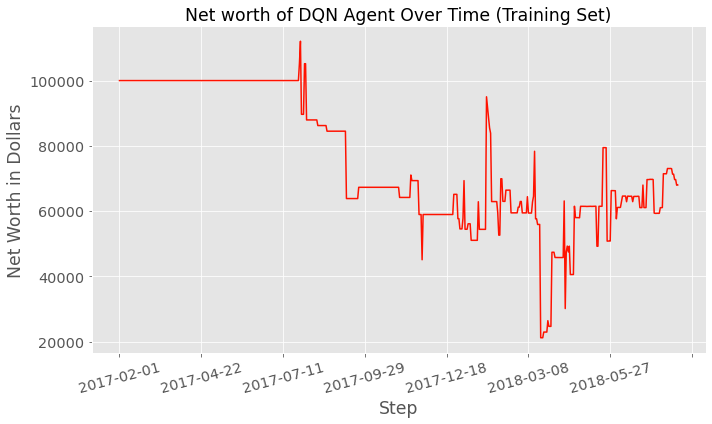

In [55]:
#Plot the networth
#dates = subset_data.index

plt.figure(figsize=(10, 6), tight_layout=True)
plt.plot(train_data.index, portfolio.performance['net_worth'], label="Net Worth")
plt.xlabel("Step")
plt.ylabel("Net Worth in Dollars")
plt.title("Net worth of DQN Agent Over Time (Training Set)")



from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=15)

plt.show()

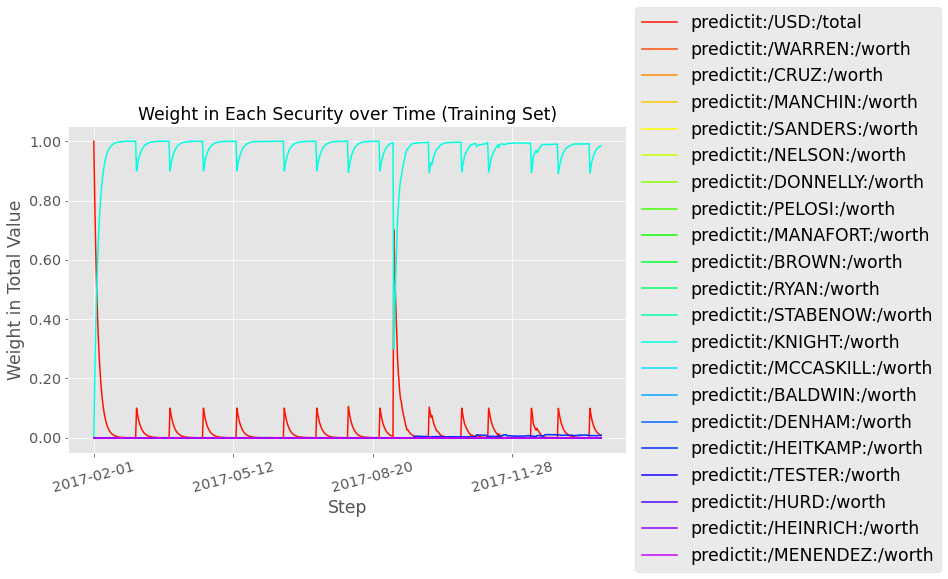

In [56]:
### Plot the total balance in each type of item
import seaborn as sns

sns.set_palette(sns.color_palette('gist_rainbow', 22))

weights_df = portfolio.weights 
weights_df.index = train_data.index

ax = weights_df.iloc[:,:].plot(figsize=(10, 6))




plt.xlabel("Step")
plt.ylabel("Weight in Total Value")
plt.title("Weight in Each Security over Time (Training Set)")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))

from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))
plt.xticks(rotation=15)

plt.show()

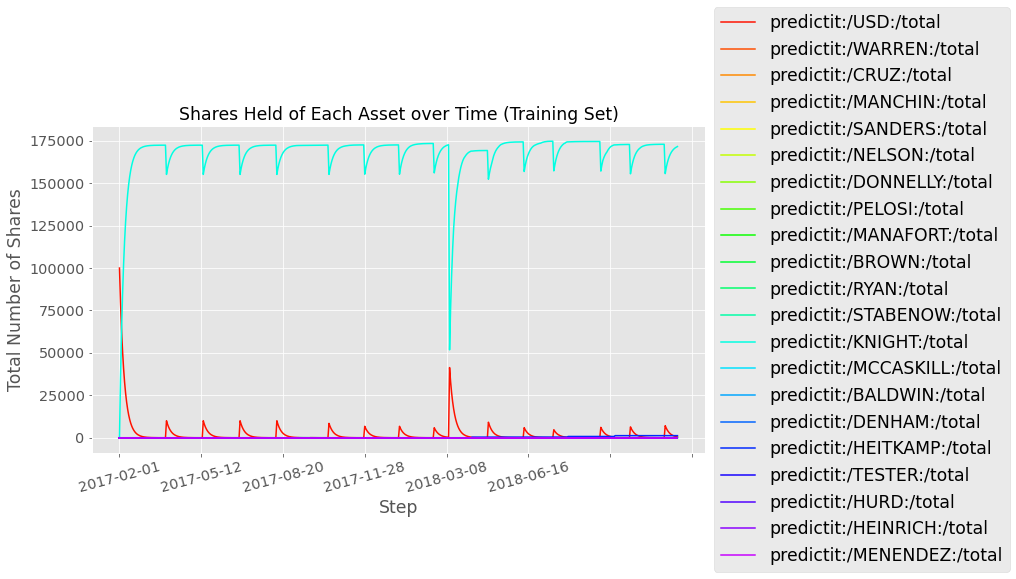

In [57]:
total_shares = portfolio.performance.loc[:, [("total" in name) for name in portfolio.performance.columns]]
total_shares.index = train_data.index
#del total_shares["predictit:/USD:/total"]
total_shares.plot(figsize=(11, 6))

sns.set_palette(sns.color_palette('gist_rainbow', 22))

from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.xlabel("Step")
plt.ylabel("Total Number of Shares")
plt.title("Shares Held of Each Asset over Time (Training Set)")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))


from matplotlib.ticker import FormatStrFormatter
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=15)



plt.show()

In [58]:
#Get the Four Metrics

#First, final portfolio value:
networth = portfolio.performance["net_worth"]
print("Final Portfolio value", networth.iloc[-1])

#Calculate annualized return
annualized_return = (networth.iloc[-1]/networth.iloc[0])**(365/networth.index[-1]) - 1
print("Annualized return:", annualized_return*100, "percent")


#Calculate annualized standard deviation
returns = np.multiply(networth.pct_change().dropna().values, 100)
print("Annualized Vol", np.std(returns) * (365**.5), "percent")


##Calculate (Daily) Sharpe ratio 
print("Daily Sharpe Ratio", np.mean(returns)/np.std(returns))

Final Portfolio value 68001.53454450723
Annualized return: -22.72499060308073 percent
Annualized Vol 169.81524071352672 percent
Daily Sharpe Ratio 0.034803633054919535


#### Now Compare to Benchmark Strategies
Now, we can also repeat the same plot, but also plotting other benchmark strategies for comparison. Ultimately, this project chose to only focus on the "Uniform Buy and Hold" benchmark.

In [1059]:
#Split regular price data into training and testing set
all_train_data = all_data[(pd.to_datetime(all_data.index)>= '02-01-2017') & (pd.to_datetime(all_data.index) <= '08-01-2018')]
all_test_data = all_data[(pd.to_datetime(all_data.index) >= '08-02-2018') & (pd.to_datetime(all_data.index) <= '11-01-2018')]

In [1060]:
#Baseline strategies for training data

#Find the asset with the best returns over time period
train_closing_prices = all_train_data.loc[:, [("close" in name) for name in all_train_data.columns]]
best_asset = train_closing_prices.iloc[:, np.argmax(train_closing_prices.iloc[-1] - train_closing_prices.iloc[0])]
best_asset = np.multiply(best_asset, 100000/best_asset[0])



#Find the portfolio value from equal balanced portfolio
initial_value = 100000
value_for_each = initial_value/20
equal_weights = value_for_each/train_closing_prices.iloc[0]
equal_balanced_portfolio = train_closing_prices.mul(equal_weights, axis=1).sum(axis=1)




In [1066]:
agent_net_worth = portfolio.performance['net_worth']

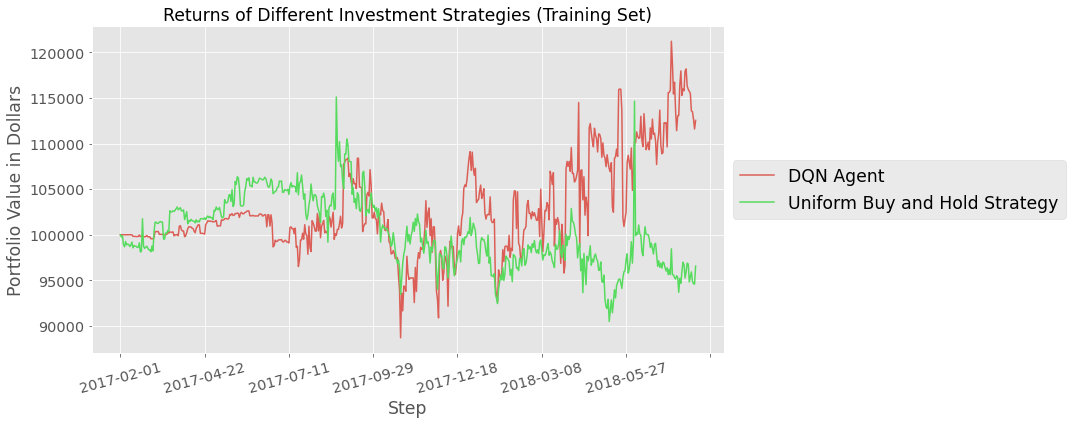

In [1123]:
#Plot
sns.set_palette(sns.color_palette('hls',3))

plt.figure(figsize=(15, 6), tight_layout=True)

plt.plot(best_asset.index, agent_net_worth, label="DQN Agent")
#plt.plot(best_asset.index, best_asset.values, label="Best Asset")
plt.plot(best_asset.index, equal_balanced_portfolio.values, label="Uniform Buy and Hold Strategy")

plt.xlabel("Step")
plt.ylabel("Portfolio Value in Dollars")
plt.title("Returns of Different Investment Strategies (Training Set)")

plt.legend(loc='center left', bbox_to_anchor=(1,.5))

from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=15)

plt.show()


In [1122]:
#Get the Four Metrics for Equal Balanced Portfolio

print("Uniform Buy and Hold STATS:")
#First, final portfolio value:
print("Final Portfolio value", equal_balanced_portfolio.values[-1])

#Calculate annualized return
annualized_return = (equal_balanced_portfolio.values[-1]/equal_balanced_portfolio.values[0])**(365/networth.index[-1]) - 1
print("Annualized return:", annualized_return*100, "percent")


#Calculate annualized standard deviation
returns = np.multiply(equal_balanced_portfolio.pct_change().dropna().values, 100)
print("Annualized Vol", np.std(returns) * (365**.5), "percent")


##Calculate (Daily) Sharpe ratio 
print("Daily Sharpe Ratio", np.mean(returns)/np.std(returns))

BEST ASSET STATS:
Final Portfolio value 96559.90389769064
Annualized return: -2.3130151204611926 percent
Annualized Vol 29.28808981019095 percent
Daily Sharpe Ratio 0.0033845247715596585


#### Add in the Random Agent to the graph
Use this if you want to compare the agent to a random agent.

In [1113]:
random_net_worths = []

In [1114]:
import random
for n in range(10):
    #Run the test. One episode only.
    for episode_num in range(1):
        state = train_env.reset()
        done = False
        cumulative_reward = 0
        step = 0
        action = random.randint(0,train_env.action_space.n - 1)
        while not done:
            action = random.randint(0,train_env.action_space.n - 1)
            #print(action)
            state, reward, done, results = train_env.step(action)
            #print(reward)
            #print(state["action_mask"][326])

            cumulative_reward += reward

            #Render every 100 steps:
            if step % 100 == 0:
                train_env.render()

            step += 1

    print("Cumulative reward: ", cumulative_reward)
    
    random_net_worths.append(portfolio.performance['net_worth'].values)
    


[2020-04-21 9:49:35 PM] Step: 1
[2020-04-21 9:49:56 PM] Step: 101
[2020-04-21 9:50:10 PM] Step: 201
[2020-04-21 9:50:22 PM] Step: 301
[2020-04-21 9:50:33 PM] Step: 401
[2020-04-21 9:50:47 PM] Step: 501
Cumulative reward:  0.0009427487203421141
[2020-04-21 9:50:52 PM] Step: 1
[2020-04-21 9:51:09 PM] Step: 101
[2020-04-21 9:51:20 PM] Step: 201
[2020-04-21 9:51:31 PM] Step: 301
[2020-04-21 9:51:40 PM] Step: 401
[2020-04-21 9:51:49 PM] Step: 501
Cumulative reward:  -0.0013440726005706568
[2020-04-21 9:51:55 PM] Step: 1
[2020-04-21 9:52:16 PM] Step: 101
[2020-04-21 9:52:30 PM] Step: 201
[2020-04-21 9:52:40 PM] Step: 301
[2020-04-21 9:52:52 PM] Step: 401
[2020-04-21 9:53:05 PM] Step: 501
Cumulative reward:  0.014704785434617253
[2020-04-21 9:53:11 PM] Step: 1
[2020-04-21 9:53:28 PM] Step: 101
[2020-04-21 9:53:36 PM] Step: 201
[2020-04-21 9:53:48 PM] Step: 301
[2020-04-21 9:54:03 PM] Step: 401
[2020-04-21 9:54:14 PM] Step: 501
Cumulative reward:  -0.022595173996506818
[2020-04-21 9:54:20 PM] 

In [1115]:
random_net_worth = np.mean(random_net_worths, axis=0)

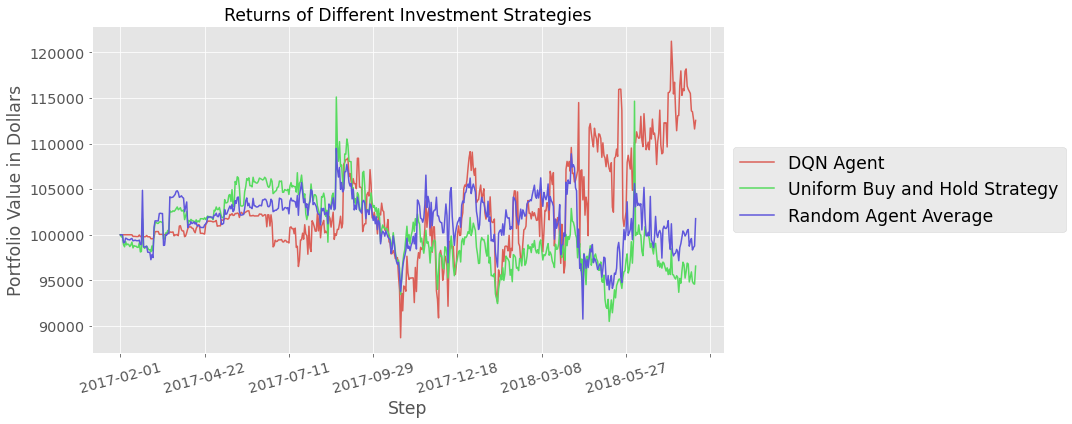

In [1116]:
#Plot
sns.set_palette(sns.color_palette('hls',3))

plt.figure(figsize=(15, 6), tight_layout=True)

plt.plot(best_asset.index, agent_net_worth, label="DQN Agent")
plt.plot(best_asset.index, equal_balanced_portfolio.values, label="Uniform Buy and Hold Strategy")
plt.plot(best_asset.index, random_net_worth, label="Random Agent Average")

plt.xlabel("Step")
plt.ylabel("Portfolio Value in Dollars")
plt.title("Returns of Different Investment Strategies")

plt.legend(loc='center left', bbox_to_anchor=(1,.5))

from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=15)

plt.show()


## Now Evaluate the Agent on the Testing Set
Now we can repeat the same evaluation we just did on the training set, but for the testing set instead.

#### First run agent on test set

In [1156]:
test_external_feed.reset()

In [1157]:
#Set up a testing environment with test data. The external feed is the only thing that's different. Environment is the same
test_env = TradingEnvironment(
    feed=test_external_feed,
    portfolio=portfolio,
    action_scheme='simple',
    reward_scheme='diversified',
    window_size=15,
    enable_logger=False,
    renderers = 'screenlog',
    use_internal = False,
)

/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [1158]:
#Run the test. One episode only.
for episode_num in range(1):
    state = test_env.reset()
    done = False
    cumulative_reward = 0
    step = 0
    action = trainer.compute_action(state, explore=False)
    while not done:
        action = trainer.compute_action(state, explore=False)
        print(action)
        state, reward, done, results = test_env.step(action)
        #print(reward)
        #print(state["action_mask"][326])

        cumulative_reward += reward
        
        #Render every 100 steps:
        if step % 100 == 0:
            test_env.render()
            
        step += 1
        
print("Cumulative reward: ", cumulative_reward)

230
[2020-04-22 12:51:07 AM] Step: 1
230
230
230
230
230
230
230
230
346
336
351
351
240
44
88
329
6
44
333
182
44
240
9
44
229
44
240
44
44
44
44
257
240
240
240
88
229
240
88
89
240
240
44
241
241
230
230
230
336
310
346
136
229
89
240
240
136
240
88
88
88
89
336
240
139
357
230
34
136
324
44
182
136
136
229
44
135
257
88
88
44
89
229
238
89
240
240
136
135
384
Cumulative reward:  0.0026647103926833696


#### Now plot the results

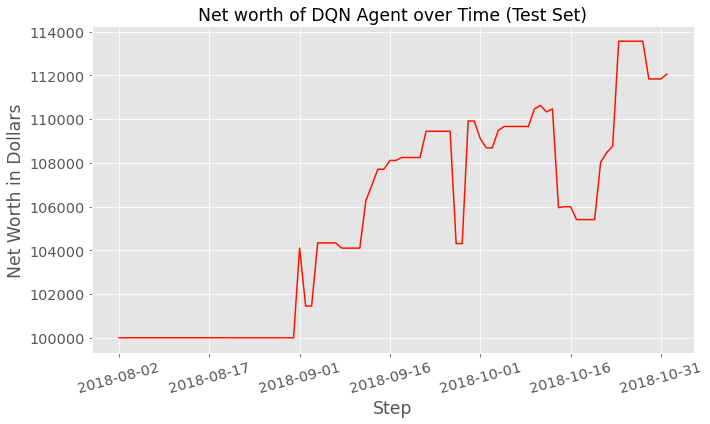

In [1159]:
#Plot the networth
#dates = subset_data.index

plt.figure(figsize=(10, 6), tight_layout=True)
plt.plot(test_data.index, portfolio.performance['net_worth'], label="Net Worth")
plt.xlabel("Step")
plt.ylabel("Net Worth in Dollars")
plt.title("Net worth of DQN Agent over Time (Test Set)")



from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=15)

plt.show()

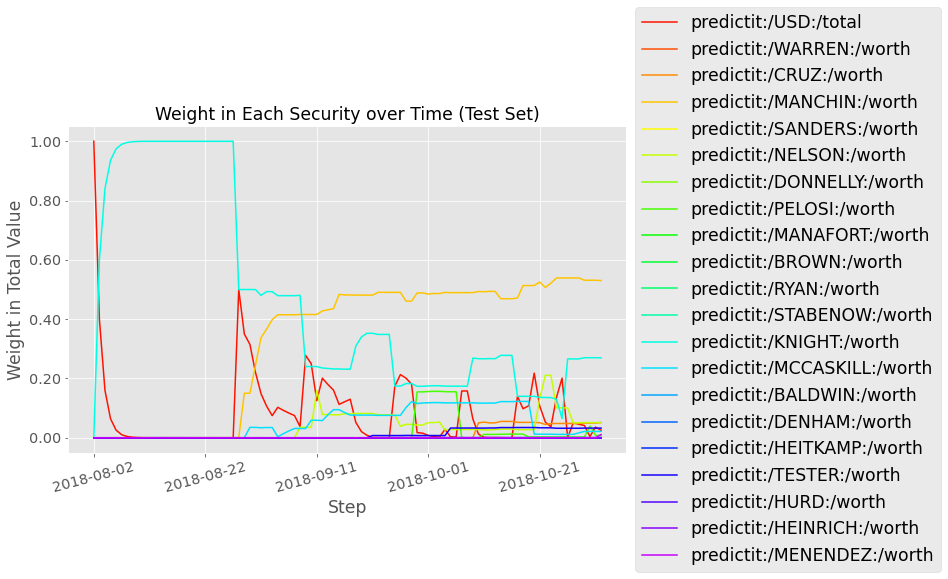

In [1160]:
### Plot the total balance in each type of item
import seaborn as sns

sns.set_palette(sns.color_palette('gist_rainbow', 22))

weights_df = portfolio.weights 
weights_df.index = test_data.index

ax = weights_df.iloc[:,:].plot(figsize=(10, 6))




plt.xlabel("Step")
plt.ylabel("Weight in Total Value")
plt.title("Weight in Each Security over Time (Test Set)")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))

from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))
plt.xticks(rotation=15)

plt.show()

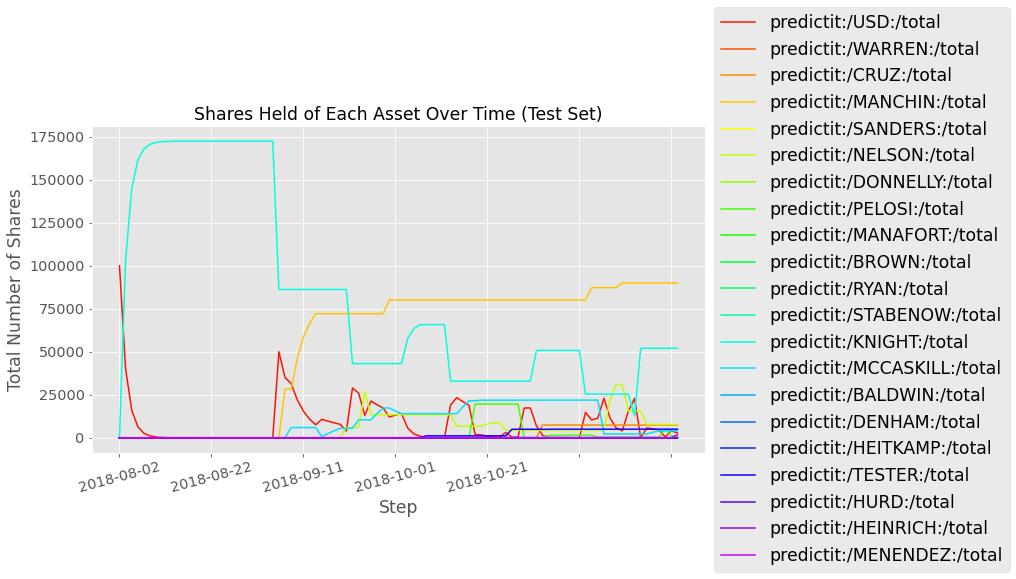

In [1167]:
sns.set_palette(sns.color_palette('gist_rainbow', 22))
total_shares = portfolio.performance.loc[:, [("total" in name) for name in portfolio.performance.columns]]
total_shares.index = test_data.index
#del total_shares["predictit:/USD:/total"]
total_shares.plot(figsize=(11, 6))



from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.xlabel("Step")
plt.ylabel("Total Number of Shares")
plt.title("Shares Held of Each Asset Over Time (Test Set)")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))


from matplotlib.ticker import FormatStrFormatter
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=15)



plt.show()

#### Now Compare To Benchmark Strategies

In [1162]:
#### First Training Set#Now get the baseline strategies for test data


#Find the asset with the best returns over time period
test_closing_prices = all_test_data.loc[:, [("close" in name) for name in all_test_data.columns]]
best_asset = test_closing_prices.loc[:, "KNIGHT:close"]
best_asset = np.multiply(best_asset, 100000/best_asset[0])



#Find the portfolio value from equal balanced portfolio
initial_value = 100000
value_for_each = initial_value/20
equal_weights = value_for_each/test_closing_prices.iloc[0]
equal_balanced_portfolio = test_closing_prices.mul(equal_weights, axis=1).sum(axis=1)


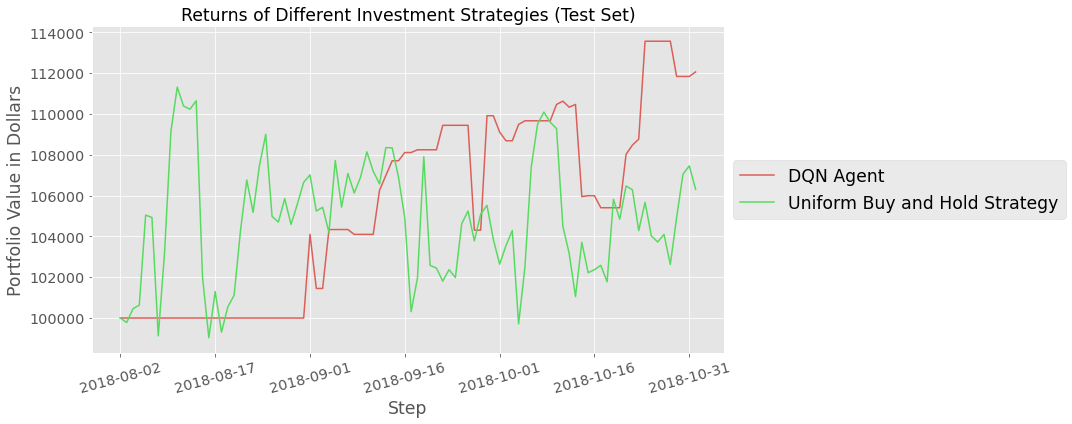

In [1163]:
#Plot
sns.set_palette(sns.color_palette('hls',3))

plt.figure(figsize=(15, 6), tight_layout=True)

plt.plot(best_asset.index, portfolio.performance['net_worth'], label="DQN Agent")
#plt.plot(best_asset.index, best_asset.values, label="Best Asset")
plt.plot(best_asset.index, equal_balanced_portfolio.values, label="Uniform Buy and Hold Strategy")

plt.xlabel("Step")
plt.ylabel("Portfolio Value in Dollars")
plt.title("Returns of Different Investment Strategies (Test Set)")

plt.legend(loc='center left', bbox_to_anchor=(1,.5))

from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=15)

plt.show()


In [1164]:
#Get the Four Metrics

#First, final portfolio value:
networth = portfolio.performance["net_worth"]
print("Final Portfolio value", networth.iloc[-1])

#Calculate annualized return
annualized_return = (networth.iloc[-1]/networth.iloc[0])**(365/networth.index[-1]) - 1
print("Annualized return:", annualized_return*100, "percent")


#Calculate annualized standard deviation
returns = np.multiply(networth.pct_change().dropna().values, 100)
print("Annualized Vol", np.std(returns) * (365**.5), "percent")


##Calculate (Daily) Sharpe ratio 
print("Daily Sharpe Ratio", np.mean(returns)/np.std(returns))

Final Portfolio value 112054.13583151743
Annualized return: 57.85368554642156 percent
Annualized Vol 23.229202829880805 percent
Daily Sharpe Ratio 0.10896918000197522


In [1165]:
#Get the Four Metrics for Equal Balanced Portfolio

print("Uniform Buy and Hold STATS:")
#First, final portfolio value:
print("Final Portfolio value", equal_balanced_portfolio.values[-1])

#Calculate annualized return
annualized_return = (equal_balanced_portfolio.values[-1]/equal_balanced_portfolio.values[0])**(365/networth.index[-1]) - 1
print("Annualized return:", annualized_return*100, "percent")


#Calculate annualized standard deviation
returns = np.multiply(equal_balanced_portfolio.pct_change().dropna().values, 100)
print("Annualized Vol", np.std(returns) * (365**.5), "percent")


##Calculate (Daily) Sharpe ratio 
print("Daily Sharpe Ratio", np.mean(returns)/np.std(returns))

Uniform Buy and Hold STATS:
Final Portfolio value 106310.38095435424
Annualized return: 27.818800610220705 percent
Annualized Vol 44.202321149506055 percent
Daily Sharpe Ratio 0.04070075870714068
